<a href="https://colab.research.google.com/github/TomAmster/Data-Science/blob/master/Submission_Combined_Notebooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Submission - Robot or Human Facebook Competition

*   Yonatan Rosenberg
*   Orel Alon
*   Yizhar Almagor
*   Tom Amsterdam

**Table Of Content - Chapters**

1.   EDA Explaratory Data Analysis - Statistics and Visualization
2.   Data Pre-Processing - Data Cleaning and Data Embeddings
3.   Time Sereis Analysis and Processing
4.   Feature Engineering
5.   Models and Model Comparison
6.   Cross Validation
7.   Kaggle Submission
8.   Feature Selection
9.   Error Analysis
10.  SMOTE Resampling 



In [0]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

In [2]:
!git clone "https://github.com/TomAmster/Data-Science.git"


Cloning into 'Data-Science'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 119 (delta 1), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (119/119), 261.95 MiB | 24.18 MiB/s, done.
Resolving deltas: 100% (63/63), done.
Checking out files: 100% (44/44), done.


# 1. EDA Explaratory Data Analysis

## 1.1 Loading the datasets


In [0]:
parts_num = 10
test_path = '/content/Data-Science/Data/test.csv'
train_path = '/content/Data-Science/Data/train.csv'

bids = pd.read_csv('/content/Data-Science/Data/split_bids/bids_part_0.csv')
bids = bids.drop(columns=['Unnamed: 0'])
for i in range(1,parts_num):
  bids_part = pd.read_csv('/content/Data-Science/Data/split_bids/bids_part_'+ str(i)+ '.csv')
  bids_part = bids_part.drop(columns=['Unnamed: 0'])
  bids = bids.append(bids_part, ignore_index=True)

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)


In [12]:
print(bids.shape)
print(train.shape)
print(test.shape)

(7656334, 9)
(2013, 4)
(4700, 3)


In [13]:
bids.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3


## 1.2 Merging Datasets- Train & Test with the Bids

In [14]:
bidders_df = pd.concat([train, test])
merged_bids = pd.merge(bidders_df, bids, on='bidder_id', how='left')

train_bids = pd.merge(train, bids, on='bidder_id', how='left')
merged_bids.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,address,bidder_id,outcome,payment_account,bid_id,auction,merchandise,device,time,country,ip,url
0,a3d2de7675556553a5f08e4c88d2c228vt0u4,91a3c57b13234af24875c56fb7e2b2f4rb56a,0.0,a3d2de7675556553a5f08e4c88d2c228754av,85371.0,yitr4,home goods,phone35,9.759489e+15,ke,82.34.177.248,vasstdc27m7nks3
1,a3d2de7675556553a5f08e4c88d2c228vt0u4,91a3c57b13234af24875c56fb7e2b2f4rb56a,0.0,a3d2de7675556553a5f08e4c88d2c228754av,274487.0,btpyy,home goods,phone1004,9.760249e+15,zm,202.130.71.167,vasstdc27m7nks3
2,a3d2de7675556553a5f08e4c88d2c228vt0u4,91a3c57b13234af24875c56fb7e2b2f4rb56a,0.0,a3d2de7675556553a5f08e4c88d2c228754av,527436.0,kj2ko,home goods,phone4,9.762261e+15,ke,22.54.76.225,vasstdc27m7nks3
3,a3d2de7675556553a5f08e4c88d2c228vt0u4,91a3c57b13234af24875c56fb7e2b2f4rb56a,0.0,a3d2de7675556553a5f08e4c88d2c228754av,554135.0,1m5t8,home goods,phone4,9.762431e+15,ke,32.13.237.126,vasstdc27m7nks3
4,a3d2de7675556553a5f08e4c88d2c228vt0u4,91a3c57b13234af24875c56fb7e2b2f4rb56a,0.0,a3d2de7675556553a5f08e4c88d2c228754av,607628.0,btpyy,home goods,phone4,9.762789e+15,ke,202.236.188.240,vasstdc27m7nks3
5,a3d2de7675556553a5f08e4c88d2c228vt0u4,91a3c57b13234af24875c56fb7e2b2f4rb56a,0.0,a3d2de7675556553a5f08e4c88d2c228754av,666164.0,1m5t8,home goods,phone35,9.763163e+15,ke,192.145.217.243,vasstdc27m7nks3
6,a3d2de7675556553a5f08e4c88d2c228vt0u4,91a3c57b13234af24875c56fb7e2b2f4rb56a,0.0,a3d2de7675556553a5f08e4c88d2c228754av,700546.0,0xo1d,home goods,phone4,9.763386e+15,et,223.233.166.93,vasstdc27m7nks3
7,a3d2de7675556553a5f08e4c88d2c228vt0u4,91a3c57b13234af24875c56fb7e2b2f4rb56a,0.0,a3d2de7675556553a5f08e4c88d2c228754av,926676.0,pfl78,home goods,phone195,9.764267e+15,ke,190.63.186.68,vasstdc27m7nks3
8,a3d2de7675556553a5f08e4c88d2c228vt0u4,91a3c57b13234af24875c56fb7e2b2f4rb56a,0.0,a3d2de7675556553a5f08e4c88d2c228754av,960606.0,xs8rq,home goods,phone4,9.764392e+15,ke,17.72.96.225,vasstdc27m7nks3
9,a3d2de7675556553a5f08e4c88d2c228vt0u4,91a3c57b13234af24875c56fb7e2b2f4rb56a,0.0,a3d2de7675556553a5f08e4c88d2c228754av,1023806.0,wzwhk,home goods,phone79,9.764658e+15,ng,209.80.85.101,vasstdc27m7nks3


## 1.3 Creating Count Statistics for the pararmeters

In [0]:
bids_count = bids.groupby("bidder_id")["bid_id","device","country","ip","merchandise","auction","url"].nunique()
bids_count.reset_index(inplace=True)
bids_count = bids_count.add_prefix("count_")
bids_count.rename(columns={"count_bidder_id":"bidder_id"},inplace=True)
train_counts = pd.merge(train,bids_count,on="bidder_id",how="left")

In [16]:
train_counts.head()

,bidder_id,payment_account,address,outcome,count_bid_id,count_device,count_country,count_ip,count_merchandise,count_auction,count_url
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,24.0,14.0,6.0,20.0,1.0,18.0,1.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0,3.0,2.0,1.0,3.0,1.0,1.0,2.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0,4.0,2.0,1.0,4.0,1.0,4.0,2.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0,155.0,53.0,2.0,123.0,1.0,23.0,91.0


### 1.4 Creating Count Statistics Per Parameter Per Auction

In [0]:
train_counts['average_bids_per_auction'] = train_counts.apply(lambda row:row['count_bid_id']/row['count_auction'] if row['count_auction']>0 else 0, axis=1) 
train_counts['average_bids_per_url'] = train_counts.apply(lambda row:row['count_bid_id']/row['count_url'] if row['count_url']>0 else 0, axis=1) 
train_counts['average_bids_per_device'] = train_counts.apply(lambda row:row['count_bid_id']/row['count_device'] if row['count_device']>0 else 0, axis=1) 
train_counts['average_bids_per_country'] = train_counts.apply(lambda row:row['count_bid_id']/row['count_country'] if row['count_country']>0 else 0, axis=1) 

In [18]:
train_counts.head()

,bidder_id,payment_account,address,outcome,count_bid_id,count_device,count_country,count_ip,count_merchandise,count_auction,count_url,average_bids_per_auction,average_bids_per_url,average_bids_per_device,average_bids_per_country
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,24.0,14.0,6.0,20.0,1.0,18.0,1.0,1.333333,24.000000,1.714286,4.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0,3.0,2.0,1.0,3.0,1.0,1.0,2.0,3.000000,1.500000,1.500000,3.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0,4.0,2.0,1.0,4.0,1.0,4.0,2.0,1.000000,2.000000,2.000000,4.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0,155.0,53.0,2.0,123.0,1.0,23.0,91.0,6.739130,1.703297,2.924528,77.5


In [0]:
human_data = train_counts[train_counts['outcome'] == 0]
robot_data = train_counts[train_counts['outcome'] == 1]

In [20]:
print(f"average bids per robot: %.0f" % robot_data.count_bid_id.mean() )
print(f"average bids per human:  %.0f" % human_data.count_bid_id.mean())
print(f"average bids per auction by robot: %.0f" % robot_data.average_bids_per_auction.mean())
print(f"average bids per auction by human:  %.0f" % human_data.average_bids_per_auction.mean())
print(f"average number of devices by robot: %.0f" % robot_data.count_device.mean())
print(f"average number of devices by human:  %.0f" % human_data.count_device.mean())
print(f"average number of IPs by robot: %.0f" % robot_data.count_ip.mean())
print(f"average number of IPs by human:  %.0f" % human_data.count_ip.mean())
print(f"average number of URLs by robot: %.0f" % robot_data.count_url.mean())
print(f"average number of URLs by human:  %.0f" % human_data.count_url.mean())

average bids per robot: 4004
average bids per human:  1414
average bids per auction by robot: 23
average bids per auction by human:  6
average number of devices by robot: 164
average number of devices by human:  74
average number of IPs by robot: 2388
average number of IPs by human:  581
average number of URLs by robot: 545
average number of URLs by human:  335


## 1.5 Visualizations

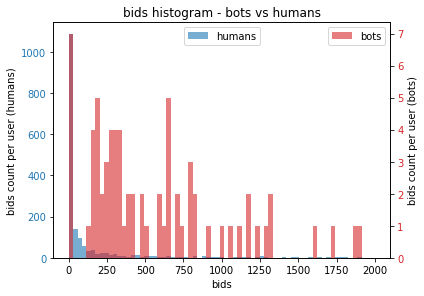

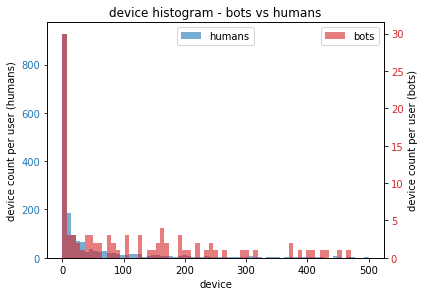

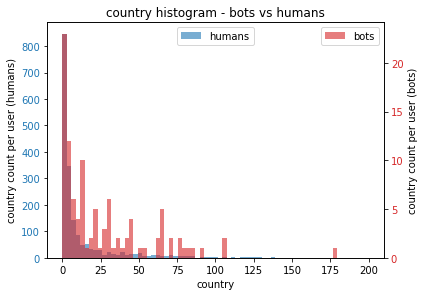

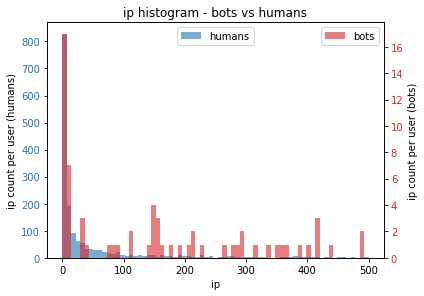

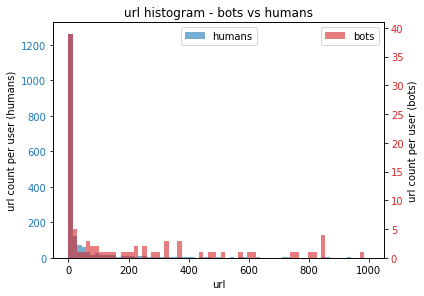

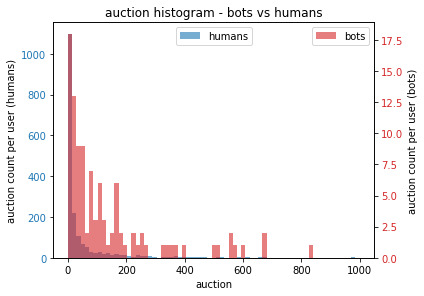

In [21]:
def plot_hist(column_name,lowest_bin,highest_bin,no_bins,name,joined):
  fig, ax1 = plt.subplots()
  bins = np.linspace(lowest_bin,highest_bin,no_bins)
  color = 'tab:blue'
  col_name = name

  ax1.hist(joined[joined['outcome'] == 0 ][column_name],bins,color=color,alpha=0.6,label='humans')
  ax1.tick_params(axis='y', labelcolor=color)
  ax1.legend(loc='upper center')
  ax1.set_ylabel(col_name+' count per user (humans)')
  ax1.set_xlabel(col_name)

  ax2 = ax1.twinx() 
  color = 'tab:red'
  ax2.hist(joined[joined['outcome'] == 1 ][column_name],bins,color=color,alpha=0.6,label='bots')
  ax2.tick_params(axis='y', labelcolor=color)
  ax2.legend(loc='upper right')
  ax2.set_ylabel(col_name +' count per user (bots)')

  fig.tight_layout()
  plt.title(col_name + ' histogram - bots vs humans')
  plt.xlabel('bid count per user')

  plt.show()

plot_hist('count_bid_id',0,2000,70,'bids',train_counts)
plot_hist('count_device',0,500,70,'device',train_counts)
plot_hist('count_country',0,200,70,'country',train_counts)
plot_hist('count_ip',0,500,70,'ip',train_counts)
plot_hist('count_url',0,1000,70,'url',train_counts)
plot_hist('count_auction',0,1000,70,'auction',train_counts)

from the above we can conclude **that the average bot uses a lot more bids, ip's and devices** and participates in **many more auctions** than the average human.
we will now try to see if ther is a specific value that correlates with bots :


In [22]:

#this line takes only bids that belong to train - thus we add the labels to the bids
train_bids = pd.merge(train, bids, on='bidder_id', how='left')

bots = train_bids[train_bids['outcome'] == 1]
humans = train_bids[train_bids['outcome'] == 0]

bots_country = bots.groupby('country').count()
bots_country = bots_country.drop(columns=['payment_account','address','outcome','time','bid_id','auction','merchandise','device','ip','url'])
bots_country =bots_country.rename(columns={'bidder_id': 'bots'})
bots_country = bots_country.sort_values(by=['bots'], ascending=False)
bots_sum = bots_country['bots'].sum()
bots_country['bots_per'] = bots_country['bots'].div(bots_sum)
bots_country['bots_per'] = bots_country['bots_per'].multiply(100)

# bots_country = bots_country.drop(columns=['bots'])

human_country = humans.groupby('country').count()
human_country = human_country.drop(columns=['payment_account','address','outcome','time','bid_id','auction','merchandise','device','ip','url'])
human_country =human_country.rename(columns={'bidder_id': 'humans'})
human_country = human_country.sort_values(by=['humans'], ascending=False)
human_sum = human_country['humans'].sum()
human_country['human_per'] = human_country['humans'].div(human_sum)
human_country['human_per'] = human_country['human_per'].multiply(100)
# human_country = human_country.drop(columns=['humans'])

#for each country we want the percentage of bots / humans
country_perc = bots_country.join(human_country, on='country')
country_perc.head(10)
country_perc.reset_index(inplace=True)


country_perc.head(10)


,country,bots,bots_per,humans,human_per
0,in,86386,20.959692,559245.0,21.052978
1,us,66663,16.174333,73380.0,2.762416
2,id,20495,4.972668,153733.0,5.787334
3,de,18530,4.495903,10436.0,0.392867
4,th,17282,4.193103,67432.0,2.538502
5,za,13364,3.242485,141974.0,5.344662
6,ru,11100,2.693175,42774.0,1.610243
7,mx,10848,2.632032,46438.0,1.748175
8,my,10488,2.544686,77319.0,2.910701
9,ca,9205,2.233394,7804.0,0.293784


(97, 100)

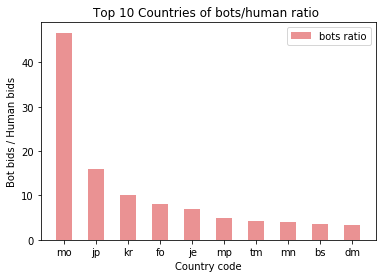

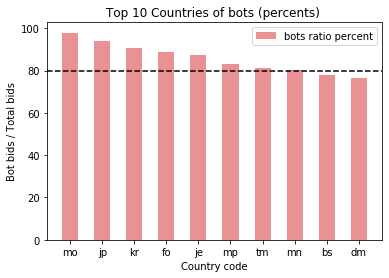

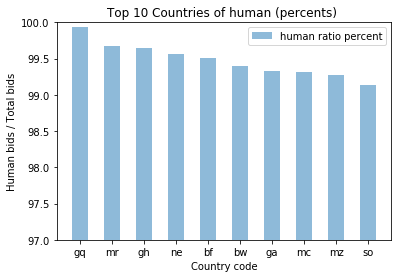

In [23]:
top = 10
country_perc['bots_ratio'] = country_perc['bots'] / country_perc['humans']
country_perc.head(10)

gr = country_perc.nlargest(top, 'bots_ratio')
width = 0.5
ind = [i for i in range(top)]
plt.figure()
plt.bar(ind,gr['bots_ratio'], width,label='bots ratio',color = 'tab:red',alpha=0.5)
plt.xticks(ind,gr['country'])
plt.title('Top ' + str(top) + ' Countries of bots/human ratio ')
plt.ylabel('Bot bids / Human bids')
plt.xlabel('Country code')
plt.legend()


country_perc['sum'] = country_perc['humans'] + country_perc['bots']
country_perc['bots_ratio_per'] = country_perc['bots'] / country_perc['sum']
country_perc['bots_ratio_per'] = country_perc['bots_ratio_per'].multiply(100)


gr = country_perc.nlargest(top, 'bots_ratio_per')
width = 0.5
ind = [i for i in range(top)]
plt.figure()
plt.bar(ind,gr['bots_ratio_per'], width,label='bots ratio percent',color = 'tab:red',alpha=0.5)
plt.xticks(ind,gr['country'])
plt.title('Top ' + str(top) + ' Countries of bots (percents) ')
plt.ylabel('Bot bids / Total bids')
plt.xlabel('Country code')
plt.legend()
# plt.ylim([75,100])
plt.axhline(y=80,linestyle='--',color='k')

country_perc['human_ratio_per'] = country_perc['humans'] / country_perc['sum']
country_perc['human_ratio_per'] = country_perc['human_ratio_per'].multiply(100)


gr = country_perc.nlargest(top, 'human_ratio_per')
width = 0.5
ind = [i for i in range(top)]
plt.figure()
plt.bar(ind,gr['human_ratio_per'], width,label='human ratio percent',color = 'tab:blue',alpha=0.5)
plt.xticks(ind,gr['country'])
plt.title('Top ' + str(top) + ' Countries of human (percents) ')
plt.ylabel('Human bids / Total bids')
plt.xlabel('Country code')
plt.legend()
plt.ylim([97,100])

# 2. Data Preprocessing

In [0]:
bid = pd.merge(train, bids, on='bidder_id', how='left')

## 2.1 Data Cleaning

### 2.1.1 Checking Missing Values

In [25]:
pd.isnull(bid).sum()

bidder_id             0
payment_account       0
address               0
outcome               0
bid_id               29
auction              29
merchandise          29
device               29
time                 29
country            2730
ip                   29
url                  29
dtype: int64

### 2.1.2 Check for bidder without bids

In [26]:
nobids_train = bid[pd.isnull(bid['bid_id'])]['bidder_id'].unique()
print("amout of bidders without bids",len(nobids_train))


amout of bidders without bids 29


### 2.1.3 Drop Bidders without bids

In [0]:
bid = bid[~bid['bidder_id'].isin(nobids_train)]

In [28]:
pd.isnull(bid).sum()

bidder_id             0
payment_account       0
address               0
outcome               0
bid_id                0
auction               0
merchandise           0
device                0
time                  0
country            2701
ip                    0
url                   0
dtype: int64

In [29]:
count_miss_ratio = pd.isnull(bid['country']).sum()/len(bid)*100
print(f" %0.2f %% observations missing country entry." %
      float(count_miss_ratio))
print()

 0.09 % observations missing country entry.



In [30]:
bid = bid.dropna()
pd.isnull(bid).any()


bidder_id          False
payment_account    False
address            False
outcome            False
bid_id             False
auction            False
merchandise        False
device             False
time               False
country            False
ip                 False
url                False
dtype: bool

## 2.2 Data Embedding & Representation

### 2.2.1 Representing Address and Payment Accounts with Bins

In [31]:
### Strip last 5 digits from payment__account and address
temp_train = train
temp_train.address = temp_train.address.apply(lambda x: x[:-5])
temp_train.payment_account = temp_train.payment_account.apply(lambda x: x[:-5])

## DO THE SAME FOR TEST
temp_test = test
temp_test.address = temp_test.address.apply(lambda x: x[:-5])
temp_test.payment_account = temp_test.payment_account.apply(lambda x: x[:-5])

## Create Feature - is payment account and address are equal
temp_train['payment_account_prefix_same_as_address_prefix'] = temp_train['address']==temp_train['payment_account']
temp_test['payment_account_prefix_same_as_address_prefix'] = temp_test['address']==temp_test['payment_account']

## Create Feature from Address - 
## Convert Rare and infrequent addresses to bins 
## Create One-Hot Encoding of the Rest of the Addresses
temp = temp_train[['bidder_id', 'address']].groupby('address').size().reset_index().sort_values(0, ascending=False)
temp = 	temp.rename(columns = {0:'address_count'})
infrequent_addresses = temp[temp.address_count >= 2][temp.address_count < 6].address.values
rare_addresses = temp[temp.address_count < 2].address.values
temp_train['address'].loc[temp_train.address.isin(rare_addresses)] = 'rare_address'
temp_train['address'].loc[temp_train.address.isin(infrequent_addresses)] = 'infrequent_address'
temp = pd.get_dummies(temp_train[['address']])
temp_train = pd.concat([temp_train, temp], axis=1)
###-------------
temp2 = temp_test[['bidder_id', 'address']].groupby('address').size().reset_index().sort_values(0, ascending=False)
temp2 = temp2.rename(columns = {0:'address_count'})
infrequent_addresses2 = temp2[temp2.address_count >= 2][temp2.address_count < 6].address.values
rare_addresses2= temp2[temp2.address_count < 2].address.values
temp_test['address'].loc[temp_test.address.isin(rare_addresses2)] = 'rare_address'
temp_test['address'].loc[temp_test.address.isin(infrequent_addresses2)] = 'infrequent_address'
temp2 = pd.get_dummies(temp_test[['address']])
temp_test = pd.concat([temp_test, temp2], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [32]:
## Create Feature from Payment Accounts - 
## Convert Rare and infrequent Payment Accounts to bins 
## Create One-Hot Encoding of the Rest of the Payment Accounts
temp = temp_train[['bidder_id', 'payment_account']].groupby('payment_account').size().reset_index().sort_values(0, ascending=False)
temp = temp.rename(columns = {0:'payment_account_count'})
temp2 = temp_test[['bidder_id', 'payment_account']].groupby('payment_account').size().reset_index().sort_values(0, ascending=False)
temp2 = temp2.rename(columns = {0:'payment_account_count'})

infrequent_payment_account = temp[temp.payment_account_count >= 2][temp.payment_account_count < 6].payment_account.values
rare_payment_account = temp[temp.payment_account_count < 2].payment_account.values
temp_train['payment_account'].loc[temp_train.payment_account.isin(rare_payment_account)] = 'rare_account'
temp_train['payment_account'].loc[temp_train.payment_account.isin(infrequent_payment_account)] = 'infrequent_account'	
temp =	pd.get_dummies(temp_train[['payment_account']])
temp_train = pd.concat([temp_train, temp], axis=1)

infrequent_payment_account2 = temp2[temp2.payment_account_count >= 2][temp2.payment_account_count < 6].payment_account.values
rare_payment_account2 = temp2[temp2.payment_account_count < 2].payment_account.values
temp_test['payment_account'].loc[temp_test.payment_account.isin(rare_payment_account2)] = 'rare_account'
temp_test['payment_account'].loc[temp_test.payment_account.isin(infrequent_payment_account2)] = 'infrequent_account'	
temp2 =	pd.get_dummies(temp_test[['payment_account']])
temp_test = pd.concat([temp_test, temp2], axis=1)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


### 2.2.2 One-Hot Encoding Merchandise Features - Categorical Information

In [0]:
data_train =pd.merge(temp_train,bids,on='bidder_id', how='left') 
data_test = pd.merge(temp_test,bids,on='bidder_id', how='left')

In [34]:
print(data_train.merchandise.value_counts())
print(data_test.merchandise.value_counts())

sporting goods      1169724
mobile               597488
jewelry              592735
home goods           407957
office equipment     168638
furniture             87807
computers             21400
books and music       15242
auto parts             9757
clothing                476
Name: merchandise, dtype: int64
mobile              1529099
jewelry             1309323
home goods           816277
sporting goods       685483
office equipment     121200
computers             59684
books and music       36699
clothing              15971
furniture             11374
Name: merchandise, dtype: int64


In [0]:
a = data_train.groupby('bidder_id').first().reset_index()
b = pd.get_dummies(a['merchandise'], columns='merchandise')
data_train = pd.concat([bid, b], axis=1)


a = data_test.groupby('bidder_id').first().reset_index()
b = pd.get_dummies(a['merchandise'], columns='merchandise')
data_test= pd.concat([data_test, b], axis=1)


In [0]:
data_test.shape

# 3. Time Series Analysis and Processing

In [0]:
parts_num = 10
test_path = '/content/Data-Science/Data/test.csv'
train_path = '/content/Data-Science/Data/train.csv'

bids = pd.read_csv('/content/Data-Science/Data/split_bids/bids_part_0.csv')
bids = bids.drop(columns=['Unnamed: 0'])
for i in range(1,parts_num):
  bids_part = pd.read_csv('/content/Data-Science/Data/split_bids/bids_part_'+ str(i)+ '.csv')
  bids_part = bids_part.drop(columns=['Unnamed: 0'])
  bids = bids.append(bids_part, ignore_index=True)

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

Joining train data with bid data so that we can use the "outcome" column

In [0]:
data = pd.merge(bids, train, on='bidder_id', how='left')

## 3.1 Bid Time Analysis

Let's do some exploration

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96e0354048>]],
      dtype=object)

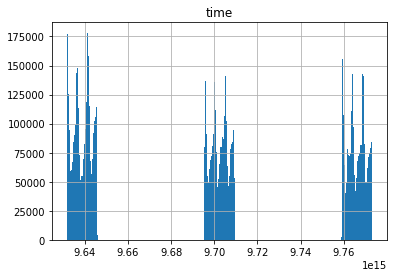

In [39]:
data.hist(column='time', bins=300)

Looks like 3 separate time periods. Let's expolore each individually.

In [40]:
period_1 = data[data.time < 9.66e15]
period_2 = data[data.time < 9.74e15][data.time > 9.66e15]
period_3 = data[data.time > 9.74e15]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Let's look at a histogram of the human bids vs the bot bids int the first period:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96e08c3b38>]],
      dtype=object)

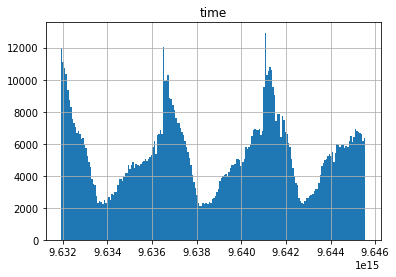

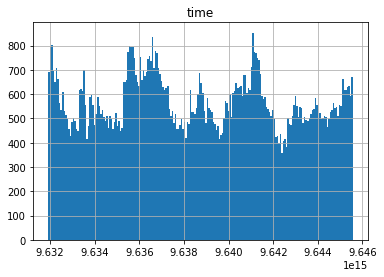

In [41]:
period_1_humans = period_1[period_1.outcome == 0]
period_1_bots = period_1[period_1.outcome == 1]
period_1_humans.hist(column='time', bins=200)
period_1_bots.hist(column='time', bins=200)

Interesting. Now let's look at period 2:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96c211ef28>]],
      dtype=object)

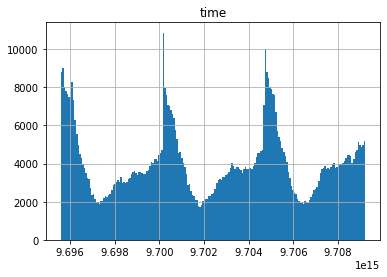

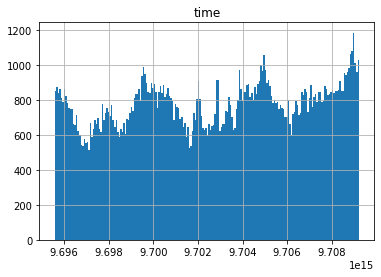

In [42]:
period_2_humans = period_2[period_2.outcome == 0]
period_2_bots = period_2[period_2.outcome == 1]
period_2_humans.hist(column='time', bins=200)
period_2_bots.hist(column='time', bins=200)

And period 3:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96e08a8908>]],
      dtype=object)

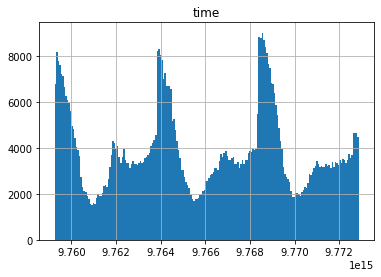

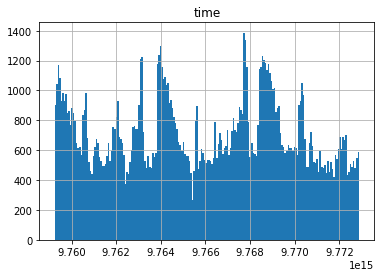

In [43]:
period_3_humans = period_3[period_3.outcome == 0]
period_3_bots = period_3[period_3.outcome == 1]
period_3_humans.hist(column='time', bins=200)
period_3_bots.hist(column='time', bins=200)

Conclusions:


1.   Human bid times are much more structured and periodical.
2.   Bot bid times are more sphoradic and noisy.
3.   Each of the 3 periods seems to have 3 distinct peaks in the human bids. We will conclude this is because each period represents 3 days, and the peaks correspond to some evening time, when people have more time to do online bidding.



## 3.2 Time Stamp Processing

Following our conclusions from the previous sections, we've decided to assign synthetic timestamps to our data, in a way that preserves order and scale and would assign the human bids peaks to 7pm. We've placed the 3 periods a week apart from each other to avoid interference.

In [44]:
range_start_1 = 1543863600
range_end_1 = 1544122800
max_ts_1 = max(period_1.time)
min_ts_1 = min(period_1.time)
period_1.loc[:,'new_ts'] = range_start_1 + ((period_1.time - min_ts_1) / (max_ts_1 - min_ts_1)) * (range_end_1 - range_start_1)
period_1.loc[:,'new_ts'] = pd.to_datetime(period_1.new_ts, unit='s')
period_1.loc[:,'hour_of_day'] = period_1.new_ts.dt.hour

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Let's look at a histogram of the hours we've assigned to this period's data:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96e032d7b8>]],
      dtype=object)

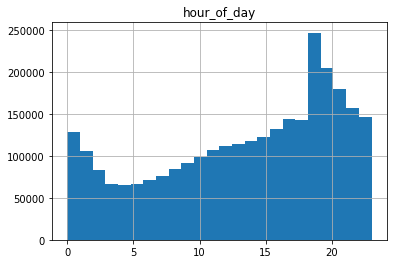

In [45]:
period_1.hist(column='hour_of_day', bins=24)

This looks good. Let's repeat for period 2:

In [0]:
range_start_2 = 1544468400
range_end_2 = 1544727600
max_ts_2 = max(period_2.time)
min_ts_2 = min(period_2.time)
period_2.loc[:,'new_ts'] = range_start_2 + ((period_2.time - min_ts_2) / (max_ts_2 - min_ts_2)) * (range_end_2 - range_start_2)
period_2.loc[:,'new_ts'] = pd.to_datetime(period_2.new_ts, unit='s')
period_2.loc[:,'hour_of_day'] = period_2.new_ts.dt.hour

Here's preoid 2's histogram:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96c1db4978>]],
      dtype=object)

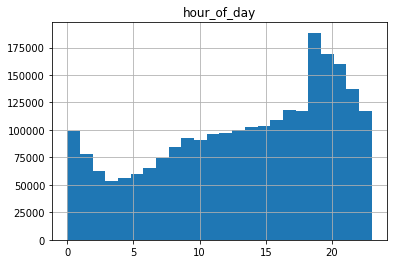

In [47]:
period_2.hist(column='hour_of_day', bins=24)

And period 3:

In [48]:
range_start_3 = 1545073200
range_end_3 = 1545332400
max_ts_3 = max(period_3.time)
min_ts_3 = min(period_3.time)
period_3.loc[:,'new_ts'] = range_start_3 + ((period_3.time - min_ts_3) / (max_ts_3 - min_ts_3)) * (range_end_3 - range_start_3)
period_3.loc[:,'new_ts'] = pd.to_datetime(period_3.new_ts, unit='s')
period_3.loc[:,'hour_of_day'] = period_3.new_ts.dt.hour

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [49]:
units_per_day = (max_ts_3 - min_ts_3) / 3
units_per_hour = units_per_day / 24
units_per_minute = units_per_hour / 60
units_per_second = units_per_minute / 60
print(f"Each second corresponds to {units_per_second} of original 'time' units")

Each second corresponds to 52631375.8934375 of original 'time' units


With it's histogram:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96c1cd5b70>]],
      dtype=object)

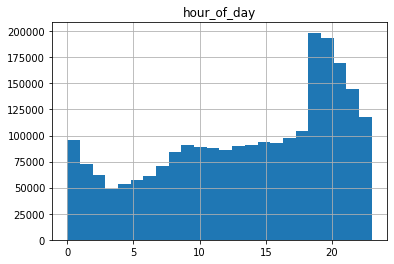

In [50]:
period_3.hist(column='hour_of_day', bins=24)

We have now successfully generated 2 features that will prove critical moving forward: "new_ts" and "hour_of_day". Many important features will rely on them.

## 3.3 Time Based Feature Analsysis

Our time-based features will be using our generated new_ts and hour_of_day columns. The features that will be using these columns will quantify:


1.   Number and fraction (ratio) of bids in the first and last 10% of the auction.
2.   Time difference between bids per auction.
3.   Change times of ip, device, country.
4.   Ratio of bids in four 6-hour windows of hour_of_day.
5.   Bidding velocity - number of bids within rolling window of time.



In [0]:
new_data = pd.concat([period_1, period_2, period_3])

# 4. Feature Engineering

Some Feature Engineering may take along of time. Therefore we save the intermediate results of each part.
The results can be loaded into dataframes in order to skip different parts.

In [0]:
parts_num = 10
test_path = '/content/Data-Science/Data/test.csv'
train_path = '/content/Data-Science/Data/train.csv'

bids = pd.read_csv('/content/Data-Science/Data/split_bids/bids_part_0.csv')
bids = bids.drop(columns=['Unnamed: 0'])
for i in range(1,parts_num):
  bids_part = pd.read_csv('/content/Data-Science/Data/split_bids/bids_part_'+ str(i)+ '.csv')
  bids_part = bids_part.drop(columns=['Unnamed: 0'])
  bids = bids.append(bids_part, ignore_index=True)

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [4]:
### Strip last 5 digits from payment__account and address
temp_train = train
temp_train.address = temp_train.address.apply(lambda x: x[:-5])
temp_train.payment_account = temp_train.payment_account.apply(lambda x: x[:-5])

## DO THE SAME FOR TEST
temp_test = test
temp_test.address = temp_test.address.apply(lambda x: x[:-5])
temp_test.payment_account = temp_test.payment_account.apply(lambda x: x[:-5])

## Create Feature - is payment account and address are equal
temp_train['payment_account_prefix_same_as_address_prefix'] = temp_train['address']==temp_train['payment_account']
temp_test['payment_account_prefix_same_as_address_prefix'] = temp_test['address']==temp_test['payment_account']

## Create Feature from Address - 
## Convert Rare and infrequent addresses to bins 
## Create One-Hot Encoding of the Rest of the Addresses
temp = temp_train[['bidder_id', 'address']].groupby('address').size().reset_index().sort_values(0, ascending=False)
temp = 	temp.rename(columns = {0:'address_count'})
infrequent_addresses = temp[temp.address_count >= 2][temp.address_count < 6].address.values
rare_addresses = temp[temp.address_count < 2].address.values
temp_train['address'].loc[temp_train.address.isin(rare_addresses)] = 'rare_address'
temp_train['address'].loc[temp_train.address.isin(infrequent_addresses)] = 'infrequent_address'
temp = pd.get_dummies(temp_train[['address']])
temp_train = pd.concat([temp_train, temp], axis=1)
###-------------
temp2 = temp_test[['bidder_id', 'address']].groupby('address').size().reset_index().sort_values(0, ascending=False)
temp2 = temp2.rename(columns = {0:'address_count'})
infrequent_addresses2 = temp2[temp2.address_count >= 2][temp2.address_count < 6].address.values
rare_addresses2= temp2[temp2.address_count < 2].address.values
temp_test['address'].loc[temp_test.address.isin(rare_addresses2)] = 'rare_address'
temp_test['address'].loc[temp_test.address.isin(infrequent_addresses2)] = 'infrequent_address'
temp2 = pd.get_dummies(temp_test[['address']])
temp_test = pd.concat([temp_test, temp2], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [5]:
## Create Feature from Payment Accounts - 
## Convert Rare and infrequent Payment Accounts to bins 
## Create One-Hot Encoding of the Rest of the Payment Accounts
temp = temp_train[['bidder_id', 'payment_account']].groupby('payment_account').size().reset_index().sort_values(0, ascending=False)
temp = temp.rename(columns = {0:'payment_account_count'})
temp2 = temp_test[['bidder_id', 'payment_account']].groupby('payment_account').size().reset_index().sort_values(0, ascending=False)
temp2 = temp2.rename(columns = {0:'payment_account_count'})

infrequent_payment_account = temp[temp.payment_account_count >= 2][temp.payment_account_count < 6].payment_account.values
rare_payment_account = temp[temp.payment_account_count < 2].payment_account.values
temp_train['payment_account'].loc[temp_train.payment_account.isin(rare_payment_account)] = 'rare_account'
temp_train['payment_account'].loc[temp_train.payment_account.isin(infrequent_payment_account)] = 'infrequent_account'	
temp =	pd.get_dummies(temp_train[['payment_account']])
temp_train = pd.concat([temp_train, temp], axis=1)

infrequent_payment_account2 = temp2[temp2.payment_account_count >= 2][temp2.payment_account_count < 6].payment_account.values
rare_payment_account2 = temp2[temp2.payment_account_count < 2].payment_account.values
temp_test['payment_account'].loc[temp_test.payment_account.isin(rare_payment_account2)] = 'rare_account'
temp_test['payment_account'].loc[temp_test.payment_account.isin(infrequent_payment_account2)] = 'infrequent_account'	
temp2 =	pd.get_dummies(temp_test[['payment_account']])
temp_test = pd.concat([temp_test, temp2], axis=1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


**Merge Train and Bids Data to Start Feature Extraction**

In [6]:
bid = pd.merge(temp_train, bids, on='bidder_id', how='left')
data_test = pd.merge(temp_test,bids,on='bidder_id', how='left')
data = bid
data.head(10)

,bidder_id,payment_account,address,outcome,payment_account_prefix_same_as_address_prefix,address_2367520c8d94e70f47f4e28e72004ef9,address_2a96c3ce94b3be921e0296097b88b56a,address_3a0b8057e5a900d872232c62a7f4c120,address_3a7e6a32b24aeab0688e91a41f3188e2,address_4d90f2e709f1fc0810e5aef472dd3935,address_5c9de1da50cc32a29ffd596ae24cd2be,address_794abfcfc9a51569c6415a61a319b352,address_91ea8f05b2be1f7fe36e86e20ea35105,address_a3d2de7675556553a5f08e4c88d2c228,address_b312117de5aeb80a49c753f562c4b2d3,address_c94cf5c3c5205afe0ef14ce669e01565,address_ca8d4b018cb62966eebb2974f5a83b4f,address_e048f5d50823df461686fde13a25d287,address_fb5f20b04f48113f484f73988d44a09a,address_infrequent_address,address_rare_address,payment_account_3e9073fb9219ceb4a1dc9dbb9e1acbe9,payment_account_a3d2de7675556553a5f08e4c88d2c228,payment_account_c9ef8f9c82a24602bca4f1fc4e69fd61,payment_account_infrequent_account,payment_account_rare_account,bid_id,auction,merchandise,device,time,country,ip,url
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228,a3d2de7675556553a5f08e4c88d2c228,0.0,True,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,85371.0,yitr4,home goods,phone35,9.759489e+15,ke,82.34.177.248,vasstdc27m7nks3
1,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228,a3d2de7675556553a5f08e4c88d2c228,0.0,True,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,274487.0,btpyy,home goods,phone1004,9.760249e+15,zm,202.130.71.167,vasstdc27m7nks3
2,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228,a3d2de7675556553a5f08e4c88d2c228,0.0,True,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,527436.0,kj2ko,home goods,phone4,9.762261e+15,ke,22.54.76.225,vasstdc27m7nks3
3,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228,a3d2de7675556553a5f08e4c88d2c228,0.0,True,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,554135.0,1m5t8,home goods,phone4,9.762431e+15,ke,32.13.237.126,vasstdc27m7nks3
4,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228,a3d2de7675556553a5f08e4c88d2c228,0.0,True,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,607628.0,btpyy,home goods,phone4,9.762789e+15,ke,202.236.188.240,vasstdc27m7nks3
5,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228,a3d2de7675556553a5f08e4c88d2c228,0.0,True,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,666164.0,1m5t8,home goods,phone35,9.763163e+15,ke,192.145.217.243,vasstdc27m7nks3
6,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228,a3d2de7675556553a5f08e4c88d2c228,0.0,True,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,700546.0,0xo1d,home goods,phone4,9.763386e+15,et,223.233.166.93,vasstdc27m7nks3
7,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228,a3d2de7675556553a5f08e4c88d2c228,0.0,True,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,926676.0,pfl78,home goods,phone195,9.764267e+15,ke,190.63.186.68,vasstdc27m7nks3
8,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228,a3d2de7675556553a5f08e4c88d2c228,0.0,True,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,960606.0,xs8rq,home goods,phone4,9.764392e+15,ke,17.72.96.225,vasstdc27m7nks3
9,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228,a3d2de7675556553a5f08e4c88d2c228,0.0,True,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1023806.0,wzwhk,home goods,phone79,9.764658e+15,ng,209.80.85.101,vasstdc27m7nks3


In [0]:
## Create One-Hot Encoding for Merchandise
a = data.groupby('bidder_id').first().reset_index()
b = pd.get_dummies(a['merchandise'], columns='merchandise')
data = pd.concat([data, b], axis=1)
data.head()

a = data_test.groupby('bidder_id').first().reset_index()
b = pd.get_dummies(a['merchandise'], columns='merchandise')
data_test= pd.concat([data_test, b], axis=1)

## 4.1  **Basic Count Features**

5.   Bids Count  Per User
6.   Auction Count Per User
7.   Merchandise Count Per User
8.   Device Count Per User
9.   Country Count Per User
10.   IP Count Per User
11.   URL Count Per User
12.   Average Number of Bid Per Auction
13.  Average Number of Bids Per Device
14.  Average Number of Bids Per URL
15.  Average Number of Bids Per Country


In [8]:
count_features =data.groupby(['bidder_id']).nunique()
count_features_test = data_test.groupby(['bidder_id']).nunique()
count_features.head()

,bidder_id,payment_account,address,outcome,payment_account_prefix_same_as_address_prefix,address_2367520c8d94e70f47f4e28e72004ef9,address_2a96c3ce94b3be921e0296097b88b56a,address_3a0b8057e5a900d872232c62a7f4c120,address_3a7e6a32b24aeab0688e91a41f3188e2,address_4d90f2e709f1fc0810e5aef472dd3935,address_5c9de1da50cc32a29ffd596ae24cd2be,address_794abfcfc9a51569c6415a61a319b352,address_91ea8f05b2be1f7fe36e86e20ea35105,address_a3d2de7675556553a5f08e4c88d2c228,address_b312117de5aeb80a49c753f562c4b2d3,address_c94cf5c3c5205afe0ef14ce669e01565,address_ca8d4b018cb62966eebb2974f5a83b4f,address_e048f5d50823df461686fde13a25d287,address_fb5f20b04f48113f484f73988d44a09a,address_infrequent_address,address_rare_address,payment_account_3e9073fb9219ceb4a1dc9dbb9e1acbe9,payment_account_a3d2de7675556553a5f08e4c88d2c228,payment_account_c9ef8f9c82a24602bca4f1fc4e69fd61,payment_account_infrequent_account,payment_account_rare_account,bid_id,auction,merchandise,device,time,country,ip,url,auto parts,books and music,clothing,computers,furniture,home goods,jewelry,mobile,office equipment,sporting goods
bidder_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
001068c415025a009fee375a12cff4fcnht8y,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
0030a2dd87ad2733e0873062e4f83954mkj86,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
00a0517965f18610417ee784a05f494d4dw6e,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,141,74,1,67,141,16,103,84,0,0,0,0,0,0,0,0,0,0
00cc97158e6f4cb8eac3c0075918b7ffi5k8o,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,1,3,3,2,3,1,0,0,0,0,0,0,0,0,0,0
01067975436d123f717ee5aba0dd4bbfa0937,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,543,17,1,165,543,71,398,4,0,0,0,0,0,0,0,0,0,0


In [9]:
##Count Per User
## 1.Bids Count
## 2. Auction Count
## 3. Merchandise Count
## 4. Device Count
## 5. Country Count
## 6. IP Count
## 7. URL Count

count_features=count_features.rename(columns={'bid_id': "bids_count", 'auction': 'auction_count','merchandise':'merchandise_count','device': "device_count",'country':'country_count','ip':'ip_count','url':'urls_count'})
count_features_test=count_features_test.rename(columns={'bid_id': "bids_count", 'auction': 'auction_count','merchandise':'merchandise_count','device': "device_count",'country':'country_count','ip':'ip_count','url':'urls_count'})

### Average Statistics Per User
## 1. Average Number Of Bids Per Auction
## 2. Average Bids Per Device
## 3. Average Number of Bids Per URL
## 4. Average Number of Bids Per Country

count_features['average_bids_per_auction'] = count_features.apply(lambda row:row['bids_count']/row['auction_count'] if row['auction_count']>0 else 0, axis=1) 
count_features['average_bids_per_url'] = count_features.apply(lambda row:row['bids_count']/row['urls_count'] if row['urls_count']>0 else 0, axis=1) 
count_features['average_bids_per_device'] = count_features.apply(lambda row:row['bids_count']/row['device_count'] if row['device_count']>0 else 0, axis=1) 
count_features['average_bids_per_country'] = count_features.apply(lambda row:row['bids_count']/row['country_count'] if row['country_count']>0 else 0, axis=1) 
count_features_test['average_bids_per_auction'] = count_features_test.apply(lambda row:row['bids_count']/row['auction_count'] if row['auction_count']>0 else 0, axis=1) 
count_features_test['average_bids_per_url'] = count_features_test.apply(lambda row:row['bids_count']/row['urls_count'] if row['urls_count']>0 else 0, axis=1) 
count_features_test['average_bids_per_device'] = count_features_test.apply(lambda row:row['bids_count']/row['device_count'] if row['device_count']>0 else 0, axis=1) 
count_features_test['average_bids_per_country'] = count_features_test.apply(lambda row:row['bids_count']/row['country_count'] if row['country_count']>0 else 0, axis=1) 
count_features.head()


,bidder_id,payment_account,address,outcome,payment_account_prefix_same_as_address_prefix,address_2367520c8d94e70f47f4e28e72004ef9,address_2a96c3ce94b3be921e0296097b88b56a,address_3a0b8057e5a900d872232c62a7f4c120,address_3a7e6a32b24aeab0688e91a41f3188e2,address_4d90f2e709f1fc0810e5aef472dd3935,address_5c9de1da50cc32a29ffd596ae24cd2be,address_794abfcfc9a51569c6415a61a319b352,address_91ea8f05b2be1f7fe36e86e20ea35105,address_a3d2de7675556553a5f08e4c88d2c228,address_b312117de5aeb80a49c753f562c4b2d3,address_c94cf5c3c5205afe0ef14ce669e01565,address_ca8d4b018cb62966eebb2974f5a83b4f,address_e048f5d50823df461686fde13a25d287,address_fb5f20b04f48113f484f73988d44a09a,address_infrequent_address,address_rare_address,payment_account_3e9073fb9219ceb4a1dc9dbb9e1acbe9,payment_account_a3d2de7675556553a5f08e4c88d2c228,payment_account_c9ef8f9c82a24602bca4f1fc4e69fd61,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,time,country_count,ip_count,urls_count,auto parts,books and music,clothing,computers,furniture,home goods,jewelry,mobile,office equipment,sporting goods,average_bids_per_auction,average_bids_per_url,average_bids_per_device,average_bids_per_country
bidder_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
001068c415025a009fee375a12cff4fcnht8y,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1.000000,1.000000,1.000000,1.000000
0030a2dd87ad2733e0873062e4f83954mkj86,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1.000000,1.000000,1.000000,1.000000
00a0517965f18610417ee784a05f494d4dw6e,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,141,74,1,67,141,16,103,84,0,0,0,0,0,0,0,0,0,0,1.905405,1.678571,2.104478,8.812500
00cc97158e6f4cb8eac3c0075918b7ffi5k8o,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,1,3,3,2,3,1,0,0,0,0,0,0,0,0,0,0,1.000000,3.000000,1.000000,1.500000
01067975436d123f717ee5aba0dd4bbfa0937,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,543,17,1,165,543,71,398,4,0,0,0,0,0,0,0,0,0,0,31.941176,135.750000,3.290909,7.647887


In [10]:
count_features = count_features[["bids_count",'auction_count','merchandise_count',"device_count",'country_count','ip_count','urls_count','average_bids_per_auction','average_bids_per_device','average_bids_per_url','average_bids_per_country']]
count_features_test=count_features_test[["bids_count",'auction_count','merchandise_count',"device_count",'country_count','ip_count','urls_count','average_bids_per_auction','average_bids_per_device','average_bids_per_url','average_bids_per_country']]
count_features.head()

,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country
bidder_id,,,,,,,,,,,
001068c415025a009fee375a12cff4fcnht8y,1,1,1,1,1,1,1,1.000000,1.000000,1.000000,1.000000
0030a2dd87ad2733e0873062e4f83954mkj86,1,1,1,1,1,1,1,1.000000,1.000000,1.000000,1.000000
00a0517965f18610417ee784a05f494d4dw6e,141,74,1,67,16,103,84,1.905405,2.104478,1.678571,8.812500
00cc97158e6f4cb8eac3c0075918b7ffi5k8o,3,3,1,3,2,3,1,1.000000,1.000000,3.000000,1.500000
01067975436d123f717ee5aba0dd4bbfa0937,543,17,1,165,71,398,4,31.941176,3.290909,135.750000,7.647887


In [11]:
data = pd.merge(data, count_features, on='bidder_id', how='left')
data_test = pd.merge(data_test, count_features_test, on='bidder_id', how='left')
X= pd.merge(temp_train, count_features, on='bidder_id', how='left')
X_test = pd.merge(temp_test, count_features_test, on='bidder_id', how='left')
data.head()

,bidder_id,payment_account,address,outcome,payment_account_prefix_same_as_address_prefix,address_2367520c8d94e70f47f4e28e72004ef9,address_2a96c3ce94b3be921e0296097b88b56a,address_3a0b8057e5a900d872232c62a7f4c120,address_3a7e6a32b24aeab0688e91a41f3188e2,address_4d90f2e709f1fc0810e5aef472dd3935,address_5c9de1da50cc32a29ffd596ae24cd2be,address_794abfcfc9a51569c6415a61a319b352,address_91ea8f05b2be1f7fe36e86e20ea35105,address_a3d2de7675556553a5f08e4c88d2c228,address_b312117de5aeb80a49c753f562c4b2d3,address_c94cf5c3c5205afe0ef14ce669e01565,address_ca8d4b018cb62966eebb2974f5a83b4f,address_e048f5d50823df461686fde13a25d287,address_fb5f20b04f48113f484f73988d44a09a,address_infrequent_address,address_rare_address,payment_account_3e9073fb9219ceb4a1dc9dbb9e1acbe9,payment_account_a3d2de7675556553a5f08e4c88d2c228,payment_account_c9ef8f9c82a24602bca4f1fc4e69fd61,payment_account_infrequent_account,payment_account_rare_account,bid_id,auction,merchandise,device,time,country,ip,url,auto parts,books and music,clothing,computers,furniture,home goods,jewelry,mobile,office equipment,sporting goods,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228,a3d2de7675556553a5f08e4c88d2c228,0.0,True,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,85371.0,yitr4,home goods,phone35,9.759489e+15,ke,82.34.177.248,vasstdc27m7nks3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24,18,1,14,6,20,1,1.333333,1.714286,24.0,4.0
1,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228,a3d2de7675556553a5f08e4c88d2c228,0.0,True,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,274487.0,btpyy,home goods,phone1004,9.760249e+15,zm,202.130.71.167,vasstdc27m7nks3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,24,18,1,14,6,20,1,1.333333,1.714286,24.0,4.0
2,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228,a3d2de7675556553a5f08e4c88d2c228,0.0,True,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,527436.0,kj2ko,home goods,phone4,9.762261e+15,ke,22.54.76.225,vasstdc27m7nks3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24,18,1,14,6,20,1,1.333333,1.714286,24.0,4.0
3,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228,a3d2de7675556553a5f08e4c88d2c228,0.0,True,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,554135.0,1m5t8,home goods,phone4,9.762431e+15,ke,32.13.237.126,vasstdc27m7nks3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,24,18,1,14,6,20,1,1.333333,1.714286,24.0,4.0
4,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228,a3d2de7675556553a5f08e4c88d2c228,0.0,True,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,607628.0,btpyy,home goods,phone4,9.762789e+15,ke,202.236.188.240,vasstdc27m7nks3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24,18,1,14,6,20,1,1.333333,1.714286,24.0,4.0


In [0]:
X = X[['bidder_id','outcome','payment_account_prefix_same_as_address_prefix','address_infrequent_address','address_rare_address','payment_account_infrequent_account','payment_account_rare_account','bids_count','auction_count','merchandise_count','device_count','country_count','ip_count','urls_count','average_bids_per_auction','average_bids_per_device','average_bids_per_url','average_bids_per_country']]
X_test = X_test[['bidder_id','payment_account_prefix_same_as_address_prefix','address_infrequent_address','address_rare_address','payment_account_infrequent_account','payment_account_rare_account','bids_count','auction_count','merchandise_count','device_count','country_count','ip_count','urls_count','average_bids_per_auction','average_bids_per_device','average_bids_per_url','average_bids_per_country']]


## 4.2 **Suspicious Activity Features** -Fraudsters Features


16.   Average Number of IP Per Auction Per Bidder
17.   Fraction of Bids from Rare IP
18.   IP Used in the Past by bot flag
19.   Fraction of IP used by bots in the past
20.   Device  Used in the Past by bot flag
21.   Fraction of devices used by bots in the past
22.   Country Used in the Past by bot flag
23.   Fraction of Countrie used in the past by a bot
24.   URL used in the past by a bot flag
25.  Fraction of URLs used in the past by a bot flag





In [0]:
## IP Features 
##--------train -------
## 1. Average Number of IPs Per Auction For Each Bidder
a = data[['bidder_id', 'auction', 'ip']].groupby(['bidder_id','auction', 'ip']).size().reset_index()
a= a.rename(columns = {0:'bids_per_auction_per_ip'}).sort_values('bids_per_auction_per_ip',ascending=False)
b = a.groupby(['bidder_id']).bids_per_auction_per_ip.mean().reset_index()
b= b.rename(columns = {'bids_per_auction_per_ip':'bids_per_auction_per_ip_mean'}).sort_values('bids_per_auction_per_ip_mean',ascending=False)
b['bids_per_auction_per_ip_mean']=b['bids_per_auction_per_ip_mean'].fillna(0.0)
X = pd.merge(X, b[['bidder_id','bids_per_auction_per_ip_mean' ]], on='bidder_id', how='left')	
X['bids_per_auction_per_ip_mean']=X['bids_per_auction_per_ip_mean'].fillna(0.0)

##--------test---------
a = data_test[['bidder_id', 'auction', 'ip']].groupby(['bidder_id','auction', 'ip']).size().reset_index()
a= a.rename(columns = {0:'bids_per_auction_per_ip'}).sort_values('bids_per_auction_per_ip',ascending=False)
b = a.groupby(['bidder_id']).bids_per_auction_per_ip.mean().reset_index()
b= b.rename(columns = {'bids_per_auction_per_ip':'bids_per_auction_per_ip_mean'}).sort_values('bids_per_auction_per_ip_mean',ascending=False)
X_test = pd.merge(X_test, b[['bidder_id','bids_per_auction_per_ip_mean' ]], on='bidder_id', how='left')	
X_test['bids_per_auction_per_ip_mean']=X_test['bids_per_auction_per_ip_mean'].fillna(0.0)


In [0]:
## 2. Fraction of Bids Placed by user from Rare IP (rare IP is an IP used only once)
## Calculated using Panda pivot table
##------train-------
a = data.groupby('ip').bidder_id.nunique().reset_index()
ip_many_users = a[a.bidder_id > 1].ip.values
ip_only_one_user = a[a.bidder_id == 1].ip.values
data['ip2'] = np.nan
data.loc[data.ip.isin(ip_many_users), ['ip2']] = 'many'
data.loc[data.ip.isin(ip_only_one_user), ['ip2']] = 'only_one_user'
b= data.groupby(['bidder_id','ip2']).size().reset_index()
b = b.rename(columns = {0: 'counts'})
c = b.pivot('bidder_id', 'ip2', 'counts').reset_index()
c['ip_only_one_user_counts'] = 1*c['only_one_user']
c.iloc[:,1:] = c.iloc[:,1:].div(c.iloc[:,1:].sum(axis=1), axis=0)
c=c.drop('many',1)
c=c.drop('only_one_user',1)
c['ip_only_one_user_counts'].fillna(0.0,inplace=True)
X = pd.merge(X, c[['bidder_id','ip_only_one_user_counts']], on='bidder_id', how='left')
X['ip_only_one_user_counts'].fillna(0.0,inplace=True)

In [0]:
##------test-------
a = data_test.groupby('ip').bidder_id.nunique().reset_index()
ip_many_users = a[a.bidder_id > 1].ip.values
ip_only_one_user = a[a.bidder_id == 1].ip.values
data_test['ip2'] = np.nan
data_test.loc[data_test.ip.isin(ip_many_users), ['ip2']] = 'many'
data_test.loc[data_test.ip.isin(ip_only_one_user), ['ip2']] = 'only_one_user'
b= data_test.groupby(['bidder_id','ip2']).size().reset_index()
b = b.rename(columns = {0: 'counts'})
c = b.pivot('bidder_id', 'ip2', 'counts').reset_index()
c['ip_only_one_user_counts'] = 1*c['only_one_user']
c.iloc[:,1:] = c.iloc[:,1:].div(c.iloc[:,1:].sum(axis=1), axis=0)
c=c.drop('many',1)
c=c.drop('only_one_user',1)
c['ip_only_one_user_counts'].fillna(0.0,inplace=True)
X_test = pd.merge(X_test, c[['bidder_id','ip_only_one_user_counts']], on='bidder_id', how='left')
X_test['ip_only_one_user_counts'].fillna(0.0,inplace=True)

In [16]:
## 3. Fraudulant IP Rules -
## 3.1 Boolean Feature - Bidder use an IP used in the past by a Bot
## 3.2 Fraction of IP used that were used in a past by a bot
##----------Train-----------
data['outcome'] = 1.0*(data['outcome'] == 1)
b = data.groupby(['ip', 'bidder_id']).outcome.mean().reset_index()
b.outcome = 1.0*(b.outcome)
c = b.groupby('ip').outcome.sum().reset_index()		
c['nbots_on_ip'] = c.outcome
data = pd.merge(data, c[['ip', 'nbots_on_ip']], on='ip', how='left')
data['on_ip_that_has_a_bot'] = 1*((data['nbots_on_ip'] - data['outcome']) >= 1)
b = data.groupby(['bidder_id', 'ip']).on_ip_that_has_a_bot.mean().reset_index()
c = b.groupby('bidder_id').on_ip_that_has_a_bot.mean().reset_index()
X = pd.merge(X, c[['bidder_id', 'on_ip_that_has_a_bot']], on='bidder_id', how='left')
X['on_ip_that_has_a_bot_mean'] = X['on_ip_that_has_a_bot'].fillna(0)
X['on_ip_that_has_a_bot'] = 1*(X['on_ip_that_has_a_bot'].fillna(0) > 0)

X.head()
print(X.shape)

(2013, 22)


In [17]:
data.head()

,bidder_id,payment_account,address,outcome,payment_account_prefix_same_as_address_prefix,address_2367520c8d94e70f47f4e28e72004ef9,address_2a96c3ce94b3be921e0296097b88b56a,address_3a0b8057e5a900d872232c62a7f4c120,address_3a7e6a32b24aeab0688e91a41f3188e2,address_4d90f2e709f1fc0810e5aef472dd3935,address_5c9de1da50cc32a29ffd596ae24cd2be,address_794abfcfc9a51569c6415a61a319b352,address_91ea8f05b2be1f7fe36e86e20ea35105,address_a3d2de7675556553a5f08e4c88d2c228,address_b312117de5aeb80a49c753f562c4b2d3,address_c94cf5c3c5205afe0ef14ce669e01565,address_ca8d4b018cb62966eebb2974f5a83b4f,address_e048f5d50823df461686fde13a25d287,address_fb5f20b04f48113f484f73988d44a09a,address_infrequent_address,address_rare_address,payment_account_3e9073fb9219ceb4a1dc9dbb9e1acbe9,payment_account_a3d2de7675556553a5f08e4c88d2c228,payment_account_c9ef8f9c82a24602bca4f1fc4e69fd61,payment_account_infrequent_account,payment_account_rare_account,bid_id,auction,merchandise,device,time,country,ip,url,auto parts,books and music,clothing,computers,furniture,home goods,jewelry,mobile,office equipment,sporting goods,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,ip2,nbots_on_ip,on_ip_that_has_a_bot
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228,a3d2de7675556553a5f08e4c88d2c228,0.0,True,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,85371.0,yitr4,home goods,phone35,9.759489e+15,ke,82.34.177.248,vasstdc27m7nks3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24,18,1,14,6,20,1,1.333333,1.714286,24.0,4.0,many,0.0,0
1,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228,a3d2de7675556553a5f08e4c88d2c228,0.0,True,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,274487.0,btpyy,home goods,phone1004,9.760249e+15,zm,202.130.71.167,vasstdc27m7nks3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,24,18,1,14,6,20,1,1.333333,1.714286,24.0,4.0,many,9.0,1
2,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228,a3d2de7675556553a5f08e4c88d2c228,0.0,True,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,527436.0,kj2ko,home goods,phone4,9.762261e+15,ke,22.54.76.225,vasstdc27m7nks3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24,18,1,14,6,20,1,1.333333,1.714286,24.0,4.0,only_one_user,0.0,0
3,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228,a3d2de7675556553a5f08e4c88d2c228,0.0,True,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,554135.0,1m5t8,home goods,phone4,9.762431e+15,ke,32.13.237.126,vasstdc27m7nks3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,24,18,1,14,6,20,1,1.333333,1.714286,24.0,4.0,only_one_user,0.0,0
4,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228,a3d2de7675556553a5f08e4c88d2c228,0.0,True,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,607628.0,btpyy,home goods,phone4,9.762789e+15,ke,202.236.188.240,vasstdc27m7nks3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24,18,1,14,6,20,1,1.333333,1.714286,24.0,4.0,only_one_user,0.0,0


In [0]:
data = data[['bidder_id', 'payment_account', 'address', 'outcome', 'payment_account_prefix_same_as_address_prefix', 'address_infrequent_address', 'address_rare_address', 'payment_account_infrequent_account', 'payment_account_rare_account', 'bid_id', 'auction', 'merchandise', 'device', 'time', 'country', 'ip', 'url', 'auto parts', 'books and music', 'clothing', 'computers', 'furniture', 'home goods', 'jewelry', 'mobile', 'office equipment', 'sporting goods', 'bids_count', 'auction_count', 'merchandise_count', 'device_count', 'country_count', 'ip_count', 'urls_count', 'average_bids_per_auction', 'average_bids_per_device', 'average_bids_per_url', 'average_bids_per_country', 'ip2', 'nbots_on_ip', 'on_ip_that_has_a_bot']]
data_test = data_test[['bidder_id', 'payment_account', 'address', 'payment_account_prefix_same_as_address_prefix','address_infrequent_address', 'address_rare_address',  'payment_account_infrequent_account', 'payment_account_rare_account', 'bid_id', 'auction', 'merchandise', 'device', 'time', 'country', 'ip', 'url', 'books and music', 'clothing', 'computers', 'furniture', 'home goods', 'jewelry', 'mobile', 'office equipment', 'sporting goods', 'bids_count', 'auction_count', 'merchandise_count', 'device_count', 'country_count', 'ip_count', 'urls_count', 'average_bids_per_auction', 'average_bids_per_device', 'average_bids_per_url', 'average_bids_per_country', 'ip2']]

In [19]:
bots = data[data.outcome==1]
X_test['outcome']=0
data_test['outcome']=0
data_test['auto parts']=0
print(X_test.shape)
data_cols = (list(data.columns.values))
data_test_cols = (list(data_test.columns.values))
missing = [ i for i in data_cols if i not in data_test_cols]

(4700, 20)


In [20]:
print(missing)

['nbots_on_ip', 'on_ip_that_has_a_bot']


In [21]:
bots=bots.drop('nbots_on_ip',1)
bots=bots.drop('on_ip_that_has_a_bot',1)
print(data.shape)
print(data_test.shape)
print(bots.shape)

(3071253, 41)
(4585180, 39)
(412416, 39)


In [22]:
data_test_with_bots = data_test.append(bots,ignore_index=True)
data_test_with_bots=data_test_with_bots.set_index('bidder_id')

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [23]:
data_test_with_bots=data_test_with_bots.reset_index()
data_test_with_bots.head()

,bidder_id,address,address_infrequent_address,address_rare_address,auction,auction_count,auto parts,average_bids_per_auction,average_bids_per_country,average_bids_per_device,average_bids_per_url,bid_id,bids_count,books and music,clothing,computers,country,country_count,device,device_count,furniture,home goods,ip,ip2,ip_count,jewelry,merchandise,merchandise_count,mobile,office equipment,outcome,payment_account,payment_account_infrequent_account,payment_account_prefix_same_as_address_prefix,payment_account_rare_account,sporting goods,time,url,urls_count
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,rare_address,0,1,cl3cf,3,0.0,1.333333,1.333333,2.0,1.333333,2714053.0,4,0.0,0.0,0.0,us,3,phone169,2,0.0,0.0,128.59.117.159,many,4,0.0,home goods,1,1.0,0.0,0.0,a3d2de7675556553a5f08e4c88d2c228,0,False,0,0.0,9.633127e+15,8ohccaw6fhyc1gy,3
1,49bb5a3c944b8fc337981cc7a9ccae41u31d7,rare_address,0,1,edggv,3,0.0,1.333333,1.333333,2.0,1.333333,3785632.0,4,0.0,0.0,0.0,cn,3,phone65,2,0.0,0.0,254.171.78.220,many,4,0.0,home goods,1,1.0,0.0,0.0,a3d2de7675556553a5f08e4c88d2c228,0,False,0,0.0,9.638908e+15,vasstdc27m7nks3,3
2,49bb5a3c944b8fc337981cc7a9ccae41u31d7,rare_address,0,1,jqx39,3,0.0,1.333333,1.333333,2.0,1.333333,5788255.0,4,0.0,0.0,0.0,in,3,phone65,2,0.0,1.0,102.115.72.52,many,4,0.0,home goods,1,0.0,0.0,0.0,a3d2de7675556553a5f08e4c88d2c228,0,False,0,0.0,9.698805e+15,jezzg7twk0rqfuw,3
3,49bb5a3c944b8fc337981cc7a9ccae41u31d7,rare_address,0,1,jqx39,3,0.0,1.333333,1.333333,2.0,1.333333,6575051.0,4,0.0,0.0,0.0,cn,3,phone65,2,0.0,1.0,210.90.145.131,many,4,0.0,home goods,1,0.0,0.0,0.0,a3d2de7675556553a5f08e4c88d2c228,0,False,0,0.0,9.703350e+15,vasstdc27m7nks3,3
4,a921612b85a1494456e74c09393ccb65ylp4y,a3d2de7675556553a5f08e4c88d2c228,0,0,h2nr3,2,0.0,1.500000,1.500000,1.0,3.000000,2536026.0,3,0.0,0.0,0.0,az,2,phone640,3,0.0,0.0,85.169.46.232,only_one_user,2,0.0,sporting goods,1,1.0,0.0,0.0,a3d2de7675556553a5f08e4c88d2c228,0,True,0,0.0,9.632413e+15,vasstdc27m7nks3,1


In [0]:
####---------------------test-------------------------------
data_test_with_bots['outcome'] = 1.0*(data_test_with_bots['outcome'] == 1)
b = data_test_with_bots.groupby(['ip', 'bidder_id']).outcome.mean().reset_index()
b.outcome = 1.0*(b.outcome)
c = b.groupby('ip').outcome.sum().reset_index()		
c['nbots_on_ip'] = c.outcome
data_test_with_bots = pd.merge(data_test_with_bots, c[['ip', 'nbots_on_ip']], on='ip', how='left')
data_test_with_bots['on_ip_that_has_a_bot'] = 1*((data_test_with_bots['nbots_on_ip'] - data_test_with_bots['outcome']) >= 1)
b = data_test_with_bots.groupby(['bidder_id', 'ip']).on_ip_that_has_a_bot.mean().reset_index()
c = b.groupby('bidder_id').on_ip_that_has_a_bot.mean().reset_index()
X_test = pd.merge(X_test, c[['bidder_id', 'on_ip_that_has_a_bot']], on='bidder_id', how='left')
X_test['on_ip_that_has_a_bot_mean'] = X_test['on_ip_that_has_a_bot'].fillna(0)
X_test['on_ip_that_has_a_bot'] = 1*(X_test['on_ip_that_has_a_bot'].fillna(0) > 0)


In [25]:
X_test.head()

,bidder_id,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,outcome,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,False,0,1,0,0,4,3,1,2,3,4,3,1.333333,2.000000,1.333333,1.333333,1.000000,0.000000,0,1,0.500000
1,a921612b85a1494456e74c09393ccb65ylp4y,True,0,0,0,0,3,2,1,3,2,2,1,1.500000,1.000000,3.000000,1.500000,1.500000,0.500000,0,0,0.000000
2,6b601e72a4d264dab9ace9d7b229b47479v6i,False,0,0,0,1,17,14,1,4,3,4,2,1.214286,4.250000,8.500000,5.666667,1.133333,0.150000,0,1,0.250000
3,eaf0ed0afc9689779417274b4791726cn5udi,False,1,0,0,0,148,90,1,81,14,129,80,1.644444,1.827160,1.850000,10.571429,1.072464,0.225131,0,1,0.310078
4,cdecd8d02ed8c6037e38042c7745f688mx5sf,False,0,1,0,0,23,20,1,17,2,17,1,1.150000,1.352941,23.000000,11.500000,1.000000,0.378378,0,1,0.176471


In [26]:
## 4. Fradudulant Device Features
## 4.1 Boolean Feature -  Bidder use a device used in the past by a Bot
## 4.3 Fraction of DEvices used that were used in the past by a bot
data['outcome'] = 1.0*(data['outcome'] == 1)
b = data.groupby(['device', 'bidder_id']).outcome.mean().reset_index()
b.outcome = 1.0*(b.outcome)
c = b.groupby('device').outcome.sum().reset_index()		
c['nbots_on_device'] = c.outcome
data = pd.merge(data, c[['device', 'nbots_on_device']], on='device', how='left')
data['on_device_that_has_a_bot'] = 1*((data['nbots_on_device'] - data['outcome']) >= 1)
b = data.groupby(['bidder_id', 'device']).on_device_that_has_a_bot.mean().reset_index()
c = b.groupby('bidder_id').on_device_that_has_a_bot.mean().reset_index()
X = pd.merge(X, c[['bidder_id', 'on_device_that_has_a_bot']], on='bidder_id', how='left')
X['on_device_that_has_a_bot_mean'] = X['on_device_that_has_a_bot'].fillna(0)
X['on_device_that_has_a_bot'] = 1*(X['on_device_that_has_a_bot'].fillna(0) > 0)
X.head()

##------- TEST----------------------------------------
data_test_with_bots['outcome'] = 1.0*(data_test_with_bots['outcome'] == 1)
b = data_test_with_bots.groupby(['device', 'bidder_id']).outcome.mean().reset_index()
b.outcome = 1.0*(b.outcome)
c = b.groupby('device').outcome.sum().reset_index()		
c['nbots_on_device'] = c.outcome
data_test_with_bots = pd.merge(data_test_with_bots, c[['device', 'nbots_on_device']], on='device', how='left')
data_test_with_bots['on_device_that_has_a_bot'] = 1*((data_test_with_bots['nbots_on_device'] - data_test_with_bots['outcome']) >= 1)
b = data_test_with_bots.groupby(['bidder_id', 'device']).on_device_that_has_a_bot.mean().reset_index()
c = b.groupby('bidder_id').on_device_that_has_a_bot.mean().reset_index()
X_test = pd.merge(X_test, c[['bidder_id', 'on_device_that_has_a_bot']], on='bidder_id', how='left')
X_test['on_device_that_has_a_bot_mean'] = X_test['on_device_that_has_a_bot'].fillna(0)
X_test['on_device_that_has_a_bot'] = 1*(X_test['on_device_that_has_a_bot'].fillna(0) > 0)
X_test.head()


,bidder_id,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,outcome,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,False,0,1,0,0,4,3,1,2,3,4,3,1.333333,2.000000,1.333333,1.333333,1.000000,0.000000,0,1,0.500000,1,1.000000
1,a921612b85a1494456e74c09393ccb65ylp4y,True,0,0,0,0,3,2,1,3,2,2,1,1.500000,1.000000,3.000000,1.500000,1.500000,0.500000,0,0,0.000000,1,1.000000
2,6b601e72a4d264dab9ace9d7b229b47479v6i,False,0,0,0,1,17,14,1,4,3,4,2,1.214286,4.250000,8.500000,5.666667,1.133333,0.150000,0,1,0.250000,1,1.000000
3,eaf0ed0afc9689779417274b4791726cn5udi,False,1,0,0,0,148,90,1,81,14,129,80,1.644444,1.827160,1.850000,10.571429,1.072464,0.225131,0,1,0.310078,1,1.000000
4,cdecd8d02ed8c6037e38042c7745f688mx5sf,False,0,1,0,0,23,20,1,17,2,17,1,1.150000,1.352941,23.000000,11.500000,1.000000,0.378378,0,1,0.176471,1,0.941176


In [27]:
## 5. Fradudulant Country Features
## 4.1 Boolean Feature -  Bidder use a country used in the past by a Bot
## 4.3 Fraction of countrry used that were used in the past by a bot
data['outcome'] = 1.0*(data['outcome'] == 1)
b = data.groupby(['country', 'bidder_id']).outcome.mean().reset_index()
b.outcome = 1.0*(b.outcome)
c = b.groupby('country').outcome.sum().reset_index()		
c['nbots_on_country'] = c.outcome
data = pd.merge(data, c[['country', 'nbots_on_country']], on='country', how='left')
data['on_country_that_has_a_bot'] = 1*((data['nbots_on_country'] - data['outcome']) >= 1)
b = data.groupby(['bidder_id', 'country']).on_country_that_has_a_bot.mean().reset_index()
c = b.groupby('bidder_id').on_country_that_has_a_bot.mean().reset_index()
X = pd.merge(X, c[['bidder_id', 'on_country_that_has_a_bot']], on='bidder_id', how='left')
X['on_country_that_has_a_bot_mean'] = X['on_country_that_has_a_bot'].fillna(0)
X['on_country_that_has_a_bot'] = 1*(X['on_country_that_has_a_bot'].fillna(0) > 0)
X.head()


,bidder_id,outcome,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,0.0,True,0,0,0,0,24,18,1,14,6,20,1,1.333333,1.714286,24.000000,4.0,1.00000,0.250000,1,0.400000,1,1.0,1,1.0
1,624f258b49e77713fc34034560f93fb3hu3jo,0.0,False,0,1,0,0,3,1,1,2,1,3,2,3.000000,1.500000,1.500000,3.0,1.00000,0.500000,0,0.000000,1,1.0,1,1.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,0.0,False,0,1,0,0,4,4,1,2,1,4,2,1.000000,2.000000,2.000000,4.0,1.00000,0.000000,1,1.000000,1,1.0,1,1.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,0.0,False,0,1,0,1,1,1,1,1,1,1,1,1.000000,1.000000,1.000000,1.0,1.00000,0.000000,1,1.000000,1,1.0,1,1.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,0.0,False,0,0,0,0,155,23,1,53,2,123,91,6.739130,2.924528,1.703297,77.5,1.20155,0.359504,1,0.260163,1,1.0,1,1.0


In [28]:
##------- TEST----------------------------------------
data_test_with_bots['outcome'] = 1.0*(data_test_with_bots['outcome'] == 1)
b = data_test_with_bots.groupby(['country', 'bidder_id']).outcome.mean().reset_index()
b.outcome = 1.0*(b.outcome)
c = b.groupby('country').outcome.sum().reset_index()		
c['nbots_on_country'] = c.outcome
data_test_with_bots = pd.merge(data_test_with_bots, c[['country', 'nbots_on_country']], on='country', how='left')
data_test_with_bots['on_country_that_has_a_bot'] = 1*((data_test_with_bots['nbots_on_country'] - data_test_with_bots['outcome']) >= 1)
b = data_test_with_bots.groupby(['bidder_id', 'country']).on_country_that_has_a_bot.mean().reset_index()
c = b.groupby('bidder_id').on_country_that_has_a_bot.mean().reset_index()
X_test = pd.merge(X_test, c[['bidder_id', 'on_country_that_has_a_bot']], on='bidder_id', how='left')
X_test['on_country_that_has_a_bot_mean'] = X_test['on_country_that_has_a_bot'].fillna(0)
X_test['on_country_that_has_a_bot'] = 1*(X_test['on_country_that_has_a_bot'].fillna(0) > 0)
X_test.head()

,bidder_id,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,outcome,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,False,0,1,0,0,4,3,1,2,3,4,3,1.333333,2.000000,1.333333,1.333333,1.000000,0.000000,0,1,0.500000,1,1.000000,1,1.0
1,a921612b85a1494456e74c09393ccb65ylp4y,True,0,0,0,0,3,2,1,3,2,2,1,1.500000,1.000000,3.000000,1.500000,1.500000,0.500000,0,0,0.000000,1,1.000000,1,1.0
2,6b601e72a4d264dab9ace9d7b229b47479v6i,False,0,0,0,1,17,14,1,4,3,4,2,1.214286,4.250000,8.500000,5.666667,1.133333,0.150000,0,1,0.250000,1,1.000000,1,1.0
3,eaf0ed0afc9689779417274b4791726cn5udi,False,1,0,0,0,148,90,1,81,14,129,80,1.644444,1.827160,1.850000,10.571429,1.072464,0.225131,0,1,0.310078,1,1.000000,1,1.0
4,cdecd8d02ed8c6037e38042c7745f688mx5sf,False,0,1,0,0,23,20,1,17,2,17,1,1.150000,1.352941,23.000000,11.500000,1.000000,0.378378,0,1,0.176471,1,0.941176,1,1.0


In [29]:
## 6. Fradudulant URL Features
## 6.1 Boolean Feature -  Bidder use a URL used in the past by a Bot
## 6.2 Fraction of URLs used that were used in the past by a bot
data['outcome'] = 1.0*(data['outcome'] == 1)
b = data.groupby(['url', 'bidder_id']).outcome.mean().reset_index()
b.outcome = 1.0*(b.outcome)
c = b.groupby('url').outcome.sum().reset_index()		
c['nbots_on_url'] = c.outcome
data = pd.merge(data, c[['url', 'nbots_on_url']], on='url', how='left')
data['on_url_that_has_a_bot'] = 1*((data['nbots_on_url'] - data['outcome']) >= 1)
b = data.groupby(['bidder_id', 'url']).on_url_that_has_a_bot.mean().reset_index()
c = b.groupby('bidder_id').on_url_that_has_a_bot.mean().reset_index()
X = pd.merge(X, c[['bidder_id', 'on_url_that_has_a_bot']], on='bidder_id', how='left')
X['on_url_that_has_a_bot_mean'] = X['on_url_that_has_a_bot'].fillna(0)
X['on_url_that_has_a_bot'] = 1*(X['on_url_that_has_a_bot'].fillna(0) > 0)
X.head()

##------- TEST----------------------------------------
data_test_with_bots['outcome'] = 1.0*(data_test_with_bots['outcome'] == 1)
b = data_test_with_bots.groupby(['url', 'bidder_id']).outcome.mean().reset_index()
b.outcome = 1.0*(b.outcome)
c = b.groupby('url').outcome.sum().reset_index()		
c['nbots_on_url'] = c.outcome
data_test_with_bots = pd.merge(data_test_with_bots, c[['url', 'nbots_on_url']], on='url', how='left')
data_test_with_bots['on_url_that_has_a_bot'] = 1*((data_test_with_bots['nbots_on_url'] - data_test_with_bots['outcome']) >= 1)
b = data_test_with_bots.groupby(['bidder_id', 'url']).on_url_that_has_a_bot.mean().reset_index()
c = b.groupby('bidder_id').on_url_that_has_a_bot.mean().reset_index()
X_test = pd.merge(X_test, c[['bidder_id', 'on_url_that_has_a_bot']], on='bidder_id', how='left')
X_test['on_url_that_has_a_bot_mean'] = X_test['on_url_that_has_a_bot'].fillna(0)
X_test['on_url_that_has_a_bot'] = 1*(X_test['on_url_that_has_a_bot'].fillna(0) > 0)
X_test.head()



,bidder_id,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,outcome,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,False,0,1,0,0,4,3,1,2,3,4,3,1.333333,2.000000,1.333333,1.333333,1.000000,0.000000,0,1,0.500000,1,1.000000,1,1.0,1,0.333333
1,a921612b85a1494456e74c09393ccb65ylp4y,True,0,0,0,0,3,2,1,3,2,2,1,1.500000,1.000000,3.000000,1.500000,1.500000,0.500000,0,0,0.000000,1,1.000000,1,1.0,1,1.000000
2,6b601e72a4d264dab9ace9d7b229b47479v6i,False,0,0,0,1,17,14,1,4,3,4,2,1.214286,4.250000,8.500000,5.666667,1.133333,0.150000,0,1,0.250000,1,1.000000,1,1.0,0,0.000000
3,eaf0ed0afc9689779417274b4791726cn5udi,False,1,0,0,0,148,90,1,81,14,129,80,1.644444,1.827160,1.850000,10.571429,1.072464,0.225131,0,1,0.310078,1,1.000000,1,1.0,1,0.012500
4,cdecd8d02ed8c6037e38042c7745f688mx5sf,False,0,1,0,0,23,20,1,17,2,17,1,1.150000,1.352941,23.000000,11.500000,1.000000,0.378378,0,1,0.176471,1,0.941176,1,1.0,1,1.000000


In [30]:
print(X.shape)
print(X_test.shape)

(2013, 28)
(4700, 28)


In [0]:
X.to_csv('/content/Data-Science/Data/Train_Fraud_Features')
X_test.to_csv('/content/Data-Science/Data/Test_Fraud_Features')

In [0]:
data.to_csv('/content/Data-Science/Data/Data_Train_Count_Features')
data_test.to_csv('/content/Data-Science/Data/Data_Test_Count_Features')
data_test_with_bots.to_csv('/content/Data-Science/Data/Data_Test_With_Bots_Count_Features')

## 4.3 **Advanced Country Based Features**


27.   Median Number of Countries Per Bidder Per Auction
28.   Mean  Number of Countries Per Bidder Per Auction
29.   Max  Number of Countries Per Bidder Per Auction
30.    Bidder's Most Common Country
31.   Fraction of Bids in each country


In [0]:
X= pd.read_csv('/content/Data-Science/Data/Train_Fraud_Features')
X_test = pd.read_csv('/content/Data-Science/Data/Test_Fraud_Features')
data = pd.read_csv('/content/Data-Science/Data/Data_Train_Count_Features')
data_test = pd.read_csv('/content/Data-Science/Data/Data_Test_With_Bots_Count_Features')
bids = pd.read_csv('/content/Data-Science/Data/split_bids/bids_part_0.csv')
bids = bids.drop(columns=['Unnamed: 0'])
parts_num=10
for i in range(1,parts_num):
  bids_part = pd.read_csv('/content/Data-Science/Data/split_bids/bids_part_'+ str(i)+ '.csv')
  bids_part = bids_part.drop(columns=['Unnamed: 0'])
  bids = bids.append(bids_part, ignore_index=True)



In [4]:
X.head()

,Unnamed: 0,bidder_id,outcome,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean
0,0,91a3c57b13234af24875c56fb7e2b2f4rb56a,0.0,True,0,0,0,0,24,18,1,14,6,20,1,1.333333,1.714286,24.000000,4.0,1.00000,0.250000,1,0.400000,1,1.0,1,1.0,1,1.000000
1,1,624f258b49e77713fc34034560f93fb3hu3jo,0.0,False,0,1,0,0,3,1,1,2,1,3,2,3.000000,1.500000,1.500000,3.0,1.00000,0.500000,0,0.000000,1,1.0,1,1.0,1,0.500000
2,2,1c5f4fc669099bfbfac515cd26997bd12ruaj,0.0,False,0,1,0,0,4,4,1,2,1,4,2,1.000000,2.000000,2.000000,4.0,1.00000,0.000000,1,1.000000,1,1.0,1,1.0,1,0.500000
3,3,4bee9aba2abda51bf43d639013d6efe12iycd,0.0,False,0,1,0,1,1,1,1,1,1,1,1,1.000000,1.000000,1.000000,1.0,1.00000,0.000000,1,1.000000,1,1.0,1,1.0,1,1.000000
4,4,4ab12bc61c82ddd9c2d65e60555808acqgos1,0.0,False,0,0,0,0,155,23,1,53,2,123,91,6.739130,2.924528,1.703297,77.5,1.20155,0.359504,1,0.260163,1,1.0,1,1.0,1,0.010989


In [5]:
## 1. Number of Countries Per Bidder Per Auction
## 1.1 Median Number of Countries Per Bidder Per Auction
b = data[['bidder_id', 'auction', 'country']].groupby(['bidder_id','auction']).country.nunique().reset_index()
b =b.rename(columns = {'country':'countries_per_bidder_per_auction'})	
c = b.groupby('bidder_id').countries_per_bidder_per_auction.median().reset_index()
c= c.rename(columns = {'countries_per_bidder_per_auction':'countries_per_bidder_per_auction_median'})
X = pd.merge(X, c, on='bidder_id', how='left')
X.head()
## 1.2 Mean Number of Countries Per Bidder Per Auction
b.head()
c = b.groupby('bidder_id').countries_per_bidder_per_auction.mean().reset_index()
c= c.rename(columns = {'countries_per_bidder_per_auction':'countries_per_bidder_per_auction_mean'})
X = pd.merge(X, c, on='bidder_id', how='left')	

## 1.3 Max number of Countries Per Bidder Per Auction

c = b.groupby('bidder_id').countries_per_bidder_per_auction.max().reset_index()
c= c.rename(columns = {'countries_per_bidder_per_auction':'countries_per_bidder_per_auction_max'})
X = pd.merge(X, c, on='bidder_id', how='left')	
X['countries_per_bidder_per_auction_median'].fillna(0.0,inplace=True)
X['countries_per_bidder_per_auction_mean'].fillna(0.0,inplace=True)
X['countries_per_bidder_per_auction_max'].fillna(0.0,inplace=True)
X.head()

,Unnamed: 0,bidder_id,outcome,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max
0,0,91a3c57b13234af24875c56fb7e2b2f4rb56a,0.0,True,0,0,0,0,24,18,1,14,6,20,1,1.333333,1.714286,24.000000,4.0,1.00000,0.250000,1,0.400000,1,1.0,1,1.0,1,1.000000,1.0,1.166667,2.0
1,1,624f258b49e77713fc34034560f93fb3hu3jo,0.0,False,0,1,0,0,3,1,1,2,1,3,2,3.000000,1.500000,1.500000,3.0,1.00000,0.500000,0,0.000000,1,1.0,1,1.0,1,0.500000,1.0,1.000000,1.0
2,2,1c5f4fc669099bfbfac515cd26997bd12ruaj,0.0,False,0,1,0,0,4,4,1,2,1,4,2,1.000000,2.000000,2.000000,4.0,1.00000,0.000000,1,1.000000,1,1.0,1,1.0,1,0.500000,1.0,1.000000,1.0
3,3,4bee9aba2abda51bf43d639013d6efe12iycd,0.0,False,0,1,0,1,1,1,1,1,1,1,1,1.000000,1.000000,1.000000,1.0,1.00000,0.000000,1,1.000000,1,1.0,1,1.0,1,1.000000,1.0,1.000000,1.0
4,4,4ab12bc61c82ddd9c2d65e60555808acqgos1,0.0,False,0,0,0,0,155,23,1,53,2,123,91,6.739130,2.924528,1.703297,77.5,1.20155,0.359504,1,0.260163,1,1.0,1,1.0,1,0.010989,1.0,1.000000,1.0


In [6]:
#--------------TESt-------------------------
## 1. Number of Countries Per Bidder Per Auction
## 1.1 Median Number of Countries Per Bidder Per Auction
b = data_test[['bidder_id', 'auction', 'country']].groupby(['bidder_id','auction']).country.nunique().reset_index()
b =b.rename(columns = {'country':'countries_per_bidder_per_auction'})	
c = b.groupby('bidder_id').countries_per_bidder_per_auction.median().reset_index()
c= c.rename(columns = {'countries_per_bidder_per_auction':'countries_per_bidder_per_auction_median'})
X_test = pd.merge(X_test, c, on='bidder_id', how='left')

## 1.2 Mean Number of Countries Per Bidder Per Auction
b.head()
c = b.groupby('bidder_id').countries_per_bidder_per_auction.mean().reset_index()
c= c.rename(columns = {'countries_per_bidder_per_auction':'countries_per_bidder_per_auction_mean'})
X_test = pd.merge(X_test, c, on='bidder_id', how='left')	

## 1.3 Max number of Countries Per Bidder Per Auction

c = b.groupby('bidder_id').countries_per_bidder_per_auction.max().reset_index()
c= c.rename(columns = {'countries_per_bidder_per_auction':'countries_per_bidder_per_auction_max'})
X_test = pd.merge(X_test, c, on='bidder_id', how='left')	
X['countries_per_bidder_per_auction_median'].fillna(0.0,inplace=True)
X['countries_per_bidder_per_auction_mean'].fillna(0.0,inplace=True)
X['countries_per_bidder_per_auction_max'].fillna(0.0,inplace=True)
X_test.head()


,Unnamed: 0,bidder_id,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,outcome,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max
0,0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,False,0,1,0,0,4,3,1,2,3,4,3,1.333333,2.000000,1.333333,1.333333,1.000000,0.000000,0,1,0.500000,1,1.000000,1,1.0,1,0.333333,1.0,1.333333,2.0
1,1,a921612b85a1494456e74c09393ccb65ylp4y,True,0,0,0,0,3,2,1,3,2,2,1,1.500000,1.000000,3.000000,1.500000,1.500000,0.500000,0,0,0.000000,1,1.000000,1,1.0,1,1.000000,1.0,1.000000,1.0
2,2,6b601e72a4d264dab9ace9d7b229b47479v6i,False,0,0,0,1,17,14,1,4,3,4,2,1.214286,4.250000,8.500000,5.666667,1.133333,0.150000,0,1,0.250000,1,1.000000,1,1.0,0,0.000000,1.0,1.000000,1.0
3,3,eaf0ed0afc9689779417274b4791726cn5udi,False,1,0,0,0,148,90,1,81,14,129,80,1.644444,1.827160,1.850000,10.571429,1.072464,0.225131,0,1,0.310078,1,1.000000,1,1.0,1,0.012500,1.0,1.000000,1.0
4,4,cdecd8d02ed8c6037e38042c7745f688mx5sf,False,0,1,0,0,23,20,1,17,2,17,1,1.150000,1.352941,23.000000,11.500000,1.000000,0.378378,0,1,0.176471,1,0.941176,1,1.0,1,1.000000,1.0,1.000000,1.0


In [0]:
## 2.  Bidder's Most Common Country
a = bids.groupby(['bidder_id']).country.value_counts().reset_index(name='counts').sort_values('bidder_id')
b = a.groupby(['bidder_id']).agg(lambda x: x.iloc[0]).reset_index().sort_values('bidder_id')
b= b.rename(columns = {'country':'most_common_country'})
X = pd.merge(X, b[['bidder_id','most_common_country']], on='bidder_id', how='left')	
X_test = pd.merge(X_test, b[['bidder_id','most_common_country']], on='bidder_id', how='left')	
X=X.fillna(0.0)


In [0]:

## 3. Number of bids in each country scaled by the largest number of bids in a country
b = data[['bidder_id', 'country']].groupby(['bidder_id', 'country']).size().reset_index()
b= b.rename(columns = {0:'nbids'})
c = b.pivot('bidder_id','country').fillna(0).reset_index()
c.columns = c.columns.get_level_values(1)
c= c.rename(columns={c.columns[0]:'bidder_id'})
c.iloc[:,1:] = c.iloc[:,1:].div(c.iloc[:,1:].max(axis=1), axis=0)
X = pd.merge(X, c, on='bidder_id', how='left')

### ---------TEST--------------------
b = data_test[['bidder_id', 'country']].groupby(['bidder_id', 'country']).size().reset_index()
b= b.rename(columns = {0:'nbids'})
c = b.pivot('bidder_id','country').fillna(0).reset_index()
c.columns = c.columns.get_level_values(1)
c= c.rename(columns={c.columns[0]:'bidder_id'})
c.iloc[:,1:] = c.iloc[:,1:].div(c.iloc[:,1:].max(axis=1), axis=0)
X_test = pd.merge(X_test, c, on='bidder_id', how='left')

X=X.fillna(0.0)
X_test=X_test.fillna(0.0)

In [9]:
print(X.shape)
print(X_test.shape)

(2013, 231)
(4700, 231)


In [0]:
X.to_csv('/content/Data-Science/Data/Train_Country_Features')
X_test.to_csv('/content/Data-Science/Data/Test_Country_Features')

## 4.4 **Time Series and Auction Based Features** 



32.   Number Auction Won Per User
33.   Count Bids Per Quintile Time Slice Per Bidder
34.   Count Bids Per Quintile Price Slice Per Bidder
35.   Number Of Bids in  Last 10% Time of Auction
36.   Number Of Bids in  First 10% Time of Auction
37.   Fraction Of Bids in  First 10% Time of Auction
38.   Fraction Of Bids in  Last 10% Time of Auction
39.   Average Min Time Difference Of Consecutive Bids Per Auction
40.  Average Max Time Difference Of Consecutive Bids Per Auction
41.  Global Min Time Difference Of Consecutive Bids Per Auction
42.  Global Max Time Difference Of Consecutive Bids Per Auction




In [0]:
## Sorting and Preparing
X=pd.read_csv('/content/Data-Science/Data/Train_Country_Features')
X_test=pd.read_csv('/content/Data-Science/Data/Test_Country_Features')
parts_num=10
bids = pd.read_csv('/content/Data-Science/Data/split_bids/bids_part_0.csv')
bids = bids.drop(columns=['Unnamed: 0'])
for i in range(1,parts_num):
  bids_part = pd.read_csv('/content/Data-Science/Data/split_bids/bids_part_'+ str(i)+ '.csv')
  bids_part = bids_part.drop(columns=['Unnamed: 0'])
  bids = bids.append(bids_part, ignore_index=True)


In [0]:
## Wins
X=X.set_index('bidder_id')
X_test=X_test.set_index('bidder_id')
X['wins'] = 0
X_test['wins'] = 0
grouped = bids.groupby('auction')
for name, group in grouped:
  y = group['time'].idxmax()
  x = pd.DataFrame(bids.loc[y])
  if x[y]['bidder_id'] in X.index:
    X.at[ x[y]['bidder_id'], 'wins'] += 1
  if x[y]['bidder_id'] in X_test.index:
    X_test.at[ x[y]['bidder_id'], 'wins'] += 1

In [5]:
X_test.head()
print(X_test.shape)

(4700, 232)


In [0]:
 ## Time Slice
lst = []
for name, group in grouped:
  time_max = group['time'].max()
  time_min = group['time'].min()
  delta = time_max-time_min
  prev = time_min
  x = pd.DataFrame(group['time'].apply(lambda x: int(10*(x-time_min)/delta+1)/10 if delta>0 else 1.1))
  lst.append(x)

time_slice = pd.concat(lst).rename(columns={'time':'time_slice'})
bids_with_time_slice = bids.join(time_slice)

In [0]:
## Price & Price Slice
sorted_by_time = bids_with_time_slice.sort_values('time').groupby('auction')
price_list = []
frac_list = []
for name, group in sorted_by_time:
  num_bids = len(group.index)
  price = pd.DataFrame(list(range(1,num_bids+1)), columns=['price'], index=group.index)
  frac = price.rename({'price': 'price_slice'}, axis=1) / num_bids
  price_list.append(price)
  frac_list.append(frac)

price_list = pd.concat(price_list)
frac_list = pd.concat(frac_list)
joined = price_list.join(frac_list)

bids_with_prices_and_time_slice = bids_with_time_slice.join(joined)


In [0]:
## Number of Bids in last 10%
grouped = bids_with_prices_and_time_slice.groupby('bidder_id')
for bidder, group in grouped:
  if bidder in X.index:
    b = pd.DataFrame(((group['time_slice'] == 1.0) | (group['time_slice'] == 1.1))).astype(int)
    count = b['time_slice'].sum()
    X.at[bidder, 'last_10%_auction_time_bids'] = count
  if bidder in X_test.index:
    b = pd.DataFrame(((group['time_slice'] == 1.0) | (group['time_slice'] == 1.1))).astype(int)
    count = b['time_slice'].sum()
    X_test.at[bidder, 'last_10%_auction_time_bids'] = count


In [9]:
X_test.shape

(4700, 233)

In [0]:
X_test.fillna(0.0,inplace=True)
X.fillna(0.0,inplace=True)

In [0]:
## Number of Bids in first 10%
grouped = bids_with_prices_and_time_slice.groupby('bidder_id')
for bidder, group in grouped:
  if bidder in X.index:
    b = pd.DataFrame(group['time_slice'] == 0.1).astype(int)
    count = b['time_slice'].sum()
    X.at[bidder, 'first_10%_auction_time_bids'] = count
  if bidder in X_test.index:
    b = pd.DataFrame(group['time_slice'] == 0.1).astype(int)
    count = b['time_slice'].sum()
    X_test.at[bidder, 'first_10%_auction_time_bids'] = count

In [0]:
## Fraction of Bids in first 10%
X['first_10%_bids_fraction'] = X['first_10%_auction_time_bids'] / X['bids_count']
X_test['first_10%_bids_fraction'] = X_test['first_10%_auction_time_bids'] / X_test['bids_count']
X_test.fillna(0.0,inplace=True)
X.fillna(0.0,inplace=True)

In [13]:
X_test.head()
print(X_test.shape)

(4700, 235)


In [0]:
def time_diff(train, test, bids):
  time_diff = bids.sort_values('time').groupby(['bidder_id','auction'])
  dic = {}
  
  for bidder, group in time_diff:
    n = group.shape[0]
    if n>1:
      diff = group['time'].diff()
      if bidder[0] in dic:
        (dic[bidder[0]])[0].append(diff.min())
        (dic[bidder[0]])[1].append(diff.max())
      else:
        dic[bidder[0]] = [[diff.min()], [diff.max()]]

  for bidder, lst in dic.items():
    if bidder in train.index:
      train.at[bidder, 'avg_min_time_diff'] = sum(lst[0])/len(lst[0])
      train.at[bidder, 'avg_max_time_diff'] = sum(lst[1])/len(lst[1])
    if bidder in test.index:
      test.at[bidder, 'avg_min_time_diff'] = sum(lst[0])/len(lst[0])
      test.at[bidder, 'avg_max_time_diff'] = sum(lst[1])/len(lst[1])
  
  return train, test

In [0]:
train_time_diff = pd.DataFrame(X.index).set_index('bidder_id')
test_time_diff = pd.DataFrame(X_test.index).set_index('bidder_id')
train_time_diff , test_time_diff = time_diff(train_time_diff, test_time_diff, bids_with_prices_and_time_slice)
X = X.join(train_time_diff)
X_test = X_test.join(test_time_diff)

In [16]:
X_test.head()

,Unnamed: 0,Unnamed: 0.1,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,outcome,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,most_common_country,ad,ae,af,ag,al,am,an,...,sn,so,sr,sv,sy,sz,tc,td,tg,th,tj,tl,tm,tn,tr,tt,tw,tz,ua,ug,uk,us,uy,uz,vc,ve,vi,vn,ws,ye,za,zm,zw,zz,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff
bidder_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
49bb5a3c944b8fc337981cc7a9ccae41u31d7,0,0,False,0,1,0,0,4,3,1,2,3,4,3,1.333333,2.000000,1.333333,1.333333,1.000000,0.000000,0,1,0.500000,1,1.000000,1,1.0,1,0.333333,1.0,1.333333,2.0,cn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,1.0,2.0,0.500000,4.545421e+12,4.545421e+12
a921612b85a1494456e74c09393ccb65ylp4y,1,1,True,0,0,0,0,3,2,1,3,2,2,1,1.500000,1.000000,3.000000,1.500000,1.500000,0.500000,0,0,0.000000,1,1.000000,1,1.0,1,1.000000,1.0,1.000000,1.0,az,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,1.0,2.0,0.666667,1.052632e+08,1.052632e+08
6b601e72a4d264dab9ace9d7b229b47479v6i,2,2,False,0,0,0,1,17,14,1,4,3,4,2,1.214286,4.250000,8.500000,5.666667,1.133333,0.150000,0,1,0.250000,1,1.000000,1,1.0,0,0.000000,1.0,1.000000,1.0,id,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.87500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,5.0,2.0,0.117647,9.542105e+10,9.542105e+10
eaf0ed0afc9689779417274b4791726cn5udi,3,3,False,1,0,0,0,148,90,1,81,14,129,80,1.644444,1.827160,1.850000,10.571429,1.072464,0.225131,0,1,0.310078,1,1.000000,1,1.0,1,0.012500,1.0,1.000000,1.0,bd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.34375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.09375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046875,0.0,0.0,0.0,0,30.0,43.0,0.290541,1.363488e+13,1.750337e+13
cdecd8d02ed8c6037e38042c7745f688mx5sf,4,4,False,0,1,0,0,23,20,1,17,2,17,1,1.150000,1.352941,23.000000,11.500000,1.000000,0.378378,0,1,0.176471,1,0.941176,1,1.0,1,1.000000,1.0,1.000000,1.0,za,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0,1.0,10.0,0.434783,2.162930e+12,2.162930e+12


In [17]:
X.isna().sum()
print(X_test.shape)

(4700, 237)


In [18]:
X_test.isna().sum()

Unnamed: 0                                          0
Unnamed: 0.1                                        0
payment_account_prefix_same_as_address_prefix       0
address_infrequent_address                          0
address_rare_address                                0
                                                 ... 
last_10%_auction_time_bids                          0
first_10%_auction_time_bids                         0
first_10%_bids_fraction                             0
avg_min_time_diff                                1523
avg_max_time_diff                                1523
Length: 237, dtype: int64

In [0]:
bidder_time_diff = bids_with_prices_and_time_slice.sort_values('time').groupby('bidder_id')

for bidder, group in bidder_time_diff:
  n = group.shape[0]
  if n>1:
    diff = group['time'].diff()
    if bidder in X.index:
      X.at[bidder, 'global_min_time_diff'] = diff.min()
      X.at[bidder, 'global_max_time_diff'] = diff.max()
    if bidder in X_test.index:
      X_test.at[bidder, 'global_min_time_diff'] = diff.min()
      X_test.at[bidder, 'global_max_time_diff'] = diff.max()

In [20]:
X_test.head()
print(X_test.shape)

(4700, 239)


In [0]:
## Global Min Time Difference between Conescutive Bids
## Global max time difference between conescutive bids (regardsless of auction)
time_features = ['avg_min_time_diff', 'avg_max_time_diff','global_min_time_diff', 'global_max_time_diff' ]
bots_df = X[X['outcome'] == 1]
humans_df = X[X['outcome'] == 0]
cleaned_output_df = pd.DataFrame()
### Filling all NaNs values with Medians
for df in [bots_df, humans_df]:
    na_fill_dict = {feature: df[feature].median() for feature in time_features}
    df = df.fillna(value=na_fill_dict)
    cleaned_output_df = cleaned_output_df.append(df)

X2=cleaned_output_df


In [0]:
na_fill_dict = {feature: X_test[feature].median() for feature in time_features}
X_test2 = X_test.fillna(value=na_fill_dict)


In [0]:
X_test= X_test2
X=X2

In [24]:
print(X.shape)
print(X_test.shape)

(2013, 239)
(4700, 239)


In [25]:
X_test2.isna().sum()

Unnamed: 0                                       0
Unnamed: 0.1                                     0
payment_account_prefix_same_as_address_prefix    0
address_infrequent_address                       0
address_rare_address                             0
                                                ..
first_10%_bids_fraction                          0
avg_min_time_diff                                0
avg_max_time_diff                                0
global_min_time_diff                             0
global_max_time_diff                             0
Length: 239, dtype: int64

In [0]:
X.to_csv('/content/Data-Science/Data/Train_Time_Features')
X_test.to_csv('/content/Data-Science/Data/Test_Time_Features')
bids_with_prices_and_time_slice.to_csv('/content/Data-Science/Data/bids_with_prices_and_time_slice')

## 4.5 Auction Activity Based Features


43.    Count of bids First 10% of Won Auction
44.    Count of bids in Last 10% of Won Auction
45.    Bid Count in Won Auctions
46.    Fraction of bids Per Price Precentile




In [27]:
### Number of bids per percentile
aa = bids_with_prices_and_time_slice.groupby(['bidder_id','time_slice'])['bid_id'].size().reset_index(name='count')
bb = bids_with_prices_and_time_slice.pivot_table(columns='time_slice',index='bidder_id',values='bid_id',aggfunc=pd.Series.nunique, fill_value=0)
bb.head()

time_slice,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1
bidder_id,,,,,,,,,,,
001068c415025a009fee375a12cff4fcnht8y,0,0,0,0,0,0,0,0,0,1,0
002d229ffb247009810828f648afc2ef593rb,2,0,0,0,0,0,0,0,0,0,0
0030a2dd87ad2733e0873062e4f83954mkj86,0,0,0,0,0,0,0,0,0,1,0
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,0,1,0,1,0,0,1,0,0,0,0
00486a11dff552c4bd7696265724ff81yeo9v,7,7,1,0,0,0,0,0,3,2,0


In [0]:
X = X.join(bb,on='bidder_id')
X_test = X_test.join(bb,on='bidder_id')

In [29]:
X_test.head()

,Unnamed: 0,Unnamed: 0.1,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,outcome,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,most_common_country,ad,ae,af,ag,al,am,an,...,tn,tr,tt,tw,tz,ua,ug,uk,us,uy,uz,vc,ve,vi,vn,ws,ye,za,zm,zw,zz,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1
bidder_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
49bb5a3c944b8fc337981cc7a9ccae41u31d7,0,0,False,0,1,0,0,4,3,1,2,3,4,3,1.333333,2.000000,1.333333,1.333333,1.000000,0.000000,0,1,0.500000,1,1.000000,1,1.0,1,0.333333,1.0,1.333333,2.0,cn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,1.0,2.0,0.500000,4.545421e+12,4.545421e+12,4.545421e+12,5.989721e+13,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
a921612b85a1494456e74c09393ccb65ylp4y,1,1,True,0,0,0,0,3,2,1,3,2,2,1,1.500000,1.000000,3.000000,1.500000,1.500000,0.500000,0,0,0.000000,1,1.000000,1,1.0,1,1.000000,1.0,1.000000,1.0,az,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,1.0,2.0,0.666667,1.052632e+08,1.052632e+08,1.052632e+08,7.600195e+13,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6b601e72a4d264dab9ace9d7b229b47479v6i,2,2,False,0,0,0,1,17,14,1,4,3,4,2,1.214286,4.250000,8.500000,5.666667,1.133333,0.150000,0,1,0.250000,1,1.000000,1,1.0,0,0.000000,1.0,1.000000,1.0,id,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.87500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,5.0,2.0,0.117647,9.542105e+10,9.542105e+10,2.631579e+08,2.485789e+11,2.0,0.0,0.0,3.0,0.0,2.0,4.0,1.0,0.0,5.0,0.0
eaf0ed0afc9689779417274b4791726cn5udi,3,3,False,1,0,0,0,148,90,1,81,14,129,80,1.644444,1.827160,1.850000,10.571429,1.072464,0.225131,0,1,0.310078,1,1.000000,1,1.0,1,0.012500,1.0,1.000000,1.0,bd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.09375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046875,0.0,0.0,0.0,0,30.0,43.0,0.290541,1.363488e+13,1.750337e+13,2.105263e+08,5.015947e+13,43.0,22.0,4.0,8.0,2.0,5.0,6.0,9.0,19.0,30.0,0.0
cdecd8d02ed8c6037e38042c7745f688mx5sf,4,4,False,0,1,0,0,23,20,1,17,2,17,1,1.150000,1.352941,23.000000,11.500000,1.000000,0.378378,0,1,0.176471,1,0.941176,1,1.0,1,1.000000,1.0,1.000000,1.0,za,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0,1.0,10.0,0.434783,2.162930e+12,2.162930e+12,6.421053e+09,3.373105e+12,10.0,6.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,1.0,0.0


In [30]:
### Number of bids per percentile
## 7.1 first 10% bid count of won auctions
## 7.2 Last 90% of bids count of won auctions
## 7.3 bid count of won auction

### DO JOIN AND NOT MERGE

pivot = bids_with_prices_and_time_slice.pivot_table(columns='time_slice',index=['bidder_id','auction'],values='bid_id',aggfunc=pd.Series.nunique, fill_value=0)
pivot.columns = pivot.columns.astype(str)
pivot['First_10%_time_bids_count_of_won_auctions'] =  pivot.apply(lambda row: row['0.1'] if row['1.1'] > 0 else 0,axis=1)
pivot['Last_90%_time_bids_count_of_won_auctions'] = pivot.apply(lambda row: row['1.0'] if row['1.1'] > 0 else 0,axis=1)
pivot['Bids_count_of_won_auctions'] =  pivot.apply(lambda row: row['0.1'] + row['0.2'] + row['0.3']+ row['0.4']+ row['0.5'] + row['0.6'] + row['0.7'] + row['0.8'] + row['0.9']+ row['1.0']+ row['1.1'] if row['1.1'] > 0 else 0,axis=1)
pivot = pivot.reset_index()
pivot = pivot.groupby('bidder_id')['First_10%_time_bids_count_of_won_auctions','Last_90%_time_bids_count_of_won_auctions','Bids_count_of_won_auctions'].sum()



pivot.head(10)

time_slice,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions
bidder_id,,,
001068c415025a009fee375a12cff4fcnht8y,0,0,0
002d229ffb247009810828f648afc2ef593rb,0,0,0
0030a2dd87ad2733e0873062e4f83954mkj86,0,0,0
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,0,0,0
00486a11dff552c4bd7696265724ff81yeo9v,0,0,0
0051aef3fdeacdadba664b9b3b07e04e4coc6,0,0,0
0053b78cde37c4384a20d2da9aa4272aym4pb,17,61,94
0061edfc5b07ff3d70d693883a38d370oy4fs,0,0,0
00862324eb508ca5202b6d4e5f1a80fc3t3lp,0,0,0


In [31]:
X.isna().sum()
print(X.shape)

(2013, 250)


In [32]:
X_test.isna().sum()
print(X_test.shape)

(4700, 250)


In [0]:
X = X.join(pivot,on='bidder_id',rsuffix='_count')
X_test = X_test.join(pivot,on='bidder_id',rsuffix='_count')

In [34]:
def rounnd_01_slice(x):
  if x < 0.1 :
    return 0.1
  elif x< 0.2 :
    return 0.2
  elif x< 0.3 :
    return 0.3
  elif x< 0.4 :
    return 0.4
  elif x< 0.5 :
    return 0.5
  elif x< 0.6 :
    return 0.6
  elif x< 0.7 :
    return 0.7
  elif x< 0.8 :
    return 0.8
  elif x< 0.9 :
    return 0.9
  elif x< 1 :
    return 1.0
  return 1.1

bids_with_prices_and_time_slice['price_slice_01'] = bids_with_prices_and_time_slice['price_slice'].apply(rounnd_01_slice)
bids_with_prices_and_time_slice.head(10)

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url,time_slice,price,price_slice,price_slice_01
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3,0.1,1,0.000300,0.1
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c,0.1,1,0.000107,0.1
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3,0.1,1,0.003226,0.1
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3,0.1,2,0.000010,0.1
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3,0.1,1,0.000005,0.1
5,5,e8291466de91b0eb4e1515143c7f74dexy2yr,3vi4t,mobile,phone7,9759243157894736,ru,91.107.221.27,vasstdc27m7nks3,0.1,1,0.000177,0.1
6,6,eef4c687daf977f64fc1d08675c44444raj3s,kjlzx,mobile,phone2,9759243210526315,th,152.235.155.159,j9nl1xmo6fqhcc6,0.1,1,0.003559,0.1
7,7,ab056855c9ca9d36390feae1fa485883issyg,f5f6k,home goods,phone8,9759243210526315,id,3.210.112.183,hnt6hu93a3z1cpc,0.1,1,0.001010,0.1
8,8,d600dc03b11e7d782e1e4dae091b084a1h5ch,h7jjx,home goods,phone9,9759243210526315,th,103.64.157.225,vasstdc27m7nks3,0.1,1,0.023810,0.1
9,9,a58ace8b671a7531c88814bc86b2a34cf0crb,3zpkj,sporting goods,phone4,9759243210526315,za,123.28.123.226,vasstdc27m7nks3,0.1,1,0.003115,0.1


In [35]:
ee = bids_with_prices_and_time_slice.copy()
# ee = ee.loc[ee['price_slice'] == 1 ]
ee.head(10)
pivot2 = ee.pivot_table(columns='price_slice_01',index=['bidder_id','auction'],values='bid_id',aggfunc=pd.Series.nunique, fill_value=0)

pivot2.columns = pivot2.columns.astype(str)
pivot2['First_10%_price_bids_count_of_won_auctions'] =  pivot2.apply(lambda row: row['0.1'] if row['1.1'] > 0 else 0,axis=1)
pivot2['Last_90%_price_bids_count_of_won_auctions'] = pivot2.apply(lambda row: row['1.0'] if row['1.1'] > 0 else 0,axis=1)
pivot2 = pivot2.reset_index()
pivot2 = pivot2.groupby('bidder_id')['First_10%_price_bids_count_of_won_auctions','Last_90%_price_bids_count_of_won_auctions'].sum()
pivot2.head(10)

price_slice_01,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions
bidder_id,,
001068c415025a009fee375a12cff4fcnht8y,0,0
002d229ffb247009810828f648afc2ef593rb,0,0
0030a2dd87ad2733e0873062e4f83954mkj86,0,0
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,0,0
00486a11dff552c4bd7696265724ff81yeo9v,0,0
0051aef3fdeacdadba664b9b3b07e04e4coc6,0,0
0053b78cde37c4384a20d2da9aa4272aym4pb,7,50
0061edfc5b07ff3d70d693883a38d370oy4fs,0,0
00862324eb508ca5202b6d4e5f1a80fc3t3lp,0,0


In [36]:
print(X.shape)
print(X_test.shape)

(2013, 253)
(4700, 253)


In [0]:
X = X.join(pivot2,on='bidder_id',rsuffix='_count')
X_test = X_test.join(pivot2,on='bidder_id',rsuffix='_count')


In [38]:
print(X.shape)
print(X_test.shape)

(2013, 255)
(4700, 255)


In [39]:
X.isna().sum()

Unnamed: 0                                        0
Unnamed: 0.1                                      0
outcome                                           0
payment_account_prefix_same_as_address_prefix     0
address_infrequent_address                        0
                                                 ..
First_10%_time_bids_count_of_won_auctions        29
Last_90%_time_bids_count_of_won_auctions         29
Bids_count_of_won_auctions                       29
First_10%_price_bids_count_of_won_auctions       29
Last_90%_price_bids_count_of_won_auctions        29
Length: 255, dtype: int64

In [0]:
X.fillna(0,inplace=True)
X_test.fillna(0,inplace=True)

In [0]:
##TRAINED DATASET
X.to_csv('/content/Data-Science/Data/Train_Auction_Features')
X_test.to_csv('/content/Data-Science/Data/Test_Auction_Features')

## 4.6 Advanced Time-Series Features



43. Fraction of Bids in 6 hour window
44. Min Change Time of IP per Bidder
45. Mean Change Time of IP per bidder
46. Min Change Time of device per Bidder
47. Mean Change Time of device per bidder
48. Min Change Time of country per Bidder
49. Mean Change Time of country per bidder
50. Max bid count in 10 minutes time frame
51. Max bid count in 30 minutes time frame
52. Max bid count in 60 minutes time frame
53. Max bids streak  consecutive bids with same parameters
54. mean bids streak  consecutive bids with same parameters


In [0]:
parts_num = 10
test_path = '/content/Data-Science/Data/test.csv'
train_path = '/content/Data-Science/Data/train.csv'

bids = pd.read_csv('/content/Data-Science/Data/split_bids/bids_part_0.csv')
bids = bids.drop(columns=['Unnamed: 0'])
for i in range(1,parts_num):
  bids_part = pd.read_csv('/content/Data-Science/Data/split_bids/bids_part_'+ str(i)+ '.csv')
  bids_part = bids_part.drop(columns=['Unnamed: 0'])
  bids = bids.append(bids_part, ignore_index=True)

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)


In [0]:
X=pd.read_csv('/content/Data-Science/Data/Train_Auction_Features')
X_test=pd.read_csv('/content/Data-Science/Data/Test_Auction_Features')

In [0]:
bids.sort_values(['time', 'bid_id'])

In [0]:
period_1 = bids[bids.time < 9.66e15]
period_2 = bids[bids.time < 9.74e15][bids.time >= 9.66e15]
period_3 = bids[bids.time >= 9.74e15]

In [0]:
bids = pd.concat([period_1, period_2, period_3])
print(len(bids))
bids.head(n=100)

In [0]:
range_start_1 = 1543863600
range_end_1 = 1544122800
max_ts_1 = max(period_1.time)
min_ts_1 = min(period_1.time)
period_1['new_ts'] = range_start_1 + ((period_1.time - min_ts_1) / (max_ts_1 - min_ts_1)) * (range_end_1 - range_start_1)
period_1.new_ts = pd.to_datetime(period_1.new_ts, unit='s')
period_1['hour_of_day'] = period_1.new_ts.dt.hour
period_1.hist(column='hour_of_day', bins=24)

range_start_2 = 1544468400
range_end_2 = 1544727600
max_ts_2 = max(period_2.time)
min_ts_2 = min(period_2.time)
period_2['new_ts'] = range_start_2 + ((period_2.time - min_ts_2) / (max_ts_2 - min_ts_2)) * (range_end_2 - range_start_2)
period_2.new_ts = pd.to_datetime(period_2.new_ts, unit='s')
period_2['hour_of_day'] = period_2.new_ts.dt.hour
period_2.hist(column='hour_of_day', bins=24)

range_start_3 = 1545073200
range_end_3 = 1545332400
max_ts_3 = max(period_3.time)
min_ts_3 = min(period_3.time)
period_3['new_ts'] = range_start_3 + ((period_3.time - min_ts_3) / (max_ts_3 - min_ts_3)) * (range_end_3 - range_start_3)
period_3.new_ts = pd.to_datetime(period_3.new_ts, unit='s')
period_3['hour_of_day'] = period_3.new_ts.dt.hour
period_3.hist(column='hour_of_day', bins=24)

In [0]:
bids = pd.concat([period_1, period_2, period_3])
print(len(bids))
bids.head(n=100)

In [0]:
bidders_df = pd.concat([train, test])
bid = pd.merge(bidders_df, bids, on='bidder_id', how='left')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [0]:
grouped_df = bid.groupby('bidder_id')
cols = ['bidder_id']
train_features_df = None
train_features_df = pd.DataFrame(columns=cols)
test_features_df = None
test_features_df = pd.DataFrame(columns=cols)

In [0]:
def count_values_in_range(series, time_diff):
    top_index, bottom_index, curr_count, max_count = 0, 0, 0, 0
    sorted_series = series.reset_index(drop=True)
    length = len(sorted_series)

    while top_index < length:
        if sorted_series[top_index] - sorted_series[bottom_index] < time_diff:
            top_index += 1
            curr_count += 1
        else:
            bottom_index += 1
            curr_count -= 1
        max_count = curr_count if curr_count > max_count else max_count

    return max_count

In [0]:
iteration_number = 1
for bidder_id, group in grouped_df:
    print(f"\rCurrently at bidder number {iteration_number} / {len(grouped_df.groups)}", end='')
    iteration_number += 1
    num_of_bids = len(group)
    append_dict = {'bidder_id': bidder_id}

    # 16 - Percentage of bids in 4 6-hour windows
    # the windows were chosen so that the peak activity time would be completely
    # encapsulated within a single window.
    from_23_to_5 = len(group[(23 <= group['hour_of_day']) | (group['hour_of_day'] < 5)])
    from_5_to_11 = len(group[(5 <= group['hour_of_day']) & (group['hour_of_day'] < 11)])
    from_11_to_17 = len(group[(11 <= group['hour_of_day']) & (group['hour_of_day'] < 17)])
    from_17_to_23 = len(group[(17 <= group['hour_of_day']) & (group['hour_of_day'] < 23)])
    from_23_to_5_percentage = from_23_to_5 / num_of_bids * 100
    from_5_to_11_percentage = from_5_to_11 / num_of_bids * 100
    from_11_to_17_percentage = from_11_to_17 / num_of_bids * 100
    from_17_to_23_percentage = from_17_to_23 / num_of_bids * 100
    append_dict['percentage_of_bids_23_to_5'] = from_23_to_5_percentage
    append_dict['percentage_of_bids_5_to_11'] = from_5_to_11_percentage
    append_dict['percentage_of_bids_11_to_17'] = from_11_to_17_percentage
    append_dict['percentage_of_bids_17_to_23'] = from_17_to_23_percentage

    # 10-15 - Min and mean change times of ip, device and country
    for feature in ['device', 'ip', 'country']:
        group[f'{feature}_changes'] = group[feature].apply(hash).diff() != 0
        changes_df = group[group[f'{feature}_changes']]
        change_times = pd.to_datetime(changes_df['new_ts']).diff()
        append_dict[f'mean_{feature}_change_time'] = change_times.mean().seconds
        append_dict[f'min_{feature}_change_time'] = change_times.min().seconds

    # 17 - Max bid count in 10, 30 and 60 minutes
    new_ts_series = pd.to_datetime(group['new_ts'])
    for mins in [10, 30, 60]:
        if new_ts_series.isnull().any():
            append_dict[f'max_bid_count_in_{mins}_minutes'] = 0
        else:
            append_dict[f'max_bid_count_in_{mins}_minutes'] = count_values_in_range(new_ts_series, pd.Timedelta(mins, unit='m'))

    # # 41, 42 - Max and mean consecutive bids with same parameters
    group['concat_params'] = group['country'] + '_' + group['ip'] + '_' + group['device']
    group['concat_params_changes'] = group['concat_params'].apply(hash).diff() == 0
    y = group['concat_params_changes']
    consecutive_no_change = y * (y.groupby((y != y.shift()).cumsum()).cumcount() + 1)
    append_dict['max_consec_no_param_change'] = max(consecutive_no_change)
    mean_consec = consecutive_no_change[consecutive_no_change != 0].mean()
    append_dict['mean_consec_no_param_change'] = 0. if pd.isna(mean_consec) else mean_consec
    

    if bidder_id in train['bidder_id'].values:
        train_features_df = train_features_df.append(append_dict, ignore_index=True)
    if bidder_id in test['bidder_id'].values:
        test_features_df = test_features_df.append(append_dict, ignore_index=True)

Currently at bidder number 6 / 6713

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

Currently at bidder number 6713 / 6713

In [0]:
print(train_features_df.shape)
print(test_features_df.shape)

(2013, 16)
(4700, 16)


In [0]:
pd.isnull(train_features_df).sum()

bidder_id                        0
max_bid_count_in_10_minutes      0
max_bid_count_in_30_minutes      0
max_bid_count_in_60_minutes      0
max_consec_no_param_change       0
mean_consec_no_param_change      0
mean_country_change_time       635
mean_device_change_time        440
mean_ip_change_time            382
min_country_change_time        635
min_device_change_time         440
min_ip_change_time             382
percentage_of_bids_11_to_17      0
percentage_of_bids_17_to_23      0
percentage_of_bids_23_to_5       0
percentage_of_bids_5_to_11       0
dtype: int64

In [0]:
pd.isnull(test_features_df).sum()

bidder_id                         0
max_bid_count_in_10_minutes       0
max_bid_count_in_30_minutes       0
max_bid_count_in_60_minutes       0
max_consec_no_param_change        0
mean_consec_no_param_change       0
mean_country_change_time       1587
mean_device_change_time        1111
mean_ip_change_time             955
min_country_change_time        1587
min_device_change_time         1111
min_ip_change_time              955
percentage_of_bids_11_to_17       0
percentage_of_bids_17_to_23       0
percentage_of_bids_23_to_5        0
percentage_of_bids_5_to_11        0
dtype: int64

In [0]:
# NaN values in these features will be filled with their respective bot/human median value
time_features = ['mean_ip_change_time', 'min_ip_change_time',
                 'mean_device_change_time', 'min_device_change_time',
                 'mean_country_change_time', 'min_country_change_time']
train_features_df = train_features_df.merge(bidders_df, on='bidder_id')
bots_df = train_features_df[train_features_df['outcome'] == 1]
humans_df = train_features_df[train_features_df['outcome'] == 0]

In [0]:
cleaned_train_output_df = None
cleaned_train_output_df = pd.DataFrame()
for df in [bots_df, humans_df]:
    na_fill_dict = {feature: df[feature].median() for feature in time_features}
    df = df.fillna(value=na_fill_dict)
    cleaned_train_output_df = cleaned_train_output_df.append(df)


In [0]:
cleaned_train_output_df.drop('outcome', axis=1, inplace=True)

In [0]:
cleaned_test_output_df = None
cleaned_test_output_df = pd.DataFrame()
test_features_df = test_features_df.fillna(value={'mean_consec_no_param_change': 0})
na_fill_dict = {feature: test_features_df[feature].median() for feature in time_features}
test_features_df = test_features_df.fillna(value=na_fill_dict)
cleaned_test_output_df = cleaned_test_output_df.append(test_features_df)

In [0]:
cleaned_train_output_df.head()

,bidder_id,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11,address,payment_account
17,022ac3a7ce986049d9a4bede83ccf9ddctvg6,102.0,192.0,276.0,13.0,1.561798,431.0,1786.0,178.0,0.0,0.0,0.0,38.388626,4.318062,18.062138,39.231174,c57c64adcc43ce50d99f184d87981d87yz2di,57aec2c76d2db80cf61c2543d15ef9f82tplj
33,041d869edcadf595b90e3b5248903183pn754,13.0,26.0,37.0,3.0,1.137931,1879.0,1127.0,956.0,1.0,0.0,0.0,22.557905,36.858006,25.780463,14.803625,a3d2de7675556553a5f08e4c88d2c228elshv,a3d2de7675556553a5f08e4c88d2c228fyp15
54,060ac64ff78ae62e9bc697192cebea333760p,14.0,28.0,41.0,60.0,15.529762,8854.0,8854.0,8500.0,147.0,147.0,147.0,11.340206,57.731959,24.226804,6.701031,9c584eb89824bca6f66b93b30db19849f462o,d7a69a3308ae300a133dc62dc9189504u6vt0
55,061690ceb6004807b7906968bf382dfcbve7y,10.0,15.0,26.0,2.0,1.083333,10647.0,2453.0,2635.0,35.0,0.0,1.0,44.444444,23.842593,8.796296,22.916667,a3d2de7675556553a5f08e4c88d2c228mmua8,a3d2de7675556553a5f08e4c88d2c2288o042
63,06ddad46112881df154e3bda0e90fe880r57n,177.0,177.0,177.0,0.0,0.000000,1330.0,561.0,1.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,100.000000,a6ed42b522b643dd393b71b9ace4a6e9lfelg,a3d2de7675556553a5f08e4c88d2c228i8nnd


In [0]:
cleaned_train_output_df.to_csv('/content/Data-Science/Data/Train_Advanced_Time_Features)
cleaned_test_output_df.to_csv('/content/Data-Science/Data/Test_Advanced_Time_Features")

In [0]:
print("train shape",cleaned_train_output_df.shape)
print("test shape ", cleaned_test_output_df.shape)

train shape (2013, 18)
test shape  (4700, 16)


In [0]:
X_train = pd.read_csv('/content/Data-Science/Data/Train_Auction_Features')
X_test = pd.read_csv('/content/Data-Science/Data/Test_Auction_Features')
train_features_df = pd.read_csv("/content/Data-Science/Data/Train_Advanced_Time_Features")
test_features_df = pd.read_csv("/content/Data-Science/Data/Test_Advanced_Time_Features")

In [0]:
X_train = pd.merge(X_train,train_features_df,on='bidder_id', how='left')
X_test = pd.merge(X_test,test_features_df,on='bidder_id', how='left')

In [51]:
X_train.shape
X_train.isna().sum()

bidder_id                                        0
Unnamed: 0_x                                     0
Unnamed: 0.1                                     0
outcome                                          0
payment_account_prefix_same_as_address_prefix    0
                                                ..
percentage_of_bids_17_to_23                      0
percentage_of_bids_23_to_5                       0
percentage_of_bids_5_to_11                       0
address                                          0
payment_account                                  0
Length: 274, dtype: int64

In [52]:
X_test.shape
X_test.isna().sum()

bidder_id                                        0
Unnamed: 0_x                                     0
Unnamed: 0.1                                     0
payment_account_prefix_same_as_address_prefix    0
address_infrequent_address                       0
                                                ..
min_ip_change_time                               0
percentage_of_bids_11_to_17                      0
percentage_of_bids_17_to_23                      0
percentage_of_bids_23_to_5                       0
percentage_of_bids_5_to_11                       0
Length: 272, dtype: int64

In [0]:
X_train.to_csv('/content/Data-Science/Data/Train_Final_Features')
X_test.to_csv('/content/Data-Science/Data/Test_Final_Features')

# 5. Models And Models Comparison

In [0]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split,cross_validate,StratifiedShuffleSplit
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score,classification_report, average_precision_score
from sklearn.calibration import CalibratedClassifierCV
import xgboost
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold

In [0]:
train = pd.read_csv('/content/Data-Science/Data/Train_Final_Features')
test = pd.read_csv('/content/Data-Science/Data/Test_Final_Features')


In [0]:
import sklearn.metrics
 
def plotRoc(fpr, tpr, auc):
  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()
    
def plotPR(precision, recall):
  plt.figure()
  plt.plot(recall, precision, label='PR curve')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision Recall curve')
  plt.legend(loc='lower left')
  plt.show()
 
def plotMetrics(expected,predicted):
  y_true = expected
  y_score = predicted
  #y_score = df['rawPrediction'].map(lambda x: x['values'][1])
  auc = sklearn.metrics.roc_auc_score(y_true, y_score)
  fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_score)
  plotRoc(fpr, tpr, auc)
  precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true, y_score, pos_label=1)
  plotPR(precision, recall)

## 5.1  Preparing Datasets for Training

In [57]:
test_col = test.columns
train_col = train.columns
print(test.shape)
print(train.shape)
missing1 = [ i for i in train_col if i not in test_col]
missing2 = [ i for i in test_col if i not in train_col]

print(missing1)
print(missing2)

(4700, 273)
(2013, 275)
['mh', 'address', 'payment_account']
['vc']


In [0]:
train=train.drop('Unnamed: 0.1',1)
train=train.drop('gp',1)
train=train.drop('mh',1)
train=train.drop('tc',1)
train=train.drop('address',1)
train=train.drop('payment_account',1)
test = test.drop('vc',1)

In [0]:
train=train.drop('Unnamed: 0',1)
test = test.drop('Unnamed: 0',1)
train=train.drop('Unnamed: 0_x',1)
test = test.drop('Unnamed: 0_x',1)
test=test.drop('outcome',1)
train=train.drop('most_common_country',1)
test = test.drop('most_common_country',1)	

In [0]:
test = test.drop('Unnamed: 0.1',1)	
test = test.drop('gp',1)	
test = test.drop('tc',1)	

In [62]:
test_col = test.columns
train_col = train.columns
print(test.shape)
print(train.shape)
missing1 = [ i for i in train_col if i not in test_col]
missing2 = [ i for i in test_col if i not in train_col]

print(missing1)
print(missing2)

(4700, 265)
(2013, 266)
['outcome']
[]


In [0]:
train=train.sample(frac=1)
X_train = train.drop('outcome',1)
X_train = X_train.drop('bidder_id',1)
y_train= train['outcome']
y_submission = test['bidder_id']
X_test = test.drop('bidder_id',1)

In [0]:
X_train_CV, X_test_CV, y_train_CV, y_test_CV = train_test_split(X_train, y_train, random_state=30)

## 5.2  Setting Up Models

In [0]:
##SVM
svm_linear_model = LinearSVC()
SVM_classifier = CalibratedClassifierCV(svm_linear_model) 

##Random Forest
RF_model=RandomForestClassifier(random_state=42)
RF_param_grid = { 
    'n_estimators': [100,300,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7]      
}
##Gradient boost
GB_Model = GradientBoostingClassifier(random_state=42)
GB_param_grid = {
    'n_estimators': [10,25,50],
    'max_depth': range(3, 6),
    'max_leaf_nodes': range(8, 11)
}

##XGBoost
XGB_Model = xgboost.XGBClassifier()
XGB_param_grid = {
                  'max_depth': np.arange(2,50,2),
                  'learning_rate': np.arange(0.2,2,0.2),
                  'n_estimators': np.arange(20,400,20),
                  'reg_alpha': np.arange(0,2,0.2),
                  'reg_lambda': np.arange(0,2,0.2)
                 }

## 5.3  Hypertuning Parameters

### 5.3.1 Random Forest

In [66]:
RF_classifier = GridSearchCV(estimator=RF_model, param_grid=RF_param_grid, cv= 5,verbose=3)
RF_classifier.fit(X_train_CV, y_train_CV)
print(RF_classifier.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] max_depth=4, max_features=auto, n_estimators=100 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=4, max_features=auto, n_estimators=100, score=0.954, total=   0.3s
[CV] max_depth=4, max_features=auto, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=4, max_features=auto, n_estimators=100, score=0.954, total=   0.3s
[CV] max_depth=4, max_features=auto, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  max_depth=4, max_features=auto, n_estimators=100, score=0.954, total=   0.3s
[CV] max_depth=4, max_features=auto, n_estimators=100 ................
[CV]  max_depth=4, max_features=auto, n_estimators=100, score=0.947, total=   0.3s
[CV] max_depth=4, max_features=auto, n_estimators=100 ................
[CV]  max_depth=4, max_features=auto, n_estimators=100, score=0.950, total=   0.3s
[CV] max_depth=4, max_features=auto, n_estimators=300 ................
[CV]  max_depth=4, max_features=auto, n_estimators=300, score=0.954, total=   0.9s
[CV] max_depth=4, max_features=auto, n_estimators=300 ................
[CV]  max_depth=4, max_features=auto, n_estimators=300, score=0.954, total=   0.8s
[CV] max_depth=4, max_features=auto, n_estimators=300 ................
[CV]  max_depth=4, max_features=auto, n_estimators=300, score=0.954, total=   0.8s
[CV] max_depth=4, max_features=auto, n_estimators=300 ................
[CV]  max_depth=4, max_features=auto, n_estimators=300, score=0.947, total= 

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  2.6min finished


{'max_depth': 7, 'max_features': 'auto', 'n_estimators': 100}


### 5.3.2 Gradient Boost

In [67]:
GB_classifier = GridSearchCV(estimator=GB_Model,
                     param_grid=GB_param_grid,
                     cv=5, verbose=3)
GB_classifier.fit(X_train_CV, y_train_CV)
print(GB_classifier.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] max_depth=3, max_leaf_nodes=8, n_estimators=10 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=3, max_leaf_nodes=8, n_estimators=10, score=0.957, total=   0.2s
[CV] max_depth=3, max_leaf_nodes=8, n_estimators=10 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=3, max_leaf_nodes=8, n_estimators=10, score=0.950, total=   0.2s
[CV] max_depth=3, max_leaf_nodes=8, n_estimators=10 ..................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  max_depth=3, max_leaf_nodes=8, n_estimators=10, score=0.947, total=   0.2s
[CV] max_depth=3, max_leaf_nodes=8, n_estimators=10 ..................
[CV]  max_depth=3, max_leaf_nodes=8, n_estimators=10, score=0.950, total=   0.2s
[CV] max_depth=3, max_leaf_nodes=8, n_estimators=10 ..................
[CV]  max_depth=3, max_leaf_nodes=8, n_estimators=10, score=0.950, total=   0.2s
[CV] max_depth=3, max_leaf_nodes=8, n_estimators=25 ..................
[CV]  max_depth=3, max_leaf_nodes=8, n_estimators=25, score=0.960, total=   0.5s
[CV] max_depth=3, max_leaf_nodes=8, n_estimators=25 ..................
[CV]  max_depth=3, max_leaf_nodes=8, n_estimators=25, score=0.950, total=   0.5s
[CV] max_depth=3, max_leaf_nodes=8, n_estimators=25 ..................
[CV]  max_depth=3, max_leaf_nodes=8, n_estimators=25, score=0.950, total=   0.5s
[CV] max_depth=3, max_leaf_nodes=8, n_estimators=25 ..................
[CV]  max_depth=3, max_leaf_nodes=8, n_estimators=25, score=0.950, total=   0.5s
[CV] ma

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  1.5min finished


{'max_depth': 5, 'max_leaf_nodes': 8, 'n_estimators': 50}


### 5.3.3 XGBoost

In [68]:
CV_SSS = StratifiedShuffleSplit(n_splits = 5, test_size = 0.33, random_state=None)
XGB_classifier = RandomizedSearchCV(XGB_Model, XGB_param_grid, scoring = 'roc_auc', cv = CV_SSS,
                                        n_iter = 40,verbose=3)
XGB_classifier.fit(X_train_CV,y_train_CV)
print(XGB_classifier.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] reg_lambda=1.4000000000000001, reg_alpha=1.8, n_estimators=60, max_depth=18, learning_rate=0.6000000000000001 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  reg_lambda=1.4000000000000001, reg_alpha=1.8, n_estimators=60, max_depth=18, learning_rate=0.6000000000000001, score=0.919, total=   0.6s
[CV] reg_lambda=1.4000000000000001, reg_alpha=1.8, n_estimators=60, max_depth=18, learning_rate=0.6000000000000001 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  reg_lambda=1.4000000000000001, reg_alpha=1.8, n_estimators=60, max_depth=18, learning_rate=0.6000000000000001, score=0.947, total=   0.4s
[CV] reg_lambda=1.4000000000000001, reg_alpha=1.8, n_estimators=60, max_depth=18, learning_rate=0.6000000000000001 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV]  reg_lambda=1.4000000000000001, reg_alpha=1.8, n_estimators=60, max_depth=18, learning_rate=0.6000000000000001, score=0.944, total=   0.4s
[CV] reg_lambda=1.4000000000000001, reg_alpha=1.8, n_estimators=60, max_depth=18, learning_rate=0.6000000000000001 
[CV]  reg_lambda=1.4000000000000001, reg_alpha=1.8, n_estimators=60, max_depth=18, learning_rate=0.6000000000000001, score=0.961, total=   0.5s
[CV] reg_lambda=1.4000000000000001, reg_alpha=1.8, n_estimators=60, max_depth=18, learning_rate=0.6000000000000001 
[CV]  reg_lambda=1.4000000000000001, reg_alpha=1.8, n_estimators=60, max_depth=18, learning_rate=0.6000000000000001, score=0.901, total=   0.4s
[CV] reg_lambda=0.2, reg_alpha=0.2, n_estimators=380, max_depth=24, learning_rate=1.0 
[CV]  reg_lambda=0.2, reg_alpha=0.2, n_estimators=380, max_depth=24, learning_rate=1.0, score=0.904, total=   1.3s
[CV] reg_lambda=0.2, reg_alpha=0.2, n_estimators=380, max_depth=24, learning_rate=1.0 
[CV]  reg_lambda=0.2, reg_alpha=0.2, n_estimato

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.6min finished


{'reg_lambda': 1.0, 'reg_alpha': 1.4000000000000001, 'n_estimators': 180, 'max_depth': 22, 'learning_rate': 0.2}


## 5.4 Fitting Models 

In [69]:
##SVM
SVM_classifier.fit(X_train_CV,y_train_CV) 

##Random Forest
RF_bestClf = RF_classifier.best_estimator_
RF_bestClf.fit(X_train_CV, y_train_CV)

##Gradient Boost
GB_bestClf = GB_classifier.best_estimator_
GB_bestClf.fit(X_train_CV, y_train_CV)

##XGBoost
XGB_bestClf = XGB_classifier.best_estimator_
XGB_bestClf.fit(X_train_CV, y_train_CV)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=22,
              min_child_weight=1, missing=None, n_estimators=180, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=1.4000000000000001, reg_lambda=1.0, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

## 5.5 Train Metrics

### 5.5.1 Classification Report

In [70]:
expected_train=y_train_CV
##Predicted Results On Train
SVM_predicted_train = SVM_classifier.predict(X_train_CV)
RF_predicted_train = RF_bestClf.predict(X_train_CV)
GB_predicted_train = GB_classifier.predict(X_train_CV)
XGB_predicted_train = XGB_classifier.predict(X_train_CV)

print("SVM CLASSIFICATION REPORT")
print(classification_report(expected_train, SVM_predicted_train))
print("-----------------------------")

print("RANDOM FOREST CLASSIFICATION REPORT")
print(classification_report(expected_train, RF_predicted_train))
print("-----------------------------")

print("GRADIENT BOOST CLASSIFICATION REPORT")
print(classification_report(expected_train, GB_predicted_train))
print("-----------------------------")

print("XGBOOST CLASSIFICATION REPORT")
print(classification_report(expected_train, XGB_predicted_train))


SVM CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      1427
         1.0       0.00      0.00      0.00        82

    accuracy                           0.95      1509
   macro avg       0.47      0.50      0.49      1509
weighted avg       0.89      0.95      0.92      1509

-----------------------------
RANDOM FOREST CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1427
         1.0       1.00      0.73      0.85        82

    accuracy                           0.99      1509
   macro avg       0.99      0.87      0.92      1509
weighted avg       0.99      0.99      0.98      1509

-----------------------------
GRADIENT BOOST CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1427
         1.0       1.00      0.95      0.97        82

    accuracy           

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5.5.2 Average Precision

In [71]:
SVM_predicted_probs_train = SVM_classifier.predict_proba(X_train_CV)
RF_predicted_probs_train= RF_bestClf.predict_proba(X_train_CV)
GB_predicted_probs_train= GB_bestClf.predict_proba(X_train_CV)
XGB_predicted_probs_train = XGB_bestClf.predict_proba(X_train_CV)

print("AVERAGE PRECISION SVM")
print(average_precision_score(y_train_CV.astype('int'),SVM_predicted_probs_train[:,1]))

print("AVERAGE PRECISION RANDOM FOREST")
print(average_precision_score(y_train_CV.astype('int'),RF_predicted_probs_train[:,1]))

print("AVERAGE PRECISION GRADIENT BOOST")
print(average_precision_score(y_train_CV.astype('int'),GB_predicted_probs_train[:,1]))

print("AVERAGE PRECISION XGBOOST")
print(average_precision_score(y_train_CV.astype('int'),XGB_predicted_probs_train[:,1]))


AVERAGE PRECISION SVM
0.1085523774508119
AVERAGE PRECISION RANDOM FOREST
0.9998530708198649
AVERAGE PRECISION GRADIENT BOOST
0.9994327850255247
AVERAGE PRECISION XGBOOST
1.0


### 5.5.3 AUC Graphes

SVM


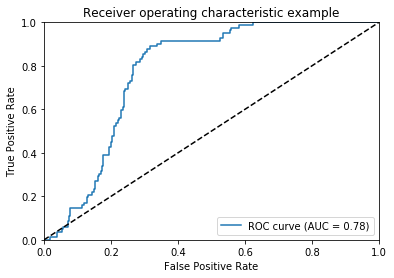

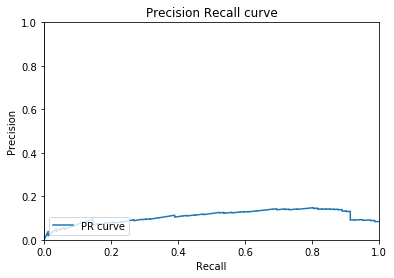

RANDOM FOREST


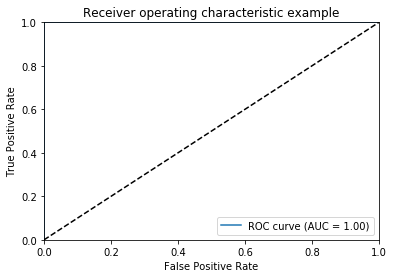

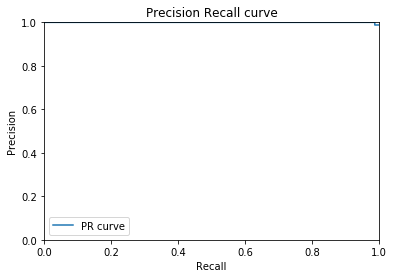

GRADIENT BOOST


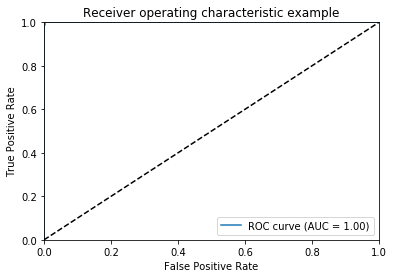

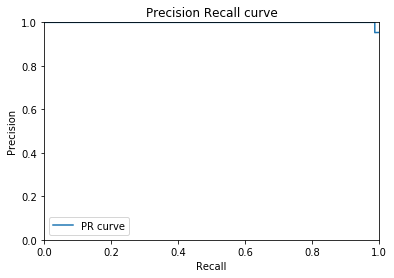

XGBOOST


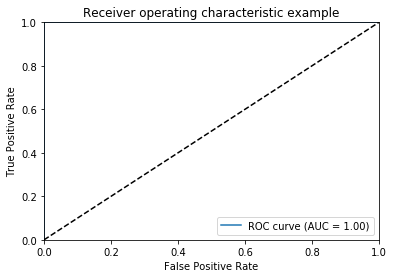

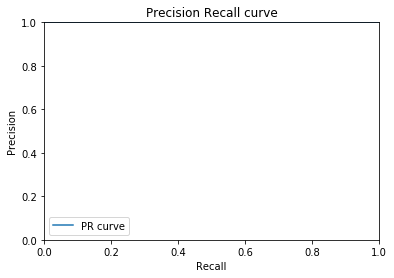

In [72]:
print("SVM")
plotMetrics(expected_train.astype('int'),SVM_predicted_probs_train[:,1])
print("RANDOM FOREST")
plotMetrics(expected_train.astype('int'),RF_predicted_probs_train[:,1])
print("GRADIENT BOOST")
plotMetrics(expected_train.astype('int'),GB_predicted_probs_train[:,1])
print("XGBOOST")
plotMetrics(expected_train.astype('int'),XGB_predicted_probs_train[:,1])


## 5.6 Test Metrics

### 5.6.1 Classification Report

In [73]:
expected_test=y_test_CV
##Predicted Results On Train
SVM_predicted_test = SVM_classifier.predict(X_test_CV)
RF_predicted_test = RF_bestClf.predict(X_test_CV)
GB_predicted_test = GB_bestClf.predict(X_test_CV)
XGB_predicted_test = XGB_bestClf.predict(X_test_CV)

print("SVM CLASSIFICATION REPORT")
print(classification_report(expected_test, SVM_predicted_test))
print("-----------------------------")

print("RANDOM FOREST CLASSIFICATION REPORT")
print(classification_report(expected_test, RF_predicted_test))
print("-----------------------------")

print("GRADIENT BOOST CLASSIFICATION REPORT")
print(classification_report(expected_test, GB_predicted_test))
print("-----------------------------")

print("XGBOOST CLASSIFICATION REPORT")
print(classification_report(expected_test, XGB_predicted_test))


SVM CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       483
         1.0       0.00      0.00      0.00        21

    accuracy                           0.96       504
   macro avg       0.48      0.50      0.49       504
weighted avg       0.92      0.96      0.94       504

-----------------------------
RANDOM FOREST CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       483
         1.0       1.00      0.19      0.32        21

    accuracy                           0.97       504
   macro avg       0.98      0.60      0.65       504
weighted avg       0.97      0.97      0.96       504

-----------------------------
GRADIENT BOOST CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       483
         1.0       0.50      0.24      0.32        21

    accuracy           

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5.6.2 Average Precision

In [74]:
SVM_predicted_probs_test = SVM_classifier.predict_proba(X_test_CV)
RF_predicted_probs_test= RF_bestClf.predict_proba(X_test_CV)
GB_predicted_probs_test= GB_bestClf.predict_proba(X_test_CV)
XGB_predicted_probs_test = XGB_bestClf.predict_proba(X_test_CV)

print("AVERAGE PRECISION SVM")
print(average_precision_score(y_test_CV.astype('int'),SVM_predicted_probs_test[:,1]))

print("AVERAGE PRECISION RANDOM FOREST")
print(average_precision_score(y_test_CV.astype('int'),RF_predicted_probs_test[:,1]))

print("AVERAGE PRECISION GRADIENT BOOST")
print(average_precision_score(y_test_CV.astype('int'),GB_predicted_probs_test[:,1]))

print("AVERAGE PRECISION XGBOOST")
print(average_precision_score(y_test_CV.astype('int'),XGB_predicted_probs_test[:,1]))


AVERAGE PRECISION SVM
0.09521050953183365
AVERAGE PRECISION RANDOM FOREST
0.587190743416843
AVERAGE PRECISION GRADIENT BOOST
0.42427125643391905
AVERAGE PRECISION XGBOOST
0.5429405857826339


### 5.6.3 AUC Graph

SVM


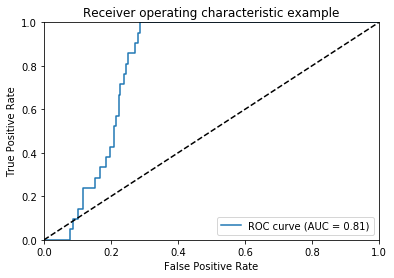

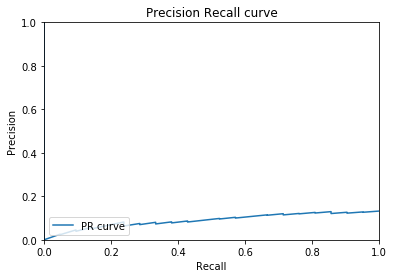

RANDOM FOREST


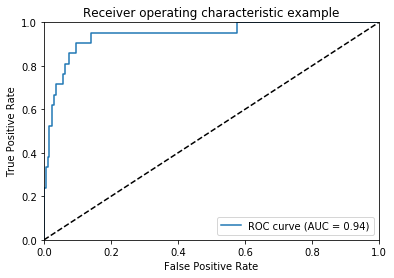

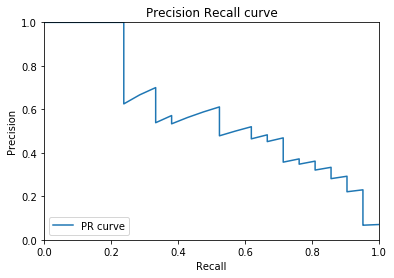

GRADIENT BOOST


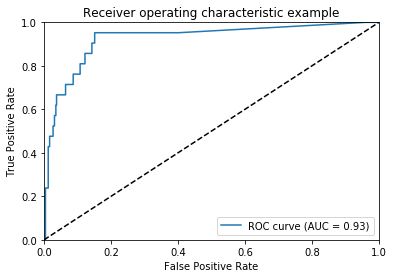

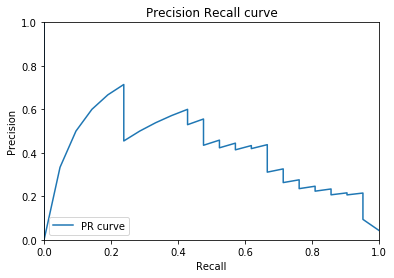

XGBOOST


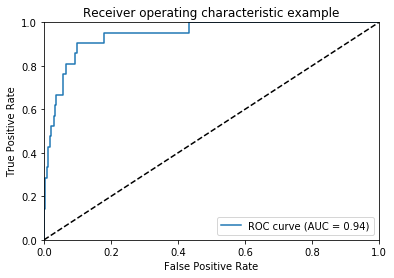

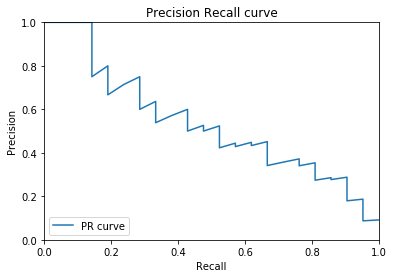

In [75]:
print("SVM")
plotMetrics(y_test_CV.astype('int'),SVM_predicted_probs_test[:,1])
print("RANDOM FOREST")
plotMetrics(y_test_CV.astype('int'),RF_predicted_probs_test[:,1])
print("GRADIENT BOOST")
plotMetrics(y_test_CV.astype('int'),GB_predicted_probs_test[:,1])
print("XGBOOST")
plotMetrics(y_test_CV.astype('int'),XGB_predicted_probs_test[:,1])


# 6.  Cross Validation

In [76]:
scoring = ['average_precision', 'roc_auc']
SVM_scores = cross_validate(SVM_classifier, X_test_CV, y_test_CV, scoring=scoring,return_train_score=True)
RF_scores = cross_validate(RF_bestClf, X_test_CV, y_test_CV, scoring=scoring,return_train_score=True)
GB_scores = cross_validate(GB_bestClf, X_test_CV, y_test_CV, scoring=scoring,return_train_score=True)
XGB_score = cross_validate(XGB_bestClf, X_test_CV, y_test_CV, scoring=scoring,return_train_score=True)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

In [77]:
print("SVM CROSS VALIDATION")
print("-------------------------------")
print("average_precision", SVM_scores['test_average_precision'].mean())
print("ROC_AUC", SVM_scores['test_roc_auc'].mean())
print("-------------------------------")

print("RANDOM FOREST CROSS VALIDATION")
print("-------------------------------")
print("average_precision", RF_scores['test_average_precision'].mean())
print("ROC_AUC", RF_scores['test_roc_auc'].mean())
print("-------------------------------")

print("GRADIENT BOOST CROSS VALIDATION")
print("-------------------------------")
print("average_precision", GB_scores['test_average_precision'].mean())
print("ROC_AUC", GB_scores['test_roc_auc'].mean())
print("-------------------------------")

print("XGBOOST CROSS VALIDATION")
print("-------------------------------")
print("average_precision", XGB_score['test_average_precision'].mean())
print("ROC_AUC", XGB_score['test_roc_auc'].mean())
print("-------------------------------")

SVM CROSS VALIDATION
-------------------------------
average_precision 0.1435029075110052
ROC_AUC 0.72588058419244
-------------------------------
RANDOM FOREST CROSS VALIDATION
-------------------------------
average_precision 0.40094818703113455
ROC_AUC 0.8822304553264605
-------------------------------
GRADIENT BOOST CROSS VALIDATION
-------------------------------
average_precision 0.2715635859711947
ROC_AUC 0.7890270618556701
-------------------------------
XGBOOST CROSS VALIDATION
-------------------------------
average_precision 0.3674290768839514
ROC_AUC 0.8636340206185565
-------------------------------


# 7. Kaggle Submissions

## 7.1 Train On All Dataset

In [78]:
SVM_classifier.fit(X_train,y_train)

RF_bestClf.fit(X_train,y_train)

GB_bestClf.fit(X_train,y_train)

XGB_bestClf.fit(X_train,y_train)




/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=22,
              min_child_weight=1, missing=None, n_estimators=180, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=1.4000000000000001, reg_lambda=1.0, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

## 7.2 Create Submission

In [0]:
## Predict Test Results
SVM_test_pred= SVM_classifier.predict_proba(X_test)
RF_test_pred= RF_bestClf.predict_proba(X_test)
GB_test_pred= GB_bestClf.predict_proba(X_test)
XGB_test_pred= XGB_bestClf.predict_proba(X_test)

## Create Series
SVM_test_pred_series = pd.Series(SVM_test_pred[:,1])
RF_test_pred_series = pd.Series(RF_test_pred[:,1])
GB_test_pred_series = pd.Series(GB_test_pred[:,1])
XGB_test_pred_series = pd.Series(XGB_test_pred[:,1])

## Add Prediction Columns
test['SVM_prediction']=SVM_test_pred_series
test['RF_prediction']=RF_test_pred_series
test['GB_prediction']=GB_test_pred_series
test['XGB_prediction']=XGB_test_pred_series



In [0]:
SVM_submission = test[['bidder_id','SVM_prediction']]
SVM_submission = SVM_submission.set_index('bidder_id')

RF_submission=test[['bidder_id','RF_prediction']]
RF_submission= RF_submission.set_index('bidder_id')

GB_submission =test[['bidder_id','GB_prediction']]
GB_submission= GB_submission.set_index('bidder_id')

XGB_submission = test[['bidder_id','XGB_prediction']]
XGB_submission=XGB_submission.set_index('bidder_id')

In [0]:
SVM_submission.to_csv('/content/Data-Science/Data/Kaggle_Submission_SVM.csv')
RF_submission.to_csv('/content/Data-Science/Data/Kaggle_Submission_RF.csv')
GB_submission.to_csv('/content/Data-Science/Data/Kaggle_Submission_GB.csv')
XGB_submission.to_csv('/content/Data-Science/Data/Kaggle_Submission_XGB.csv')

# 8. Feature Selection

In [0]:
from sklearn.feature_selection import SelectFromModel

## 8.1 Check Feature Importance

Feature importance of Random Forest Model


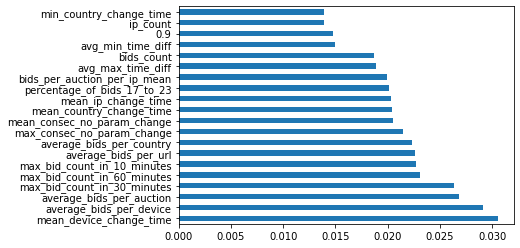

In [0]:
print('Feature importance of Random Forest Model')

feat_importances = pd.Series(RF_bestClf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')





Feature importance of Gradient Boost Model


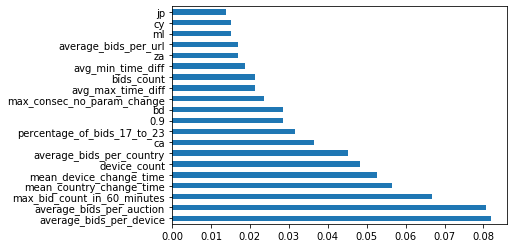

In [0]:
print('Feature importance of Gradient Boost Model')
feat_importances = pd.Series(GB_bestClf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')



Feature importance of XGBoost Model


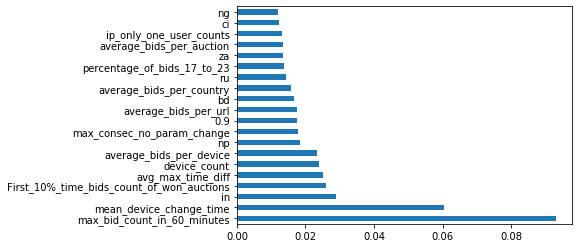

In [0]:
print('Feature importance of XGBoost Model')
feat_importances = pd.Series(XGB_bestClf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')


In [0]:
RF_seleceted_features = SelectFromModel(RF_bestClf, threshold='12*median')
RF_seleceted_features.fit(X_train_CV,y_train_CV)

GB_seleceted_features = SelectFromModel(GB_bestClf, threshold=0.0147)
GB_seleceted_features.fit(X_train_CV,y_train_CV)


XGB_seleceted_features = SelectFromModel(XGB_bestClf, threshold=0.013)
XGB_seleceted_features.fit(X_train_CV,y_train_CV)


In [0]:

embeded_rf_support = RF_seleceted_features.get_support()
embeded_rf_feature = X_train_CV.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'RF selected features')

embeded_GB_support = GB_seleceted_features.get_support()
embeded_GB_feature = X_train_CV.loc[:,embeded_GB_support].columns.tolist()
print(str(len(embeded_GB_feature)), 'GB selected features')

embeded_XGB_support = XGB_seleceted_features.get_support()
embeded_XGB_feature = X_train_CV.loc[:,embeded_XGB_support].columns.tolist()
print(str(len(embeded_XGB_feature)), 'XGB selected features')




19 RF selected features
18 GB selected features
19 XGB selected features


In [0]:
print("RF Features")
print(embeded_rf_feature)
print("GB Features")
print(embeded_GB_feature)
print("XGB Features")
print(embeded_XGB_feature)

RF Features
['device_count', 'average_bids_per_auction', 'average_bids_per_device', 'average_bids_per_url', 'average_bids_per_country', 'bids_per_auction_per_ip_mean', 'on_url_that_has_a_bot_mean', 'avg_min_time_diff', 'avg_max_time_diff', '1.0', 'max_bid_count_in_10_minutes', 'max_bid_count_in_30_minutes', 'max_bid_count_in_60_minutes', 'mean_consec_no_param_change', 'mean_device_change_time', 'mean_ip_change_time', 'min_country_change_time', 'min_device_change_time', 'percentage_of_bids_17_to_23']
GB Features
['device_count', 'ip_count', 'average_bids_per_auction', 'average_bids_per_device', 'average_bids_per_country', 'by', 'ca', 'ec', 'jp', 'last_10%_auction_time_bids', 'global_min_time_diff', '0.9', 'max_bid_count_in_10_minutes', 'max_bid_count_in_30_minutes', 'max_bid_count_in_60_minutes', 'mean_device_change_time', 'min_device_change_time', 'percentage_of_bids_17_to_23']
XGB Features
['device_count', 'average_bids_per_auction', 'on_url_that_has_a_bot_mean', 'countries_per_bidder

In [0]:
RF_X_important_train_CV = RF_seleceted_features.transform(X_train_CV)
RF_X_important_test_CV = RF_seleceted_features.transform(X_test_CV)

GB_X_important_train_CV = GB_seleceted_features.transform(X_train_CV)
GB_X_important_test_CV = GB_seleceted_features.transform(X_test_CV)

XGB_X_important_train_CV = XGB_seleceted_features.transform(X_train_CV)
XGB_X_important_test_CV = XGB_seleceted_features.transform(X_test_CV)

In [0]:
## Training RF
RF_model_important=RandomForestClassifier(random_state=42)
RF_param_grid = { 
    'n_estimators': [100,300,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7]      
}
RF_classifier_important = GridSearchCV(estimator=RF_model_important, param_grid=RF_param_grid, cv= 5,verbose=3)
RF_classifier_important.fit(RF_X_important_train_CV, y_train_CV)
RF_bestClf_important=RF_classifier_important.best_estimator_


## Training GB
GB_Model_important = GradientBoostingClassifier(random_state=42)
GB_param_grid = {
    'n_estimators': [10,25,50],
    'max_depth': range(3, 6),
    'max_leaf_nodes': range(8, 11)
}
GB_classifier_important = GridSearchCV(estimator=GB_Model_important,
                     param_grid=GB_param_grid,
                     cv=5, verbose=3)
GB_classifier_important.fit(GB_X_important_train_CV, y_train_CV)
GB_bestClf_important=GB_classifier_important.best_estimator_

## Training XGB
XGB_Model_important = xgboost.XGBClassifier()
XGB_param_grid = {
                  'max_depth': np.arange(2,50,2),
                  'learning_rate': np.arange(0.2,2,0.2),
                  'n_estimators': np.arange(20,400,20),
                  'reg_alpha': np.arange(0,2,0.2),
                  'reg_lambda': np.arange(0,2,0.2)
                 }

CV_SSS = StratifiedShuffleSplit(n_splits = 5, test_size = 0.33, random_state=None)
XGB_classifier_important = RandomizedSearchCV(XGB_Model_important, XGB_param_grid, scoring = 'roc_auc', cv = CV_SSS,
                                        n_iter = 40,verbose=3)
XGB_classifier_important.fit(XGB_X_important_train_CV,y_train_CV)
XGB_bestClf_important=XGB_classifier_important.best_estimator_


## 8.2 Classification Reports

In [0]:
expected_test = y_test_CV

RF_predicted_test_important = RF_bestClf_important.predict(RF_X_important_test_CV)
GB_predicted_test_important = GB_bestClf_important.predict(GB_X_important_test_CV)
XGB_predicted_test_important = XGB_bestClf_important.predict(XGB_X_important_test_CV)

print("RANDOM FOREST CLASSIFICATION REPORT")
print(classification_report(expected_test, RF_predicted_test_important))
print("-----------------------------")

print("GRADIENT BOOST CLASSIFICATION REPORT")
print(classification_report(expected_test, GB_predicted_test_important))
print("-----------------------------")

print("GRADIENT BOOST CLASSIFICATION REPORT")
print(classification_report(expected_test, XGB_predicted_test_important))
print("-----------------------------")

RANDOM FOREST CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       483
         1.0       0.71      0.24      0.36        21

    accuracy                           0.96       504
   macro avg       0.84      0.62      0.67       504
weighted avg       0.96      0.96      0.96       504

-----------------------------
GRADIENT BOOST CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       483
         1.0       0.62      0.24      0.34        21

    accuracy                           0.96       504
   macro avg       0.80      0.62      0.66       504
weighted avg       0.95      0.96      0.95       504

-----------------------------
GRADIENT BOOST CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       483
         1.0       0.50      0.24      0.32        21

    accuracy

## 8.3 Average Precision

In [0]:
RF_predicted_probs_test_important= RF_bestClf_important.predict_proba(RF_X_important_test_CV)
GB_predicted_probs_test_important = GB_bestClf_important.predict_proba(GB_X_important_test_CV)
XGB_predicted_probs_test_important = XGB_bestClf_important.predict_proba(XGB_X_important_test_CV)


print("AVERAGE PRECISION RANDOM FOREST")
print(average_precision_score(y_test_CV.astype('int'),RF_predicted_probs_test_important[:,1]))


print("AVERAGE PRECISION GRADIENT BOOST")
print(average_precision_score(y_test_CV.astype('int'),GB_predicted_probs_test_important[:,1]))


print("AVERAGE PRECISION XGBOOST")
print(average_precision_score(y_test_CV.astype('int'),XGB_predicted_probs_test_important[:,1]))

AVERAGE PRECISION RANDOM FOREST
0.5219059896803723
AVERAGE PRECISION GRADIENT BOOST
0.4915461542368314
AVERAGE PRECISION XGBOOST
0.4199123074091863


RF Graph


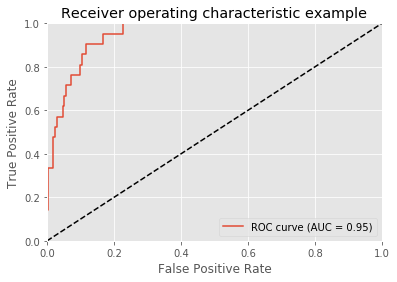

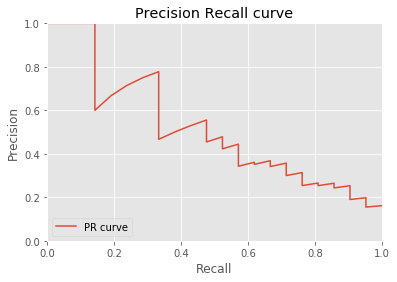

GB Graph


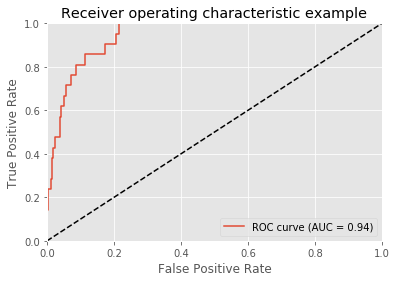

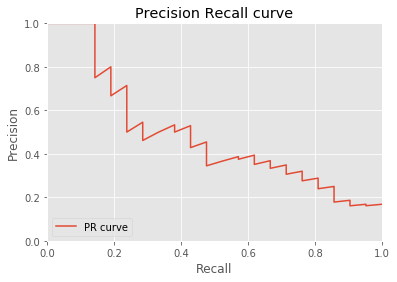

XGB Graph


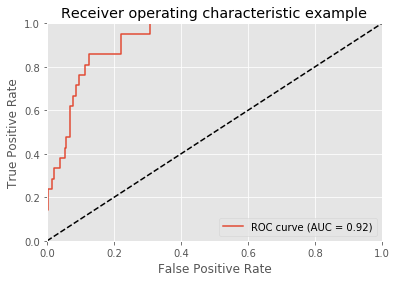

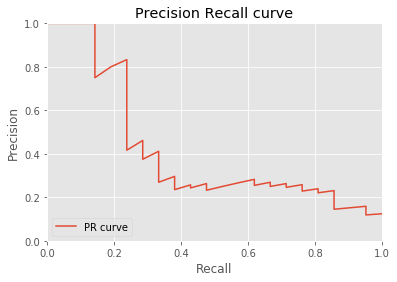

In [0]:
print("RF Graph")
plotMetrics(y_test_CV.astype('int'),RF_predicted_probs_test_important[:,1])

print("GB Graph")
plotMetrics(y_test_CV.astype('int'),GB_predicted_probs_test_important[:,1])


print("XGB Graph")
plotMetrics(y_test_CV.astype('int'),XGB_predicted_probs_test_important[:,1])

## 8.4 Cross Validation

In [0]:
scoring = ['average_precision', 'roc_auc']
RF_scores = cross_validate(RF_bestClf_important, RF_X_important_test_CV, y_test_CV, scoring=scoring,return_train_score=True)
GB_scores = cross_validate(GB_bestClf_important, GB_X_important_test_CV, y_test_CV, scoring=scoring,return_train_score=True)
XGB_score = cross_validate(XGB_bestClf_important,XGB_X_important_test_CV, y_test_CV, scoring=scoring,return_train_score=True)

In [0]:

print("RANDOM FOREST CROSS VALIDATION")
print("-------------------------------")
print("average_precision", RF_scores['test_average_precision'].mean())
print("ROC_AUC", RF_scores['test_roc_auc'].mean())
print("-------------------------------")

print("GRADIENT BOOST CROSS VALIDATION")
print("-------------------------------")
print("average_precision", GB_scores['test_average_precision'].mean())
print("ROC_AUC", GB_scores['test_roc_auc'].mean())
print("-------------------------------")

print("XGBOOST CROSS VALIDATION")
print("-------------------------------")
print("average_precision", XGB_score['test_average_precision'].mean())
print("ROC_AUC", XGB_score['test_roc_auc'].mean())
print("-------------------------------")

RANDOM FOREST CROSS VALIDATION
-------------------------------
average_precision 0.4742068454850963
ROC_AUC 0.9170672250859105
-------------------------------
GRADIENT BOOST CROSS VALIDATION
-------------------------------
average_precision 0.40910780864489305
ROC_AUC 0.8973850945017181
-------------------------------
XGBOOST CROSS VALIDATION
-------------------------------
average_precision 0.417330591368704
ROC_AUC 0.903827319587629
-------------------------------


# 9. Models Error Analysis

In [0]:
!pip install shap

In [93]:
from imblearn.over_sampling import RandomOverSampler as ROS
from imblearn.over_sampling import SMOTE
import shap
from sklearn.neighbors import NearestNeighbors

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


ModuleNotFoundError: ignored

## 9.1 Training Best Models

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X_train, y_train, random_state=4)

In [0]:
#number of bots in x_test, around 5% - same ratio as in x_train
sum(y_test)

20.0

In [0]:
xgb_model = xgboost.XGBClassifier(objective="binary:logistic", n_estimators=50, random_state=42, eval_metric=["auc", "error", "error@0.6"])
rf = RandomForestClassifier(n_estimators=800, max_depth=8, max_features='auto', class_weight={1.0:20, 0:1})


In [0]:
rfc = RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [300,500,800],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10,20],
    'criterion': ['entropy'],
    'class_weight': [{1.0:20, 0.0:1}, {1.0:40, 0.0:1}] 
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,verbose=10)
CV_rfc.fit(x_train, y_train)

In [0]:
bestClf = CV_rfc.best_estimator_
bestClf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0.0: 1, 1.0: 20}, criterion='entropy',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [0]:
xgbc = xgboost.XGBClassifier(random_state=16)
param_grid = {
    'n_estimators': [100,300,500,800],
    'eval_metric': ["auc", "error", "error@0.6"],
    'max_depth' : [5, 10, 30, 100],
    'scale_pos_weight' : [0.1, 10, 20, 40]
}
xgbc_CV = GridSearchCV(estimator=xgbc, param_grid=param_grid, cv= 5,verbose=10)
xgbc_CV.fit(x_train, y_train)

In [0]:
best_xgb = xgbc_CV.best_estimator_
best_xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=16,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
#lets try to predict probabilities
xgb_prob_pred = best_xgb.predict_proba(x_test)[:,1]
rf_prob_pred = bestClf.predict_proba(x_test)[:,1]

#models average precision score on test
print('xgb: ' + str(average_precision_score(y_test, xgb_prob_pred)))
print('RF: ' + str(average_precision_score(y_test, rf_prob_pred)))

xgb: 0.6192899148208545
RF: 0.5908263973512405


## 9.2 Observing Prediction Errors

In [0]:
#predict classification
xgb_pred = best_xgb.predict(x_test)
rf_pred = bestClf.predict(x_test)


In [0]:
#take a look at the bidders that xgb failed to classify right
wrong_xgb = x_test[xgb_pred != y_test]
wrong_xgb.head()

,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,...,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,Unnamed: 0_y,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11
74,True,0,0,0,0,252,46,1,14,9,112,2,5.478261,18.000000,126.000000,28.000000,1.508982,0.160000,1,0.651786,1,1.000000,1,1.0,1,0.500000,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.600000,0.000000,0.000000,...,1,34.0,13.0,0.051587,3.994453e+11,2.147692e+12,105263158.0,1.952737e+12,13.0,9.0,8.0,5.0,34.0,35.0,35.0,36.0,43.0,33.0,1.0,2.0,0.0,3.0,0.0,0.0,1972,9.0,14.0,25.0,2.0,1.285714,2124.0,1267.0,990.0,7.0,2.0,4.0,46.031746,7.142857,5.555556,41.269841
77,False,1,0,1,0,643,101,1,155,20,278,147,6.366337,4.148387,4.374150,32.150000,1.603491,0.144947,1,0.564748,1,0.967742,1,1.0,1,0.027211,1.0,1.118812,13.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.004938,...,1,69.0,75.0,0.116641,1.625118e+12,4.010034e+12,0.0,2.255789e+11,75.0,56.0,52.0,89.0,39.0,62.0,80.0,64.0,57.0,68.0,1.0,0.0,0.0,4.0,0.0,1.0,1807,7.0,18.0,30.0,4.0,1.363636,736.0,455.0,441.0,2.0,0.0,0.0,21.461897,35.925350,18.662519,23.950233
101,False,0,0,0,1,2244,509,1,376,72,1159,325,4.408644,5.968085,6.904615,31.166667,1.273553,0.228336,1,0.408973,1,0.984043,1,1.0,1,0.003077,1.0,1.231827,22.0,0.0,0.0,0.0,0.0,0.0,0.006349,0.0,0.0,0.126984,0.003175,0.088889,...,4,512.0,614.0,0.273619,5.218381e+12,2.338693e+13,0.0,5.004516e+13,614.0,506.0,51.0,36.0,43.0,32.0,26.0,50.0,374.0,507.0,5.0,0.0,1.0,7.0,0.0,1.0,177,20.0,32.0,48.0,6.0,1.257862,463.0,423.0,415.0,0.0,0.0,0.0,16.354724,31.461676,31.283422,20.900178
5,False,1,0,0,1,6127,332,1,195,8,3047,58,18.454819,31.420513,105.637931,765.875000,1.340407,0.307605,1,0.114539,1,0.953846,1,1.0,1,0.017241,1.0,1.003012,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,28,1832.0,1677.0,0.273707,2.013468e+12,1.912977e+13,0.0,5.002500e+13,1677.0,1341.0,120.0,81.0,66.0,70.0,134.0,90.0,716.0,1804.0,28.0,75.0,168.0,549.0,25.0,81.0,1200,79.0,176.0,281.0,2.0,1.048193,521.0,166.0,145.0,0.0,0.0,0.0,29.019096,35.727110,10.200751,25.053044
95,False,0,1,1,0,798,85,1,192,23,442,446,9.388235,4.156250,1.789238,34.695652,1.141631,0.185714,1,0.518100,1,0.989583,1,1.0,1,0.011211,1.0,1.717647,8.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.005008,...,0,2.0,512.0,0.641604,9.686922e+11,2.806913e+12,0.0,2.514737e+11,512.0,262.0,4.0,3.0,9.0,1.0,1.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,936,12.0,22.0,40.0,2.0,1.021277,816.0,364.0,345.0,4.0,0.0,0.0,17.543860,41.604010,16.791980,24.060150


In [0]:
wrong_rf =x_test[rf_pred != y_test]
wrong_rf.head()

,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,...,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,Unnamed: 0_y,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11
1089,False,1,0,0,0,279,6,1,1,1,276,5,46.500000,279.000000,55.800000,279.000000,1.003597,0.489011,1,0.032609,1,1.000000,1,1.0,0,0.000000,1.0,1.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,2,110.0,0.0,0.000000,8.771930e+07,1.200728e+12,0.0,1.199684e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,169.0,108.0,2.0,0.0,24.0,65.0,0.0,24.0,172,169.0,169.0,169.0,0.0,0.000000,15322.0,11968.0,84.0,319.5,128.0,0.0,39.426523,0.000000,0.000000,60.573477
240,False,0,1,0,1,2073,111,1,255,21,1100,229,18.675676,8.129412,9.052402,98.714286,1.195502,0.238148,1,0.290000,1,0.972549,1,1.0,1,0.004367,1.0,1.369369,7.0,0.0,0.001162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,3,232.0,268.0,0.129281,7.901484e+11,2.714936e+12,0.0,9.536842e+10,268.0,169.0,188.0,365.0,119.0,178.0,237.0,175.0,142.0,229.0,3.0,0.0,2.0,5.0,0.0,2.0,1115,22.0,51.0,79.0,3.0,1.118644,446.0,131.0,129.0,1.0,0.0,0.0,20.019296,45.682586,14.182344,20.115774
74,True,0,0,0,0,252,46,1,14,9,112,2,5.478261,18.000000,126.000000,28.000000,1.508982,0.160000,1,0.651786,1,1.000000,1,1.0,1,0.500000,1.0,1.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.000000,...,1,34.0,13.0,0.051587,3.994453e+11,2.147692e+12,105263158.0,1.952737e+12,13.0,9.0,8.0,5.0,34.0,35.0,35.0,36.0,43.0,33.0,1.0,2.0,0.0,3.0,0.0,0.0,1972,9.0,14.0,25.0,2.0,1.285714,2124.0,1267.0,990.0,7.0,2.0,4.0,46.031746,7.142857,5.555556,41.269841
1459,False,0,0,0,0,1260,12,1,128,7,241,573,105.000000,9.843750,2.198953,180.000000,3.433243,0.094828,1,0.414938,1,0.960938,1,1.0,1,0.054101,1.0,1.833333,5.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,69.0,189.0,0.150000,2.604737e+11,3.236923e+12,0.0,2.917368e+11,189.0,91.0,202.0,126.0,155.0,135.0,179.0,95.0,19.0,69.0,0.0,0.0,0.0,0.0,0.0,0.0,1493,16.0,34.0,60.0,1.0,1.000000,694.0,246.0,211.0,1.0,1.0,0.0,28.888889,23.253968,30.793651,17.063492
77,False,1,0,1,0,643,101,1,155,20,278,147,6.366337,4.148387,4.374150,32.150000,1.603491,0.144947,1,0.564748,1,0.967742,1,1.0,1,0.027211,1.0,1.118812,13.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004938,...,1,69.0,75.0,0.116641,1.625118e+12,4.010034e+12,0.0,2.255789e+11,75.0,56.0,52.0,89.0,39.0,62.0,80.0,64.0,57.0,68.0,1.0,0.0,0.0,4.0,0.0,1.0,1807,7.0,18.0,30.0,4.0,1.363636,736.0,455.0,441.0,2.0,0.0,0.0,21.461897,35.925350,18.662519,23.950233


In [0]:
print(sum(y_test))
print(y_test[ xgb_pred != y_test])

20.0
74      1.0
77      1.0
101     1.0
5       1.0
95      1.0
14      1.0
25      1.0
94      1.0
47      1.0
28      1.0
1240    0.0
35      1.0
15      1.0
56      1.0
67      1.0
Name: outcome, dtype: float64


## 9.3 Comparing Missed Bidders To Bots & Humans

In [0]:
x_train['outcome'] = y_train


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
x_train.head()

,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,...,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,Unnamed: 0_y,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11,outcome
144,False,0,1,0,1,45,19,1,2,3,5,25,2.368421,22.500000,1.800000,15.000000,1.666667,0.000000,1,1.000000,1,1.000000,1,1.0,1,0.040000,1.0,1.210526,2.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,...,1.0,16.0,0.355556,8.243749e+12,1.509794e+13,2.105263e+08,5.223016e+13,16.0,24.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1551,7.0,16.0,18.0,5.0,2.000000,10013.0,13768.0,9578.0,4.0,7.0,4.0,0.000000,33.333333,53.333333,13.333333,0.0
1670,False,0,1,0,1,764,185,1,201,46,636,14,4.129730,3.800995,54.571429,16.608696,1.147147,0.261122,1,0.336478,1,0.985075,1,1.0,1,0.071429,1.0,1.124324,21.0,0.0,0.100251,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,...,183.0,270.0,0.353403,1.198278e+13,2.567284e+13,0.000000e+00,5.003011e+13,270.0,138.0,11.0,5.0,10.0,8.0,3.0,2.0,134.0,183.0,0.0,0.0,0.0,0.0,0.0,0.0,1650,11.0,17.0,22.0,3.0,1.333333,1709.0,1208.0,1182.0,3.0,0.0,0.0,21.596859,42.015707,16.361257,20.026178,0.0
1787,False,0,1,0,1,18,18,1,14,9,16,10,1.000000,1.285714,1.800000,2.000000,1.000000,0.307692,1,0.437500,1,0.928571,1,1.0,1,0.100000,1.0,1.000000,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,...,0.0,10.0,0.555556,1.598882e+12,4.422000e+12,1.163158e+10,3.940789e+12,10.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1446,2.0,2.0,3.0,1.0,1.000000,18128.0,16920.0,15862.0,506.0,506.0,506.0,33.333333,44.444444,11.111111,11.111111,0.0
853,False,1,0,0,0,836,261,1,206,47,610,257,3.203065,4.058252,3.252918,17.787234,1.140518,0.323625,1,0.259016,1,0.990291,1,1.0,1,0.003891,1.0,1.095785,7.0,0.0,0.010471,0.0,0.0,0.001745,0.0,0.0,0.0,0.00349,0.001745,0.019197,...,194.0,229.0,0.273923,2.725095e+12,2.123531e+13,5.263158e+07,5.009853e+13,229.0,149.0,27.0,19.0,17.0,19.0,27.0,8.0,147.0,193.0,1.0,0.0,0.0,1.0,0.0,0.0,83,11.0,17.0,23.0,7.0,1.382979,2296.0,1223.0,1165.0,1.0,1.0,1.0,24.401914,37.320574,16.028708,22.248804,0.0
1468,False,0,1,0,0,1,1,1,1,1,1,1,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1,1.000000,1,1.000000,1,1.0,1,1.000000,1.0,1.000000,1.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,...,0.0,1.0,1.000000,1.598882e+12,4.422000e+12,7.894737e+08,5.696500e+12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1968,1.0,1.0,1.0,0.0,0.000000,15322.0,11968.0,11621.0,319.5,128.0,92.0,0.000000,100.000000,0.000000,0.000000,0.0


In [0]:
humans = x_train[x_train['outcome'] == 0]
humans.describe()

,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,aw,...,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,Unnamed: 0_y,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11,outcome
count,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1.426000e+03,1426.000000,1426.000000,1426.0,1426.000000,1426.000000,1426.000000,1426.000000,1426.0,...,1426.000000,1426.000000,1426.000000,1.426000e+03,1.426000e+03,1.426000e+03,1.426000e+03,1426.000000,1426.00000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.0
mean,0.103787,0.666199,0.082048,0.384292,1453.464937,56.981066,0.985273,72.961431,12.500701,577.523843,343.213184,6.396314,11.470505,15.225020,39.788606,1.480869,0.227218,0.810659,0.409464,0.981767,0.967084,0.983871,0.983670,0.793128,0.249502,1.049790,1.157158,4.403226,0.000012,0.023850,0.000815,8.949238e-08,0.001052,0.000145,0.0,0.000650,0.014326,0.000737,0.013355,0.0,...,330.489481,381.867461,0.230493,3.226696e+12,9.473721e+12,1.148266e+12,2.188464e+13,381.867461,276.34993,61.269285,39.380785,47.760870,52.147265,49.269285,32.638149,182.292426,328.016830,2.472651,107.556802,113.836606,442.366059,39.283310,48.380084,1003.814165,14.308555,29.676718,49.502805,8.542076,4.082801,21045.204067,19233.068022,19164.190743,6803.764025,7041.295933,6461.335905,25.011549,35.948375,16.434878,21.062421,0.0
std,0.305091,0.471735,0.274534,0.486598,16322.017781,138.905139,0.126188,183.830228,22.610889,4496.979389,2986.006218,33.284632,138.699914,142.616327,244.787695,6.214274,0.171006,0.391917,0.332285,0.133839,0.138519,0.126016,0.126005,0.405205,0.350616,0.798228,0.796810,9.523715,0.000334,0.111201,0.008314,3.379448e-06,0.013585,0.001832,0.0,0.010373,0.101274,0.008009,0.091231,0.0,...,3790.195083,5079.067525,0.257387,7.114408e+12,1.252550e+13,7.134891e+12,2.440955e+13,5079.067525,4321.57989,669.796416,327.430704,607.241477,547.137548,484.587224,314.900402,1825.618662,3774.651261,20.637038,2751.744861,2137.298669,9047.982991,871.158051,970.611635,586.672112,93.689484,213.074276,403.817686,137.046587,68.447563,20329.292

In [0]:
bots = x_train[x_train['outcome'] == 1]
bots.describe()

,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,aw,...,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,Unnamed: 0_y,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11,outcome
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.0,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.0,83.000000,83.0,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,8.300000e+01,83.000000,83.000000,83.000000,83.000000,83.000000,...,83.000000,83.000000,83.000000,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.00000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.0
mean,0.108434,0.650602,0.072289,0.397590,4380.831325,141.156627,1.0,164.012048,26.325301,2619.349398,576.951807,25.656081,118.207644,131.813236,192.465683,8.964845,0.270827,0.891566,0.306775,1.0,0.963081,1.0,0.997947,0.831325,0.172845,1.036145,1.229939,9.433735,0.000001,0.008286,0.000801,0.000002,0.000882,0.000107,2.681249e-07,0.000198,0.020781,0.003733,0.137420,0.000002,...,1173.626506,815.373494,0.178572,9.778464e+11,6.546488e+12,9.067850e+07,1.515305e+13,815.373494,613.734940,198.156627,172.024096,223.481928,221.554217,156.385542,147.469880,659.024096,1165.228916,8.39759,355.590361,599.301205,1844.662651,162.746988,194.493976,949.867470,51.397590,104.228916,170.457831,82.927711,37.836597,6778.313253,3669.204819,3093.385542,2185.337349,989.975904,1095.915663,26.452324,28.479048,19.082805,25.985822,1.0
std,0.312818,0.479678,0.260540,0.492375,18149.009363,201.009676,0.0,235.164265,32.928270,12500.878090,1258.442920,47.383955,345.470881,338.792118,403.373849,28.310689,0.165706,0.312818,0.289332,0.0,0.065949,0.0,0.016751,0.376741,0.295527,0.329293,0.412965,20.362084,0.000010,0.039719,0.005319,0.000015,0.005341,0.000705,2.442734e-06,0.001192,0.098137,0.017382,0.308406,0.000017,...,6406.526809,3283.046606,0.194907,1.400373e+12,7.992162e+12,3.910451e+08,2.243681e+13,3283.046606,2691.352729,442.651779,503.430960,783.813386,573.844188,389.357001,414.590404,3383.599995,6383.880453,27.01352,2601.811583,4315.391305,12609.005251,1149.314004,1301.320721,556.995726,65.415173,154.974847,293.174230,313.265016,154.961783,14219.466687,10604.325044,9381.916647,10197.997006,6245.694468,7975.911448,20.255145,22.554849,18.277652,20.641252,0.0
min,0.000000,0.000000,0.000000,

In [0]:
bots_mean = bots.describe().loc['mean']
human_mean = humans.describe().loc['mean']
names = x_train.columns

## 9.4 SHAP & Important Features 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


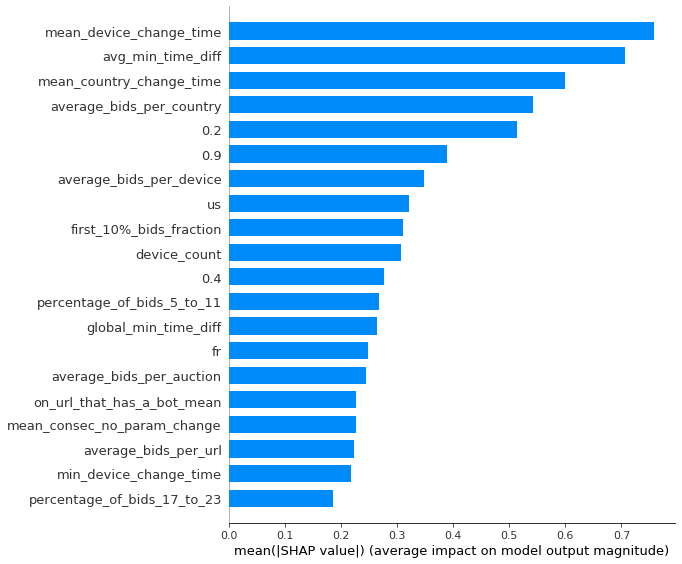

In [0]:
#SHAP
x_train.drop('outcome', axis=1, inplace=True)
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type='bar')

In [0]:
def shap_plot(S,model,j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [0]:
shap.initjs()
S = x_test[y_test != wrong_xgb]
shap_plot(S, best_xgb, 0)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [0]:
#kernelExplainer
rf_shap_values = shap.KernelExplainer(bestClf.predict ,wrong_rf)

In [0]:
wrong_rf.astype('float64')

,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,...,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,Unnamed: 0_y,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11
1089,0.0,1.0,0.0,0.0,0.0,279.0,6.0,1.0,1.0,1.0,276.0,5.0,46.500000,279.000000,55.800000,279.000000,1.003597,0.489011,1.0,0.032609,1.0,1.000000,1.0,1.0,0.0,0.000000,1.0,1.000000,1.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,2.0,110.0,0.0,0.000000,8.771930e+07,1.200728e+12,0.0,1.199684e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,169.0,108.0,2.0,0.0,24.0,65.0,0.0,24.0,172.0,169.0,169.0,169.0,0.0,0.000000,15322.0,11968.0,84.0,319.5,128.0,0.0,39.426523,0.000000,0.000000,60.573477
240,0.0,0.0,1.0,0.0,1.0,2073.0,111.0,1.0,255.0,21.0,1100.0,229.0,18.675676,8.129412,9.052402,98.714286,1.195502,0.238148,1.0,0.290000,1.0,0.972549,1.0,1.0,1.0,0.004367,1.0,1.369369,7.0,0.0,0.001162,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,3.0,232.0,268.0,0.129281,7.901484e+11,2.714936e+12,0.0,9.536842e+10,268.0,169.0,188.0,365.0,119.0,178.0,237.0,175.0,142.0,229.0,3.0,0.0,2.0,5.0,0.0,2.0,1115.0,22.0,51.0,79.0,3.0,1.118644,446.0,131.0,129.0,1.0,0.0,0.0,20.019296,45.682586,14.182344,20.115774
74,1.0,0.0,0.0,0.0,0.0,252.0,46.0,1.0,14.0,9.0,112.0,2.0,5.478261,18.000000,126.000000,28.000000,1.508982,0.160000,1.0,0.651786,1.0,1.000000,1.0,1.0,1.0,0.500000,1.0,1.000000,1.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.600000,0.000000,0.000000,...,1.0,34.0,13.0,0.051587,3.994453e+11,2.147692e+12,105263158.0,1.952737e+12,13.0,9.0,8.0,5.0,34.0,35.0,35.0,36.0,43.0,33.0,1.0,2.0,0.0,3.0,0.0,0.0,1972.0,9.0,14.0,25.0,2.0,1.285714,2124.0,1267.0,990.0,7.0,2.0,4.0,46.031746,7.142857,5.555556,41.269841
1459,0.0,0.0,0.0,0.0,0.0,1260.0,12.0,1.0,128.0,7.0,241.0,573.0,105.000000,9.843750,2.198953,180.000000,3.433243,0.094828,1.0,0.414938,1.0,0.960938,1.0,1.0,1.0,0.054101,1.0,1.833333,5.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,69.0,189.0,0.150000,2.604737e+11,3.236923e+12,0.0,2.917368e+11,189.0,91.0,202.0,126.0,155.0,135.0,179.0,95.0,19.0,69.0,0.0,0.0,0.0,0.0,0.0,0.0,1493.0,16.0,34.0,60.0,1.0,1.000000,694.0,246.0,211.0,1.0,1.0,0.0,28.888889,23.253968,30.793651,17.063492
77,0.0,1.0,0.0,1.0,0.0,643.0,101.0,1.0,155.0,20.0,278.0,147.0,6.366337,4.148387,4.374150,32.150000,1.603491,0.144947,1.0,0.564748,1.0,0.967742,1.0,1.0,1.0,0.027211,1.0,1.118812,13.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.004938,...,1.0,69.0,75.0,0.116641,1.625118e+12,4.010034e+12,0.0,2.255789e+11,75.0,56.0,52.0,89.0,39.0,62.0,80.0,64.0,57.0,68.0,1.0,0.0,0.0,4.0,0.0,

In [0]:
#shap.summary_plot(rf_shap_values.shap_values(wrong_rf.astype('float64')), wrong_rf.astype('float64'))

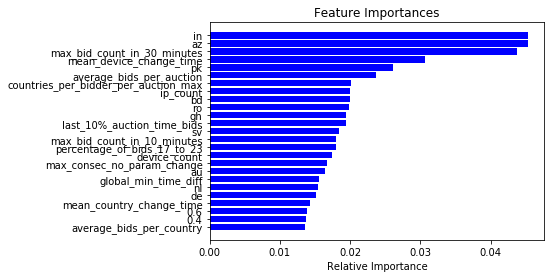

In [0]:
importances = best_xgb.feature_importances_
indices = np.argsort(importances)
features = x_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices[len(indices)-25:len(indices)])), importances[indices[len(indices)-25:len(indices)]], color='b', align='center')
plt.yticks(range(len(indices[len(indices)-25:len(indices)])), [features[i] for i in indices[len(indices)-25:len(indices)]])
plt.xlabel('Relative Importance')
plt.show()

In [0]:
important_features = features[indices[len(indices)-50:len(indices)]]

In [0]:
values = importances[indices[len(indices)-50:len(indices)]]
sum(values)

0.8011436453089118

In [0]:
xgb_error_features = (x_test[xgb_pred != y_test])[important_features]
xgb_error_features

,0.2,th,np,on_ip_that_has_a_bot_mean,eg,0.3,first_10%_bids_fraction,ng,iq,avg_min_time_diff,cn,average_bids_per_device,ip_only_one_user_counts,0.7,auction_count,za,min_country_change_time,ke,sa,mx,it,gr,max_bid_count_in_60_minutes,min_ip_change_time,eu,average_bids_per_country,0.4,0.6,mean_country_change_time,de,nl,global_min_time_diff,au,max_consec_no_param_change,device_count,percentage_of_bids_17_to_23,max_bid_count_in_10_minutes,sv,last_10%_auction_time_bids,gh,ro,bd,ip_count,countries_per_bidder_per_auction_max,average_bids_per_auction,pk,mean_device_change_time,max_bid_count_in_30_minutes,az,in
74,9.0,0.072000,0.000000,0.651786,0.000000,8.0,0.051587,0.008000,0.000000,3.994453e+11,0.000000,18.000000,0.160000,35.0,46,1.000000,7.0,0.000000,0.000000,0.000000,0.000000,0.000000,25.0,4.0,0.000000,28.000000,5.0,35.0,2124.0,0.000000,0.000000,105263158.0,0.000000,2.0,14,7.142857,9.0,0.000000,34.0,0.000000,0.000000,0.000000,112,1.0,5.478261,0.000000,1267.0,14.0,0.000000,0.128000
77,56.0,0.004938,0.000000,0.564748,0.000000,52.0,0.116641,0.000000,0.000000,1.625118e+12,0.002469,4.148387,0.144947,80.0,101,0.000000,2.0,0.000000,0.002469,0.000000,0.000000,0.000000,30.0,0.0,0.002469,32.150000,89.0,62.0,736.0,0.000000,0.000000,0.0,0.004938,4.0,155,35.925350,7.0,0.000000,69.0,0.000000,0.000000,0.000000,278,13.0,6.366337,0.000000,455.0,18.0,0.000000,0.123457
101,506.0,0.133333,0.003175,0.408973,0.000000,51.0,0.273619,0.041270,0.006349,5.218381e+12,0.000000,5.968085,0.228336,26.0,509,0.955556,0.0,0.085714,0.000000,0.101587,0.149206,0.031746,48.0,0.0,0.012698,31.166667,36.0,32.0,463.0,0.041270,0.022222,0.0,0.088889,6.0,376,31.461676,20.0,0.003175,512.0,0.015873,0.114286,0.000000,1159,22.0,4.408644,0.003175,423.0,32.0,0.041270,0.247619
5,1341.0,1.000000,0.000000,0.114539,0.000000,120.0,0.273707,0.000000,0.000000,2.013468e+12,0.000000,31.420513,0.307605,134.0,332,0.056582,0.0,0.000000,0.000000,0.314550,0.000000,0.000000,281.0,0.0,0.000000,765.875000,81.0,70.0,521.0,0.000000,0.000000,0.0,0.000000,2.0,195,35.727110,79.0,0.000000,1832.0,0.000000,0.000000,0.000000,3047,2.0,18.454819,0.000000,166.0,176.0,0.000000,0.000000
95,262.0,0.006678,0.000000,0.518100,0.003339,4.0,0.641604,0.001669,0.000000,9.686922e+11,0.036728,4.156250,0.185714,1.0,85,0.000000,4.0,0.000000,0.013356,0.000000,0.000000,0.000000,40.0,0.0,0.000000,34.695652,3.0,1.0,816.0,0.000000,0.000000,0.0,0.005008,2.0,192,41.604010,12.0,0.000000,2.0,0.000000,0.000000,0.000000,442,8.0,9.388235,0.003339,364.0,22.0,0.000000,0.003339
14,301.0,0.007345,0.000000,0.300921,0.001049,52.0,0.199219,0.001049,0.000000,1.299726e+12,0.001049,5.203252,0.286511,20.0,183,0.004197,0.0,0.001049,0.004197,0.002099,0.001049,0.000000,45.0,0.0,0.000000,28.444444,49.0,36.0,1689.0,0.001049,0.000000,0.0,0.002099,3.0,246,36.562500,14.0,0.000000,276.0,0.001049,0.001049,0.009444,977,18.0,6.994536,0.008395,725.0,27.0,0.001049,1.000000
25,0.0,0.000000,0.000000,0.024570,0.000000,249.0,0.025547,0.000000,0.000000,2.807966e+09,0.000000,205.500000,0.489758,137.0,38,1.000000,1663.0,0.000000,0.000000,0.000000,0.000000,0.000000,289.0,0.0,0.000000,411.000000,11.0,262.0,23743.0,0.000000,0.000000,0.0,0.000000,0.0,4,0.000000,142.0,0.000000,25.0,0.000000,0.000000,0.000000,814,1.0,21.631579,0.000000,221.0,235.0,0.000000,0.000000
94,431.0,0.208388,0.000000,0.806122,0.138270,269.0,0.118129,0.001311,0.001311,3.290326e+11,0.011140,18.306250,0.026587,666.0,169,0.019659,0.0,0.000000,0.008519,0.000000,0.001311,0.003932,652.0,0.0,0.000000,71.439024,53.0,102.0,206.0,0.000655,0.006553,0.0,0.000000,9.0,160,2.116763,160.0,0.000000,56.0,0.000000,0.000000,0.001311,490,21.0,17.331361,0.006553,149.0,390.0,0.000000,0.104194
47,2118.0,0.001954,0.000000,0.114780,0.000000,541.0,0.269839,0.001543,0.000000,2.690242e+12,0.003703,20.583578,0.359376,347.0,678,0.016046,0.0,0.014400,0.005143,0.009154,0.009669,0.000000,300.0,0.0,0.004732,280.760000,309.0,461.0,134.0,0.000206,0.000103,0.0,0.010183,10.0,682,37.391366,77.0,0.000000,3290.0,0.000000,0.000103,0.000000,9662

In [0]:
bots_mean

address_infrequent_address               0.108434
address_rare_address                     0.650602
payment_account_infrequent_account       0.072289
payment_account_rare_account             0.397590
bids_count                            4380.831325
                                         ...     
percentage_of_bids_11_to_17             26.452324
percentage_of_bids_17_to_23             28.479048
percentage_of_bids_23_to_5              19.082805
percentage_of_bids_5_to_11              25.985822
outcome                                  1.000000
Name: mean, Length: 264, dtype: float64

In [0]:
important_bots_mean = bots_mean[important_features]
important_humans_mean = human_mean[important_features]

In [0]:
#histogram of bots vs humans
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        

def plot_histogram(names, bots_vals, humans_vals):
  x = np.arange(len(names))
  width = 0.8
  fig , ax = plt.subplots()
  rects1 = ax.barh(x - width/2, bots_vals.values.tolist(), width, label='Bots', align='center')
  rects2 = ax.barh(x + width/2, humans_vals.values.tolist(), width, label='Humans', align='center')
  fig.set_size_inches(15, 10)
  
  ax.set_ylabel('Scores')
  ax.set_title('Scores by group')
  ax.set_yticks(x)
  ax.set_yticklabels(names)
  ax.legend()



  autolabel(rects1, ax)
  autolabel(rects2, ax)
  fig.tight_layout()
  plt.show()
  return fig


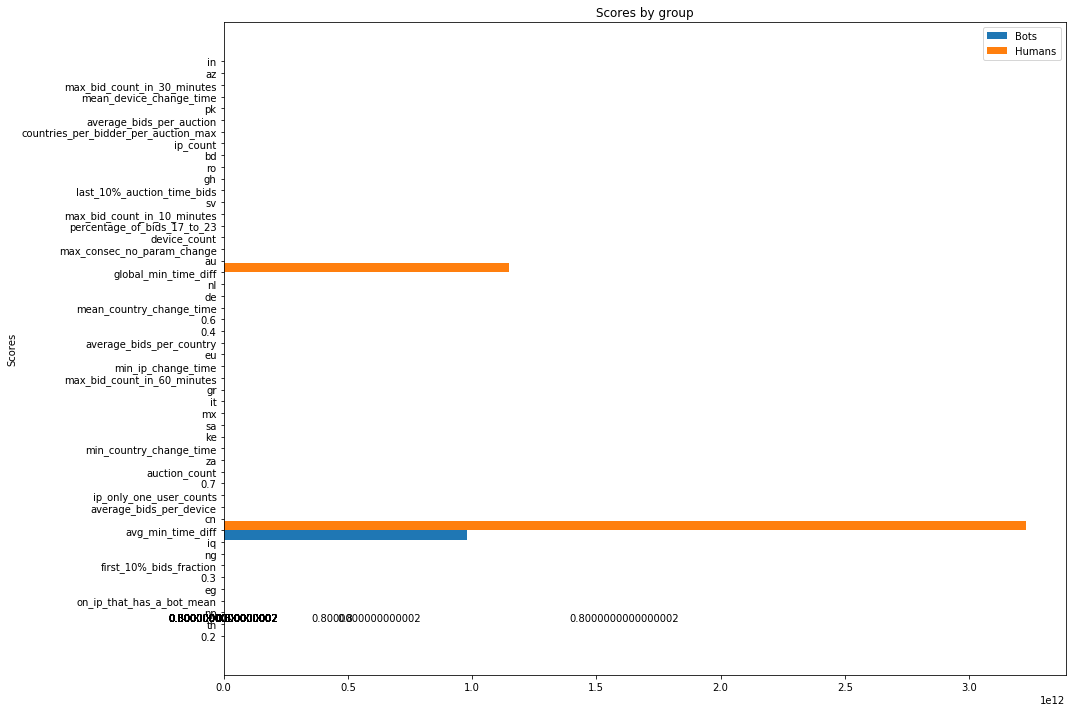

In [0]:
fig = plot_histogram(important_features, important_bots_mean, important_humans_mean)


In [0]:
normalized_bots_mean = important_bots_mean / np.linalg.norm(important_bots_mean)
normalized_humans_mean = important_humans_mean / np.linalg.norm(important_humans_mean)
normalized_xgb = (xgb_error_features.transpose() / np.linalg.norm(xgb_error_features, axis=1)).transpose()

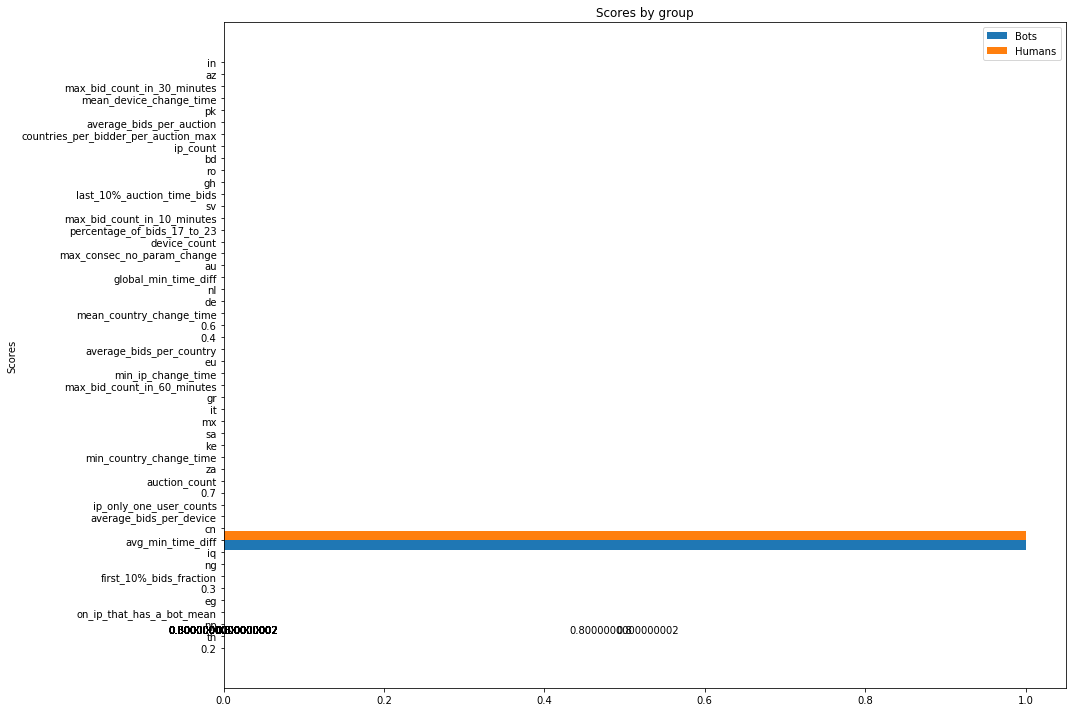

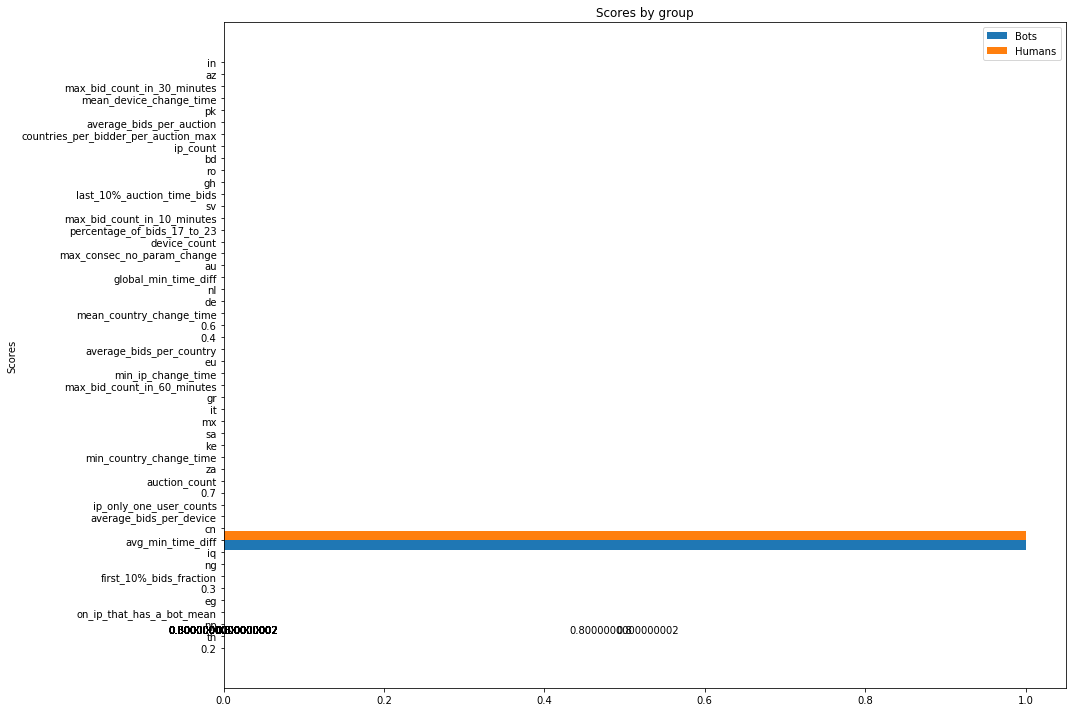

In [0]:
plot_histogram(important_features, normalized_bots_mean, normalized_bots_mean)

Nearest Neighbors of the bots that the model failed on



## 9.5 Nearest Neighbors

In [0]:
#K nearest neighbors
important_x_train = x_train[important_features]
knn = NearestNeighbors(n_neighbors=5, algorithm='brute').fit(important_x_train)
index_lst = knn.kneighbors(xgb_error_features, return_distance=False)
for i in index_lst:
  print(y_train.iloc[i])

1457    0.0
655     0.0
1893    0.0
61      1.0
419     0.0
Name: outcome, dtype: float64
741     0.0
1741    0.0
1532    0.0
856     0.0
1030    0.0
Name: outcome, dtype: float64
388     0.0
538     0.0
671     0.0
573     0.0
1820    0.0
Name: outcome, dtype: float64
392     0.0
1673    0.0
1484    0.0
217     0.0
157     0.0
Name: outcome, dtype: float64
234     0.0
1852    0.0
18      1.0
1467    0.0
1798    0.0
Name: outcome, dtype: float64
273     0.0
833     0.0
2004    0.0
1756    0.0
1351    0.0
Name: outcome, dtype: float64
3       1.0
1563    0.0
788     0.0
99      1.0
60      1.0
Name: outcome, dtype: float64
749     0.0
26      1.0
1768    0.0
912     0.0
928     0.0
Name: outcome, dtype: float64
1205    0.0
1906    0.0
973     0.0
907     0.0
118     0.0
Name: outcome, dtype: float64
1949    0.0
1935    0.0
1715    0.0
936     0.0
1878    0.0
Name: outcome, dtype: float64
1685    0.0
1819    0.0
1028    0.0
1394    0.0
13      1.0
Name: outcome, dtype: float64
1310    0.

# 10. SMOTE Resampling

In [0]:
X = pd.read_csv('/content/Data-Science/Data/Train_Clean_All_Features')

In [99]:
X.head()

,Unnamed: 0,bidder_id,outcome,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,...,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,Unnamed: 0_y,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11
0,1754,3b8320619393a6f6bf12219b61cda688k4w4e,0.0,False,0,1,0,1,10,9,1,7,3,10,3,1.111111,1.428571,3.333333,3.333333,1.000000,0.285714,1,0.600000,1,1.000000,1,1.0,1,0.333333,1.0,1.111111,2.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,2.0,2.0,0.200000,3.871053e+12,3.871053e+12,6.247368e+10,3.755789e+12,2.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,473,1.0,2.0,2.0,0.0,0.000000,49246.0,35175.0,27358.0,4711.0,1187.0,1187.0,10.000000,50.000000,30.000000,10.000000
1,1425,5e3747785e44d85a41a74470c051e946x01dp,0.0,False,0,1,0,0,1,1,1,1,1,1,1,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1,1.000000,1,1.000000,1,1.0,0,0.000000,1.0,1.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,1.0,1.000000,1.598882e+12,4.422000e+12,7.894737e+08,5.696500e+12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,746,1.0,1.0,1.0,0.0,0.000000,15322.0,11968.0,11621.0,319.5,128.0,92.0,0.000000,0.000000,100.000000,0.000000
2,1534,8b4bcc98fa4666b22c7a17c9a4b93ebenlmlb,0.0,False,0,1,0,1,2,2,1,2,2,2,1,1.000000,1.000000,2.000000,1.000000,1.000000,0.333333,1,0.500000,1,1.000000,1,1.0,1,1.000000,1.0,1.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1.0,1.0,0.500000,1.598882e+12,4.422000e+12,7.024479e+13,7.024479e+13,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1106,1.0,1.0,1.0,0.0,0.000000,38651.0,38651.0,38651.0,38651.0,38651.0,38651.0,50.000000,0.000000,50.000000,0.000000
3,1945,7d063aa96e7a065ed5ff9deb7c851bddhrxdj,0.0,False,0,1,0,0,16,9,1,7,3,11,5,1.777778,2.285714,3.200000,5.333333,1.333333,0.000000,1,0.909091,1,1.000000,1,1.0,1,0.200000,1.0,1.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,2.0,5.0,0.312500,1.582868e+12,2.645237e+12,5.263158e+07,4.473895e+12,5.0,2.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,994,3.0,3.0,3.0,1.0,1.000000,25671.0,25671.0,16503.0,682.0,682.0,1.0,6.250000,50.000000,0.000000,43.750000
4,856,0a43de0ab0a7525fec59ef4bc1dda7a2z9z69,0.0,False,0,1,0,0,743,194,1,202,42,533,12,3.829897,3.678218,61.916667,17.690476,1.108955,0.324545,1,0.262664,1,0.980198,1,1.0,1,0.083333,1.0,1.077320,5.0,0.0,0.077068,0.0,0.0,0.0,0.0,0.0,0.0,...,2,101.0,131.0,0.176312,1.634161e+12,4.250099e+12,0.000000e+00,3.861053e+11,131.0,47.0,96.0,73.0,64.0,68.0,71.0,24.0,68.0,99.0,2.0,0.0,0.0,3.0,0.0,0.0,81,14.0,26.0,48.0,4.0,1.242424,796.0,390.0,385.0,1.0,0.0,0.0,19.919246,47.375505,15.746972,16.958277


In [0]:
#drop bidders with 1 bid or less

bots = X[X['outcome'] == 1]
ind = bots[bots['bids_count'] <= 1].index
X.drop(labels=ind, axis=0, inplace=True)

In [101]:
X.shape

(2008, 267)

In [102]:
Y = X['outcome']
X.drop(labels=['outcome', 'bidder_id', 'Unnamed: 0'], axis=1, inplace=True)
X.head()

,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,...,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,Unnamed: 0_y,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11
0,False,0,1,0,1,10,9,1,7,3,10,3,1.111111,1.428571,3.333333,3.333333,1.000000,0.285714,1,0.600000,1,1.000000,1,1.0,1,0.333333,1.0,1.111111,2.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0,2.0,2.0,0.200000,3.871053e+12,3.871053e+12,6.247368e+10,3.755789e+12,2.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,473,1.0,2.0,2.0,0.0,0.000000,49246.0,35175.0,27358.0,4711.0,1187.0,1187.0,10.000000,50.000000,30.000000,10.000000
1,False,0,1,0,0,1,1,1,1,1,1,1,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1,1.000000,1,1.000000,1,1.0,0,0.000000,1.0,1.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0,0.0,1.0,1.000000,1.598882e+12,4.422000e+12,7.894737e+08,5.696500e+12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,746,1.0,1.0,1.0,0.0,0.000000,15322.0,11968.0,11621.0,319.5,128.0,92.0,0.000000,0.000000,100.000000,0.000000
2,False,0,1,0,1,2,2,1,2,2,2,1,1.000000,1.000000,2.000000,1.000000,1.000000,0.333333,1,0.500000,1,1.000000,1,1.0,1,1.000000,1.0,1.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0,1.0,1.0,0.500000,1.598882e+12,4.422000e+12,7.024479e+13,7.024479e+13,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1106,1.0,1.0,1.0,0.0,0.000000,38651.0,38651.0,38651.0,38651.0,38651.0,38651.0,50.000000,0.000000,50.000000,0.000000
3,False,0,1,0,0,16,9,1,7,3,11,5,1.777778,2.285714,3.200000,5.333333,1.333333,0.000000,1,0.909091,1,1.000000,1,1.0,1,0.200000,1.0,1.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0,2.0,5.0,0.312500,1.582868e+12,2.645237e+12,5.263158e+07,4.473895e+12,5.0,2.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,994,3.0,3.0,3.0,1.0,1.000000,25671.0,25671.0,16503.0,682.0,682.0,1.0,6.250000,50.000000,0.000000,43.750000
4,False,0,1,0,0,743,194,1,202,42,533,12,3.829897,3.678218,61.916667,17.690476,1.108955,0.324545,1,0.262664,1,0.980198,1,1.0,1,0.083333,1.0,1.077320,5.0,0.0,0.077068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00188,0.0,...,2,101.0,131.0,0.176312,1.634161e+12,4.250099e+12,0.000000e+00,3.861053e+11,131.0,47.0,96.0,73.0,64.0,68.0,71.0,24.0,68.0,99.0,2.0,0.0,0.0,3.0,0.0,0.0,81,14.0,26.0,48.0,4.0,1.242424,796.0,390.0,385.0,1.0,0.0,0.0,19.919246,47.375505,15.746972,16.958277


In [0]:
#split to train and test
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=4)

In [104]:
x_train.shape

(1506, 264)

In [105]:
x_test.shape

(502, 264)

## 10.1 Added SMOTE component

In [106]:
x_train_resampled, y_train_resampled = SMOTE().fit_resample(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
x_train_resampled_df = pd.DataFrame(x_train_resampled, columns=x_train.columns)

In [108]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=50, random_state=42, eval_metric=["auc", "error", "error@0.6"])
xgbrf_model = xgb.XGBRFClassifier(max_depth=10,objective="binary:logistic", n_estimators=150, random_state=5, eval_metric=["auc", "error", "error@0.6"])
rf = RF(n_estimators=50, max_depth=8, max_features=20)
rf = AdaB(base_estimator=rf, n_estimators=50)

NameError: ignored

In [109]:
#fit models and predict
xgb_model.fit(x_train_resampled_df, y_train_resampled)
xgbrf_model.fit(x_train_resampled_df, y_train_resampled)
rf.fit(x_train_resampled_df, y_train_resampled)

xgb_pred = xgb_model.predict(x_test)
xgbrf_pred = xgbrf_model.predict(x_test)
rf_pred = rf.predict(x_test)

NameError: ignored

In [0]:
#models average precision score on test
print('xgb: ' + str(average_precision_score(y_test, xgb_pred)))
print('xgbrf: ' + str(average_precision_score(y_test,xgbrf_pred )))
print('RF_Ada: ' + str(average_precision_score(y_test, rf_pred)))

In [0]:
#models recall score on test
print('xgb: ' + str(recall_score(y_test, xgb_pred)))
print('xgbrf: ' + str(recall_score(y_test,xgbrf_pred )))
print('RF_Ada: ' + str(recall_score(y_test, rf_pred)))

In [0]:
xgb_train_pred = xgb_model.predict(x_train)
xgbrf_train_pred = xgbrf_model.predict(x_train)
rf_train_pred = rf.predict(x_train)

#models average precision score on train
print('xgb: ' + str(average_precision_score(y_train, xgb_train_pred)))
print('xgbrf: ' + str(average_precision_score(y_train,xgbrf_train_pred )))
print('RF_Ada: ' + str(average_precision_score(y_train, rf_train_pred)))

In [0]:
#models recall score on train
print('xgb: ' + str(recall_score(y_train, xgb_train_pred)))
print('xgbrf: ' + str(recall_score(y_train,xgbrf_train_pred )))
print('RF_Ada: ' + str(recall_score(y_train, rf_train_pred)))

In [0]:
#take a look at the bidders that xgb failed to classify right
wrong_xgb = x_test[xgb_pred != y_test]
wrong_xgb

In [0]:
wrong_rf =x_test[rf_pred != y_test]
wrong_rf

In [0]:
#the model failed to classify 74% of bots in x_test
y_test[ xgb_pred != y_test]

**Compare missed bots to humans and bots in train set**

In [0]:
x_train['outcome'] = y_train


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
x_train

,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,...,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11,outcome
303,False,0,1,0,1,2,2,1,2,2,2,2,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,1,0.500000,1,1.000000,1,1.0,0,0.000000,1.0,1.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.000000,1.598882e+12,4.422000e+12,4.949158e+12,4.949158e+12,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,7634.0,7634.0,7634.0,7634.0,7634.0,7634.0,0.000000,0.000000,0.000000,100.000000,0.0
1428,False,0,0,0,1,6,5,1,5,2,5,1,1.200000,1.200000,6.000000,3.000000,1.000000,0.400000,1,0.400000,1,1.000000,1,1.0,1,1.000000,1.0,1.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.000000,1.130842e+12,1.130842e+12,1.994737e+10,1.818895e+12,0.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,1.0,1.000000,28212.0,20828.0,20828.0,21865.0,379.0,379.0,33.333333,0.000000,33.333333,33.333333,0.0
535,False,0,1,0,1,2,2,1,2,2,2,2,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,1,0.500000,1,1.000000,1,1.0,1,0.500000,1.0,1.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1.0,1.0,0.500000,1.598882e+12,4.422000e+12,7.461342e+13,7.461342e+13,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,35255.0,35255.0,35255.0,35255.0,35255.0,35255.0,50.000000,0.000000,0.000000,50.000000,0.0
487,False,0,1,0,0,2,2,1,2,2,2,2,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,1,0.500000,1,1.000000,1,1.0,0,0.000000,1.0,1.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1.0,0.0,0.000000,1.598882e+12,4.422000e+12,4.423053e+12,4.423053e+12,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,84038.0,84038.0,84038.0,84038.0,84038.0,84038.0,0.000000,100.000000,0.000000,0.000000,0.0
280,False,0,0,0,0,155,23,1,53,2,123,91,6.739130,2.924528,1.703297,77.500000,1.201550,0.359504,1,0.260163,1,1.000000,1,1.0,1,0.010989,1.0,1.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,7.0,78.0,0.503226,9.250596e+11,3.693323e+12,5.263158e+07,1.619211e+12,78.0,25.0,16.0,4.0,1.0,3.0,13.0,4.0,4.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,15.0,23.0,7.0,2.909091,50994.0,1764.0,1591.0,5352.0,1.0,1.0,9.677419,47.096774,4.516129,38.709677,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [0]:
humans = x_train[x_train['outcome'] == 0]

In [0]:
humans.describe()

,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,aw,...,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11,outcome
count,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1.433000e+03,1433.000000,1433.000000,1433.0,1433.000000,1433.000000,1433.000000,1433.000000,1433.0,...,1433.000000,1433.000000,1433.000000,1433.000000,1.433000e+03,1.433000e+03,1.433000e+03,1.433000e+03,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.0
mean,0.105373,0.647592,0.078856,0.378925,1377.209351,56.502442,0.984648,70.240754,12.187020,573.013259,327.100488,6.448070,11.098711,14.618273,38.714421,1.515023,0.227529,0.808095,0.407700,0.981856,0.968438,0.983252,0.983052,0.792742,0.249912,1.048500,1.159371,4.306350,0.000011,0.022219,0.000920,1.332543e-07,0.000665,0.000131,0.0,0.000394,0.013108,0.000720,0.015115,0.0,...,2.504536,324.730635,361.835311,0.224995,3.207864e+12,9.581549e+12,1.053398e+12,2.153657e+13,361.835311,274.837404,52.251919,36.517097,35.313329,42.618981,40.773901,28.513608,179.817167,322.201675,2.528960,96.565946,91.436148,361.266574,33.037683,39.410328,13.279833,27.071179,45.214236,8.064201,3.859146,20589.773203,19080.776692,19150.267969,6191.650733,6840.545708,6178.928821,23.640190,36.057221,16.925307,21.772258,0.0
std,0.307141,0.477887,0.269607,0.485289,15607.896510,140.223794,0.128545,173.820225,21.919799,4379.533049,2884.290531,32.737638,131.692885,135.567664,233.116587,6.773299,0.171499,0.393936,0.332643,0.133518,0.137547,0.128371,0.128362,0.405483,0.350546,0.789411,0.829787,9.768283,0.000332,0.101295,0.009867,3.762506e-06,0.008215,0.001798,0.0,0.006018,0.092043,0.007887,0.098827,0.0,...,22.727008,3665.530280,5001.407102,0.256752,6.826839e+12,1.270406e+13,6.848882e+12,2.424192e+13,5001.407102,4308.570678,568.884694,275.498210,241.447365,287.745909,271.966428,214.243899,1745.431182,3650.884800,22.826909,2680.167312,1960.127662,8246.152873,808.418833,889.235154,84.045407,181.801531,347.642153,130.053051,64.944045,19880.055789,20970.6

In [0]:
bots = x_train[x_train['outcome'] == 1]
bots.describe()

,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,aw,...,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11,outcome
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.0,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.0,73.000000,73.0,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.0,73.000000,73.000000,73.0,73.000000,73.000000,73.0,73.000000,73.000000,73.000000,73.000000,73.0,...,73.000000,73.000000,73.000000,73.000000,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.0
mean,0.109589,0.616438,0.109589,0.410959,2899.054795,148.780822,1.0,166.136986,24.547945,1597.465753,579.506849,20.513459,118.683542,127.838761,172.034211,9.008074,0.274400,0.945205,0.324889,1.0,0.972152,1.0,0.999744,0.917808,0.179612,1.041096,1.230545,7.465753,0.0,0.010000,0.000208,0.0,0.000829,0.000021,0.0,0.000160,0.029886,0.002258,0.094447,0.0,...,7.369863,587.958904,557.726027,0.210709,1.080348e+12,7.175609e+12,1.031002e+08,1.703602e+13,557.726027,371.589041,170.643836,149.671233,179.547945,199.041096,168.917808,153.000000,360.958904,580.534247,7.424658,72.287671,151.602740,528.493151,38.917808,59.726027,46.232877,97.945205,161.534247,84.205479,38.524037,6909.342466,3421.424658,3109.438356,2304.424658,1013.616438,1075.904110,28.799723,28.867940,19.280964,23.051374,1.0
std,0.314539,0.489618,0.314539,0.495413,5287.140363,195.633249,0.0,218.364840,26.143855,3334.890578,1276.940855,29.120622,366.476816,341.713637,337.261462,29.831335,0.154865,0.229154,0.282694,0.0,0.042815,0.0,0.002188,0.276557,0.296944,0.351123,0.399692,9.708362,0.0,0.042562,0.000769,0.0,0.005649,0.000111,0.0,0.001178,0.124209,0.014860,0.250937,0.0,...,18.671507,1092.833428,1043.338409,0.205923,1.562311e+12,8.329328e+12,4.157597e+08,2.329886e+13,1043.338409,668.423868,360.148710,391.835391,471.157205,482.476466,404.977597,422.301762,752.031571,1077.702251,18.719359,259.120011,472.381665,1816.047632,160.387011,191.897778,49.028484,114.016189,204.604774,332.670715,164.665321,14523.194887,9745.262218,9569.947028,10820.139820,6617.551206,8438.782272,17.632308,18.806539,15.345216,12.778936,0.0
min,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.902778,1.333333,1.266082,2.

In [0]:
bots_mean = bots.describe().loc['mean']
human_mean = humans.describe().loc['mean']
names = x_train.columns

In [0]:
bots.describe().loc['mean'].values

array([1.09589041e-01, 6.16438356e-01, 1.09589041e-01, 4.10958904e-01,
       2.89905479e+03, 1.48780822e+02, 1.00000000e+00, 1.66136986e+02,
       2.45479452e+01, 1.59746575e+03, 5.79506849e+02, 2.05134591e+01,
       1.18683542e+02, 1.27838761e+02, 1.72034211e+02, 9.00807386e+00,
       2.74400356e-01, 9.45205479e-01, 3.24889249e-01, 1.00000000e+00,
       9.72152423e-01, 1.00000000e+00, 9.99743951e-01, 9.17808219e-01,
       1.79612131e-01, 1.04109589e+00, 1.23054497e+00, 7.46575342e+00,
       0.00000000e+00, 9.99971818e-03, 2.08076661e-04, 0.00000000e+00,
       8.29061999e-04, 2.06201740e-05, 0.00000000e+00, 1.59634844e-04,
       2.98864834e-02, 2.25782660e-03, 9.44472784e-02, 0.00000000e+00,
       1.09463513e-03, 6.47415427e-05, 0.00000000e+00, 2.13658959e-03,
       3.92498506e-04, 2.95144025e-05, 1.97907007e-04, 7.79099733e-04,
       0.00000000e+00, 1.79964984e-05, 0.00000000e+00, 7.39283017e-03,
       4.56959240e-04, 7.08801807e-03, 0.00000000e+00, 1.57184511e-05,
      


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


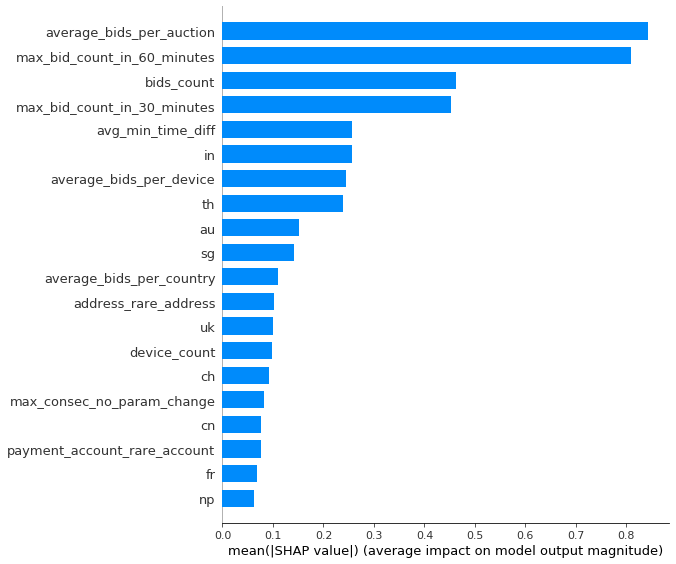

In [0]:
#SHAP
#, np.array(x_train, dtype=np.float64)
x_train.drop('outcome', axis=1, inplace=True)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type='bar')

Looks like the classifier gave high importance to more one-hot country columns than witout the SMOTE, probably due to them becoming non-binary after resampling.
This could imply that data cleaning after resampling is of certain value.

In [0]:
def shap_plot(S,model,j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [0]:
shap.initjs()
S = x_test[wrong]
shap_plot(S, xgbrf_model, 0)

In [0]:
#kernelExplainer
rf_shap_values = shap.KernelExplainer(rf.predict ,wrong_rf)

In [0]:
wrong_rf.astype('float64')

,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,...,zz,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11
306,0.0,0.0,1.0,0.0,1.0,329.0,97.0,1.0,87.0,40.0,289.0,11.0,3.391753,3.781609,29.909091,8.225000,1.031348,0.369732,1.0,0.290657,1.0,0.988506,1.0,1.000000,1.0,0.090909,1.0,1.505155,6.0,0.000000,0.010101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,...,0.000000,2.0,19.0,7.0,0.021277,1.388689e+11,2.980209e+11,0.0,4.151474e+12,7.0,220.0,7.0,2.0,1.0,2.0,47.0,24.0,0.0,17.0,2.0,0.0,6.0,8.0,0.0,3.0,45.0,117.0,191.0,0.0,0.000000,40.0,302.0,292.0,0.0,0.0,0.0,78.115502,21.884498,0.000000,0.000000
162,0.0,0.0,0.0,0.0,1.0,3057.0,365.0,1.0,147.0,83.0,1482.0,9.0,8.375342,20.795918,339.666667,36.831325,1.540050,0.360326,1.0,0.255061,1.0,0.986395,1.0,1.000000,1.0,0.111111,1.0,1.482192,35.0,0.000000,0.012579,0.048218,0.000000,0.006289,0.006289,0.000000,0.004193,0.041929,0.073375,0.041929,...,0.000000,15.0,629.0,942.0,0.308145,2.159752e+12,1.701177e+13,0.0,5.005232e+13,942.0,808.0,146.0,36.0,43.0,54.0,44.0,28.0,327.0,614.0,15.0,1.0,12.0,43.0,0.0,3.0,32.0,57.0,83.0,12.0,2.167630,374.0,368.0,324.0,0.0,0.0,0.0,15.865227,32.188420,29.506052,22.440301
861,0.0,0.0,1.0,0.0,1.0,5189.0,251.0,1.0,425.0,71.0,1494.0,1140.0,20.673307,12.209412,4.551754,73.084507,1.787461,0.103954,1.0,0.536145,1.0,0.960000,1.0,1.000000,1.0,0.383333,1.0,1.992032,15.0,0.000000,0.000504,0.000000,0.000000,0.001512,0.000000,0.000000,0.000000,0.000000,0.000504,0.000504,...,0.000000,5.0,712.0,697.0,0.134323,5.327437e+11,2.542263e+12,0.0,6.089474e+10,697.0,398.0,459.0,361.0,527.0,560.0,459.0,394.0,622.0,707.0,5.0,14.0,36.0,240.0,20.0,32.0,37.0,92.0,171.0,2.0,1.035533,67.0,53.0,55.0,0.0,0.0,0.0,26.498362,27.962999,21.796107,23.742532
137,0.0,0.0,1.0,0.0,1.0,7054.0,551.0,1.0,451.0,76.0,3887.0,4233.0,12.802178,15.640798,1.666430,92.815789,1.254937,0.357384,1.0,0.157448,1.0,0.977827,1.0,1.000000,1.0,0.000472,1.0,1.152450,31.0,0.000000,0.011289,0.000452,0.000000,0.000452,0.000000,0.000000,0.000000,0.003161,0.000000,0.006999,...,0.000000,19.0,1085.0,980.0,0.138928,8.566493e+11,3.367271e+12,0.0,2.684211e+10,980.0,511.0,754.0,591.0,559.0,799.0,676.0,437.0,662.0,1066.0,19.0,5.0,10.0,117.0,5.0,7.0,48.0,129.0,233.0,7.0,1.373626,65.0,38.0,37.0,0.0,0.0,0.0,22.937341,37.056989,15.055288,24.950383
8,0.0,0.0,1.0,0.0,0.0,923.0,55.0,1.0,124.0,1.0,915.0,1.0,16.781818,7.443548,923.000000,923.000000,1.001085,0.496454,0.0,0.000000,1.0,0.693548,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [0]:
shap.summary_plot(rf_shap_values.shap_values(wrong_rf.astype('float64')), wrong_rf.astype('float64'))

TypeError: ignored

## 10.2 Analyzing Mistakes After SMOTE Resampling

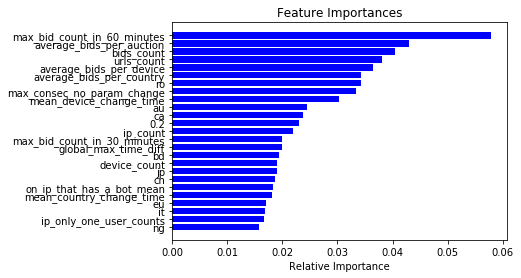

In [0]:
importances = xgb_model.feature_importances_
indices = np.argsort(importances)
features = x_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices[len(indices)-25:len(indices)])), importances[indices[len(indices)-25:len(indices)]], color='b', align='center')
plt.yticks(range(len(indices[len(indices)-25:len(indices)])), [features[i] for i in indices[len(indices)-25:len(indices)]])
plt.xlabel('Relative Importance')
plt.show()

In [0]:
important_features = features[indices[len(indices)-50:len(indices)]]

In [0]:
values = importances[indices[len(indices)-50:len(indices)]]
sum(values)

0.9288234054110944

In [0]:
xgb_error_features = (x_test[xgb_pred != y_test])[important_features]
xgb_error_features

,bids_per_auction_per_ip_mean,hk,qa,th,id,address_rare_address,de,0.4,sg,percentage_of_bids_17_to_23,tr,last_10%_auction_time_bids,no,be,average_bids_per_url,cz,percentage_of_bids_5_to_11,first_10%_auction_time_bids,in,ch,mean_consec_no_param_change,0.9,avg_max_time_diff,np,py,ng,ip_only_one_user_counts,it,eu,mean_country_change_time,on_ip_that_has_a_bot_mean,cn,jp,device_count,bd,global_max_time_diff,max_bid_count_in_30_minutes,ip_count,0.2,ca,au,mean_device_change_time,max_consec_no_param_change,ro,average_bids_per_country,average_bids_per_device,urls_count,bids_count,average_bids_per_auction,max_bid_count_in_60_minutes
306,1.031348,0.010101,0.010101,0.060606,0.010101,1,0.040404,2.0,0.030303,21.884498,0.030303,19.0,0.010101,0.000000,29.909091,0.000000,0.000000,7.0,0.060606,0.000000,0.000000,0.0,2.980209e+11,0.000000,0.000000,0.101010,0.369732,0.000000,0.000000,40.0,0.290657,0.000000,0.010101,87,0.000000,4.151474e+12,117.0,289,220.0,0.191919,0.000000,302.0,0.0,0.010101,8.225000,3.781609,11,329,3.391753,191.0
162,1.540050,0.023061,0.004193,0.111111,0.111111,0,0.180294,36.0,0.012579,32.188420,0.180294,629.0,0.002096,0.010482,339.666667,0.058700,22.440301,942.0,1.000000,0.056604,2.167630,327.0,1.701177e+13,0.008386,0.000000,0.144654,0.360326,0.238994,0.136268,374.0,0.255061,0.000000,0.000000,147,0.002096,5.005232e+13,57.0,1482,808.0,0.111111,0.041929,368.0,12.0,0.236897,36.831325,20.795918,9,3057,8.375342,83.0
861,1.787461,0.009073,0.001008,0.001008,0.573589,1,0.024194,361.0,0.000000,27.962999,0.022177,712.0,0.007560,0.000504,4.551754,0.000504,23.742532,697.0,0.256552,0.000000,1.035533,622.0,2.542263e+12,0.002016,0.000504,1.000000,0.103954,0.000000,0.005544,67.0,0.536145,0.003024,0.000000,425,0.004032,6.089474e+10,92.0,1494,398.0,0.016129,0.000504,53.0,2.0,0.000000,73.084507,12.209412,1140,5189,20.673307,171.0
137,1.254937,0.000000,0.008354,0.004967,0.047415,1,0.005193,591.0,0.001580,37.056989,0.049221,1085.0,0.000677,0.000000,1.666430,0.001355,24.950383,980.0,1.000000,0.000000,1.373626,662.0,3.367271e+12,0.000452,0.001806,0.006774,0.357384,0.005193,0.000452,65.0,0.157448,0.000000,0.000452,451,0.001129,2.684211e+10,129.0,3887,511.0,0.000452,0.006999,38.0,7.0,0.002484,92.815789,15.640798,4233,7054,12.802178,233.0
8,1.001085,0.000000,0.000000,0.000000,0.000000,1,0.000000,73.0,0.000000,0.000000,0.000000,74.0,0.000000,0.000000,923.000000,0.000000,55.796316,1.0,0.000000,0.000000,0.000000,383.0,2.572043e+12,0.000000,0.000000,0.000000,0.496454,0.000000,0.000000,1330.0,0.000000,0.000000,0.000000,124,0.000000,4.671684e+12,95.0,915,15.0,0.000000,0.000000,186.0,0.0,0.000000,923.000000,7.443548,1,923,16.781818,158.0
132,1.043646,0.000000,0.000000,0.000000,0.000000,1,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.089812,0.000000,60.885609,11.0,0.000000,0.351667,1.000000,0.0,2.890319e+12,0.000000,0.000000,0.000000,0.485117,0.000000,0.000000,34274.0,0.042362,0.000000,0.000000,3,0.000000,5.034947e+12,294.0,779,506.0,0.000000,0.000000,51411.0,1.0,0.000000,271.000000,271.000000,746,813,42.789474,449.0
1538,1.240482,0.015422,0.002537,0.041527,0.052876,1,0.305241,3415.0,0.030066,28.797357,0.027885,58164.0,0.006432,0.007233,716.526549,0.007789,22.630068,29186.0,0.698053,0.029487,1.022654,30521.0,1.214920e+13,0.002403,0.000601,0.000912,0.419912,0.030978,0.020430,6.0,0.041477,0.039012,0.019539,1144,0.002337,5.002111e+13,1141.0,111918,24227.0,0.021587,0.052231,5.0,2.0,0.018493,909.747191,141.551573,226,161935,194.867629,2231.0
1499,1.527871,0.000000,0.000000,0.000000,0.000000,0,0.000000,1.0,0.000000,30.417582,0.000000,434.0,0.000000,0.000000,3.013245,0.000000,17.450549,816.0,0.000000,0.000000,1.078947,205.0,2.469945e+13,0.000000,0.000000,0.000000,0.395911,0.000000,0.000000,1330.0,0.024259,0.000000,0.000000,249,0.000000,5.008768e+13,36.0,1484,804.0,0.000000,0.000000,426.0,3.0,0.000000,2275.000000,9.136546,755,2275,325.000000,62.0
378,2.016760,0.000000,0.000000,0.000000,0.953757,0,1.000000,19.0,0.005780,10.803324,0.011561,37.0,0.000000,0

In [0]:
bots_mean = bots_mean.transpose()
human_mean = human_mean.transpose()

In [0]:
bots_mean

address_infrequent_address               0.109589
address_rare_address                     0.616438
payment_account_infrequent_account       0.109589
payment_account_rare_account             0.410959
bids_count                            2899.054795
                                         ...     
percentage_of_bids_11_to_17             28.799723
percentage_of_bids_17_to_23             28.867940
percentage_of_bids_23_to_5              19.280964
percentage_of_bids_5_to_11              23.051374
outcome                                  1.000000
Name: mean, Length: 263, dtype: float64

In [0]:
important_bots_mean = bots_mean[important_features]
important_humans_mean = human_mean[important_features]

In [0]:
important_bots_mean.values

array([9.00807386e+00, 3.10481300e-03, 3.00550869e-03, 1.55905273e-01,
       2.57700600e-01, 6.16438356e-01, 5.06638766e-02, 1.49671233e+02,
       3.54142360e-02, 2.88679396e+01, 2.18356897e-02, 5.87958904e+02,
       1.28619534e-02, 3.92498506e-04, 1.27838761e+02, 1.72022458e-03,
       2.30513740e+01, 5.57726027e+02, 2.50649297e-01, 4.79773763e-03,
       3.85240371e+01, 3.60958904e+02, 7.17560920e+12, 2.92102312e-04,
       1.60611558e-03, 1.99272516e-02, 2.74400356e-01, 2.29760383e-02,
       1.55584813e-03, 6.90934247e+03, 3.24889249e-01, 2.34671130e-02,
       3.05618747e-02, 1.66136986e+02, 2.13658959e-03, 1.70360216e+13,
       9.79452055e+01, 1.59746575e+03, 3.71589041e+02, 3.95448839e-02,
       9.44472784e-02, 3.42142466e+03, 8.42054795e+01, 1.11106586e-03,
       1.72034211e+02, 1.18683542e+02, 5.79506849e+02, 2.89905479e+03,
       2.05134591e+01, 1.61534247e+02])

In [0]:
important_bots_mean

In [0]:
#histogram of bots vs humans
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        

def plot_histogram(names, bots_vals, humans_vals):
  x = np.arange(len(names))
  width = 0.8
  fig , ax = plt.subplots()
  rects1 = ax.barh(x - width/2, bots_vals.values.tolist(), width, label='Bots', align='center')
  rects2 = ax.barh(x + width/2, humans_vals.values.tolist(), width, label='Humans', align='center')
  fig.set_size_inches(15, 10)
  
  ax.set_ylabel('Scores')
  ax.set_title('Scores by group')
  ax.set_yticks(x)
  ax.set_yticklabels(names)
  ax.legend()



  autolabel(rects1)
  autolabel(rects2)
  fig.tight_layout()
  plt.show()
  return fig


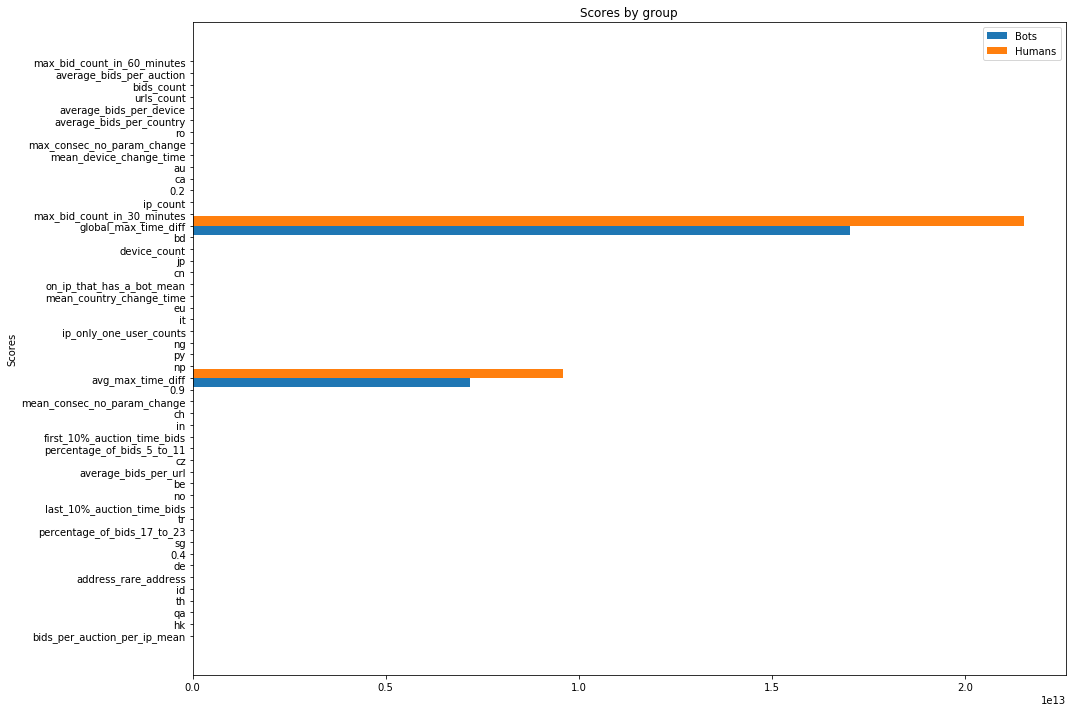

In [0]:
fig = plot_histogram(important_features, important_bots_mean, important_humans_mean)


In [0]:
l1 = [i for i in important_bots_mean.columns if i not in xgb_error_features.columns]
l2 = [i for i in xgb_error_features.columns if i not in important_bots_mean.columns]
print(l1)
print(l2)

[]
[]


In [0]:
normalized_bots_mean = important_bots_mean / np.linalg.norm(important_bots_mean)
normalized_humans_mean = important_humans_mean / np.linalg.norm(important_humans_mean)
normalized_xgb = (xgb_error_features.transpose() / np.linalg.norm(xgb_error_features, axis=1)).transpose()

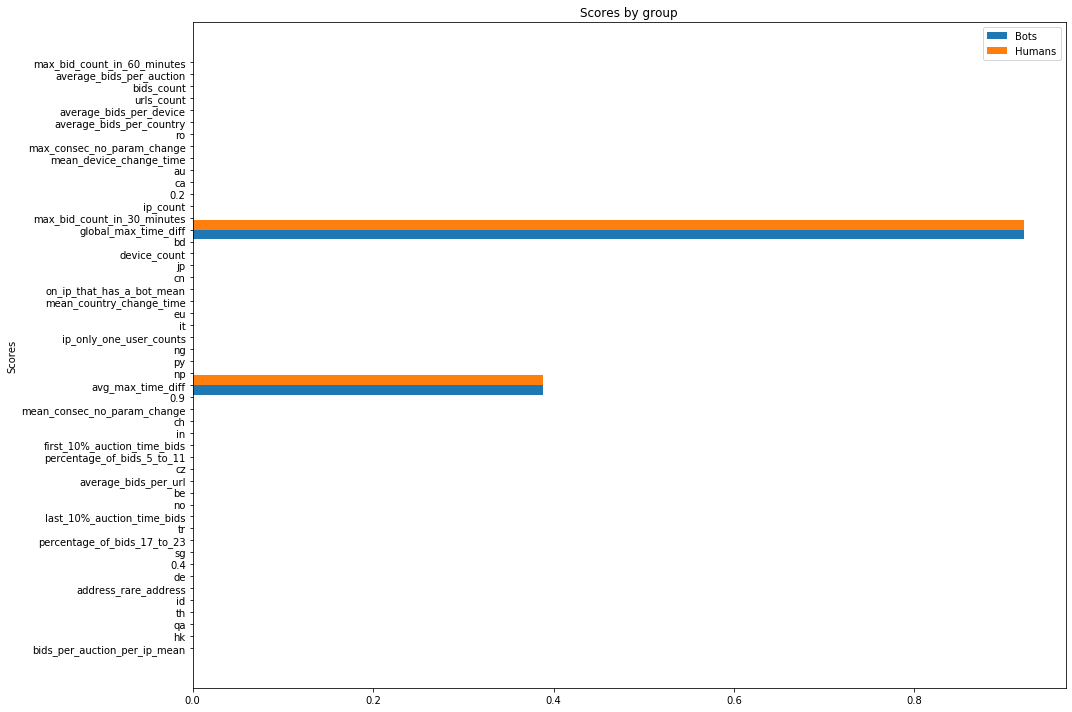

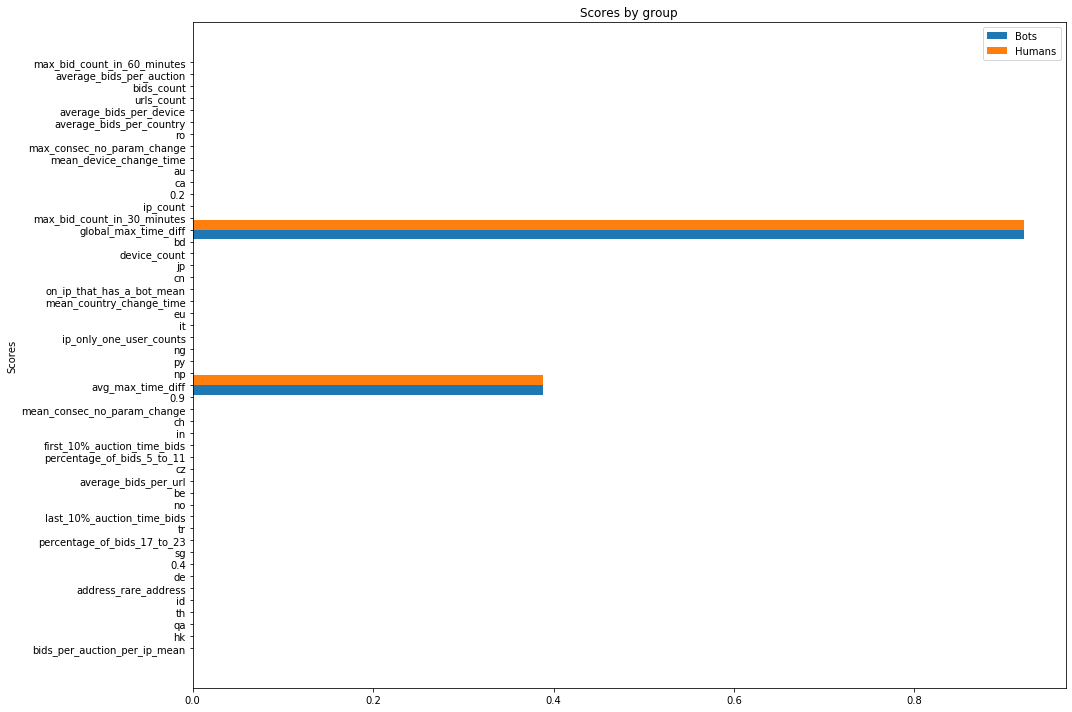

In [0]:
plot_histogram(important_features, normalized_bots_mean, normalized_bots_mean)

In [0]:
np.linalg.norm( normalized_xgb.values - normalized_bots_mean.values, axis=1)

array([0.32553086, 0.07100381, 1.08615733, 1.09953819, 0.10457591,
       0.12239513, 0.16020985, 0.05947369, 0.83271136, 1.05802231,
       1.07821564, 1.03194581, 0.87305526, 0.03850888, 0.03422908,
       0.03959127])

In [0]:
np.linalg.norm( normalized_xgb.values- normalized_humans_mean.values, axis=1)

array([0.34520077, 0.09093987, 1.06934979, 1.08281709, 0.08464582,
       0.10247426, 0.18008994, 0.03952737, 0.81452936, 1.04103795,
       1.06135753, 1.01480332, 0.85506102, 0.01855848, 0.01427812,
       0.05953757])

Nearest Neighbors of the bots that the model failed on



In [0]:
#K nearest neighbors
important_x_train = x_train[important_features]
knn = NearestNeighbors(n_neighbors=5, algorithm='brute').fit(important_x_train)
index_lst = knn.kneighbors(xgb_error_features, return_distance=False)
for i in index_lst:
  print(y_train.iloc[i])

1645    0.0
1500    0.0
1709    0.0
1398    0.0
1423    0.0
Name: outcome, dtype: float64
1517    1.0
1117    0.0
1788    0.0
444     0.0
7       0.0
Name: outcome, dtype: float64
1107    0.0
1760    0.0
1615    0.0
1177    0.0
1926    0.0
Name: outcome, dtype: float64
976     0.0
166     0.0
323     1.0
1272    0.0
1166    0.0
Name: outcome, dtype: float64
1439    0.0
119     0.0
1710    0.0
219     0.0
1933    0.0
Name: outcome, dtype: float64
627     0.0
1710    0.0
322     0.0
1439    0.0
39      0.0
Name: outcome, dtype: float64
1510    0.0
948     0.0
951     0.0
1682    0.0
121     0.0
Name: outcome, dtype: float64
1574    0.0
1654    0.0
243     0.0
1738    0.0
365     0.0
Name: outcome, dtype: float64
582     0.0
1454    0.0
1150    0.0
890     0.0
27      0.0
Name: outcome, dtype: float64
876     0.0
732     0.0
176     1.0
1089    0.0
1502    0.0
Name: outcome, dtype: float64
1926    0.0
234     0.0
1615    0.0
257     0.0
732     0.0
Name: outcome, dtype: float64
1199    0.